# ECSE 415 - Intro. To Computer Vision
## Tutorial: Segmentation and Stereo

##### Graph Cut Segmentation

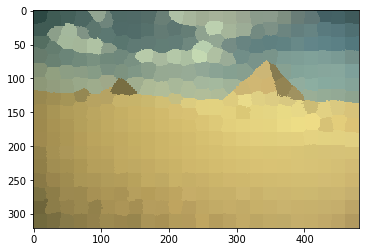

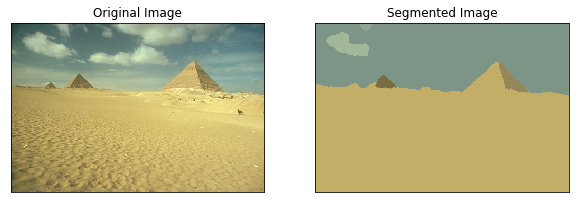

In [1]:
from skimage import segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import cv2

# Read image
img = cv2.cvtColor(cv2.imread('pyramids.jpg'), cv2.COLOR_BGR2RGB)

# apply k-means. This will generate super pixels
labels1 = segmentation.slic(img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')
plt.imshow(out1); plt.show()
# apply graph cut
g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg')

# display
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(out2)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])
plt.show()

##### MeanShift Segmentation

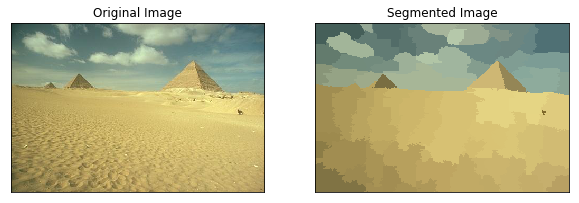

In [2]:
from skimage.segmentation import quickshift
from matplotlib import pyplot as plt
import cv2

# Read image
img = cv2.cvtColor(cv2.imread('pyramids.jpg'), cv2.COLOR_BGR2RGB)

# apply meanshift
label = quickshift(img, max_dist=20)
out = color.label2rgb(label, img, kind='avg')

# display
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(out)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])
plt.show()

##### Depth Map from Stereo Images

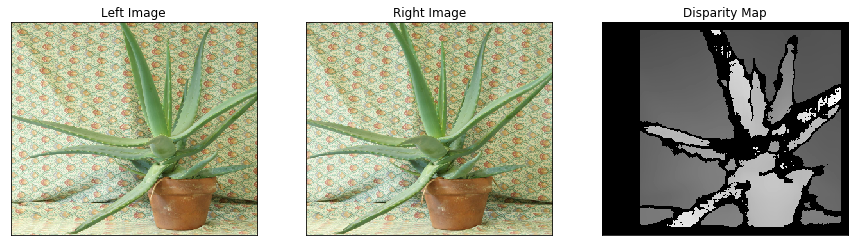

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# load left and right images
imgL = cv2.imread("aloeL.jpg");
imgR = cv2.imread("aloeR.jpg");

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# convert to grayscale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# compute disparity map
stereo = cv2.StereoBM_create(numDisparities=16*3, blockSize=25)
disparity = stereo.compute(imgL_gray, imgR_gray)

# display images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(disparity, cmap="gray")
plt.title("Disparity Map"), plt.xticks([]), plt.yticks([])
plt.show()

##### Epipolar Geometry

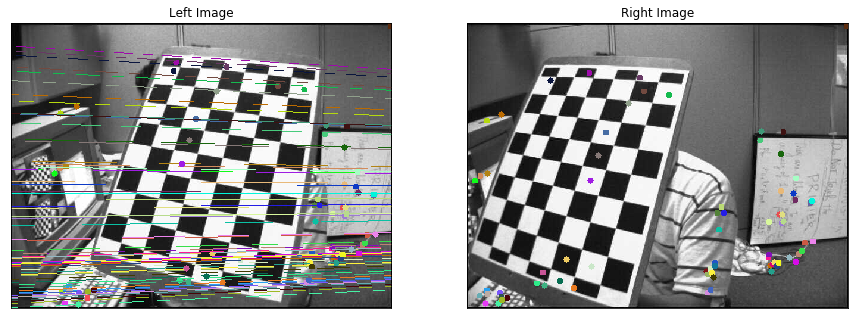

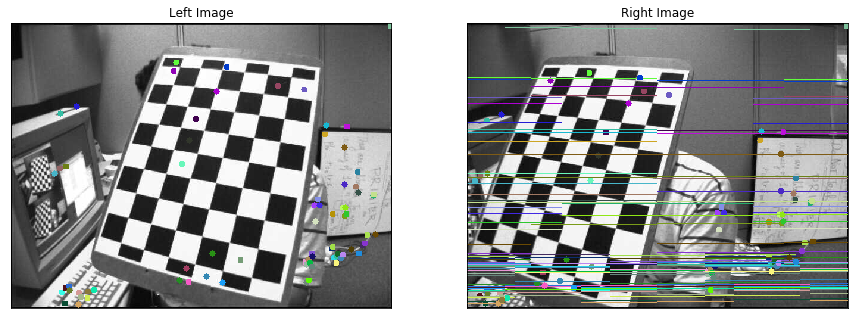

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# load left and right images
imgL = cv2.imread("left08.jpg", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread("right08.jpg", cv2.IMREAD_GRAYSCALE)

# data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA1oAAAKVCAYAAADWa5pLAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvpW3flQAAIABJREFUeJzsvV2obc2a3/WvGmPOtfbe78c5p9vExKQTJZALLxS8MCgxigp6IUIjUTAtufBCxIASFZSA7YWKQaKgKN4YNKBEo0RsMCBCTgwYLxTBGyEau9PtaTt9cj7ec95377XmHFVeVD1VT9Wo8THnHHOtudb6/172u+b4rBrf9a/no4z3HoQQQgghhBBCtsM+dwUIIYQQQggh5LVBoUUIIYQQQgghG0OhRQghhBBCCCEbQ6FFCCGEEEIIIRtDoUUIIYQQQgghG0OhRQghhBBCCCEbQ6FFCCHkSTHG/Jwx5qfGmO7C/fx5Y8w//VTbEUIIIadAoUUIIWQWY8wfNsb8H8aYb4wx/58x5j8yxnzrhO1/2RjzD8i09/6veu8/894P16kxYIz5RWPMIQo6+fcvX6s8QgghpIZCixBCyCTGmD8K4N8G8C8B+BLA7wPwuwD8D8aY/XPWbQV/Ogo6+ffHn7tChBBC3g4UWoQQQpoYY74A8K8D+CPe+z/nvT94738ZwB9EEFt/KK73i8aYP2OM+dPGmJ8YY/43Y8zfFpf9KQA/B+C/E6uSMeZ3G2O8MaaP63zHGPMnjTHfM8b80BjzZ+P8bxtjfskY85tx/i8ZY37HxsdojTF/zBjzK8aYv2aM+c+MMV/GZf9pFJowxvxNsc7/bJz+PcaYHxhjzJb1IYQQ8nqg0CKEEDLF3wXgHsB/o2d6738K4L8H8A+q2f8ogP8KwHcA/OcA/qwxZue9/wUAfxXAPzJjVfpTAN4D+FsB/BYA/26cbwH8SQRR93MAPgL4D7Y5tMQfjv/+PgB/C4DPVBnfBfD3xt9/AMBfiX8B4O8B8D957/3G9SGEEPJKoNAihBAyxc8C+L73/thY9utxufC/eu//jPf+AOBPIAi037dUgDHmtwH4hwH8M977H0ar2XcBwHv/1733/7X3/hvv/U8A/BvIQmcNf9AY8yP177c31vknAfwJ7/1fiQLyXwHwT0Rr23cB/H5jjEUQVn8cwN8dt/sDcTkhhBDShEKLEELIFN8H8LPi4lfx2+Jy4Vflh/feAfg1AC1hU/M7AfzAe//DeoEx5r0x5j+Obn1fAfgLAL51QrbC/9J7/y3173uNdX47gF9R078CoAfwW733/zeAnwL42wH8fgC/BOB7xpjfCwotQgghC1BoEUIImeJ/BvAA4Of1TGPMBwQr1P+oZv9OtdwC+B0ARNjMudf9KoDvTGQx/KMAfi+Av9N7/wWCVQkAtoyL+h6Ca6LwcwCOAH4jTn8XwD8GYO+9/3/j9D8F4NsA/vcN60EIIeSVQaFFCCGkiff+xwjJMP59Y8w/ZIzZGWN+N0Is1q8hxFYJf4cx5uej9eufRxBofyku+w2E+KdWGb+OEO/1H8bkFztjjAiqzxHisn5kjPkOgH9t0wMM/BcA/gVjzN9sjPkMwL+JkK1Q3CW/C+CfQ7CmAcCfB/BHAPzFa6anJ4QQ8vKh0CKEEDJJTF7xrwL4dwB8BeB/QbBC/f3e+we16n8L4B8H8EMAvwDg52O8FgD8WwD+WIyT+hcbxfwCgAOA/xPAX0MQagDw7wF4h+Ci+JcA/LkND034TxAE418A8P8A+IQgpITvIgg+EVp/ESFxx18AIYQQMoNhwiRCCCGXYIz5RQC/x3v/h567LoQQQsitQIsWIYQQQgghhGwMhRYhhBBCCCGEbAxdBwkhhBBCCCFkY2jRIoQQQgghhJCNodAihBBCCCGEkI3pT1nZGEM/Q0IIIYQQQshb5vve+79haaWThBa5JczEfGphQp6EqUfwEvj4EnIB+qGsHybTmHfC7ubgc0sIgNM/i1s8OgaAmSnZN0rZ6JH9lTUrUWi9COqPx9ytfMbHhBBScg0RtQQfW0Kej5ln3qhlzfxhspzPMHnjPNcjMP/JDku14HrKljKF1k3TunWeowVIyCtj48fIVPurG2NLy8NKeoUtakXIW6X1AMV5KwXV3DpM1kzI7aCtWfq3CCsRVaYSXEv9I1uJMQotch71B4kfHnKr1G/LjUTWXKNsqcEmy9lgI2RLFh4oM/1srhFZQHhmJ59fOpQQ8qSY9Pc6Rogt+j+ZdZAQQgghhBBCNoYWLXIaU50G7MkjJ2IA+FuzjEr5Ky1SU8uWXAcB9owT8qREa9ZayxUh5GVgGr9rV0H9STUwTxqvRaFFzqLZQGTjkCxQmOHXhiCeek+Vb9T2/pacs1vCZ6lY0/49t748P80YLj5PhFxG9Vy1nsulZ5XuvYScwDN9t+rHuCWs8md/XME11T730Ci0XizPkN690Rs4ElzMvkS25pR7ylR/p7jw/tTWqLXMWbpa8ym2CDmfUWimKf9eIqBmt701Kz0hT8XU9/fKz0CdDGNtsoungkLrxXAb/g5LHysKrmdgq1tjqfFwybU0QD3cufETVq1T6/AUj4ZfYY1bwWKa6OZGZT0Iee1s+fnYwmI1uc5KV2NCXj039AzUroHb7jtwyt6ZDIMQQgghhBBCNoYWrZtmaXBi4JZMR0Wv32x16FtxEdfqOZq6lVruAFWc05U99cZ1eWW0LMTN8XroSkjeEJd83fxE4otTXQYnvTaaK8e/r/Q9RTSXXORX+BJf01x9IsSaVZ/lufQXTIZBMH6DP8Md7QE3TBQ/ukvX1u8VvnCuSKudfUqs0GaB3ab5c1zejbx4b4G5c18nxWglyRi55S4WeErtCLldTu1fMMCqht/a9+FovbXTfP+9cFopFlrzlqh7oVtdCK/4hf3M9oDajXBKiI232+YRptC6eVpBT0tp1a5IlVlt+kP1il8az4ScevH3PUfENLPbtQq6od6ptwLTThMyzdbG3M1E1uzGJ6xLnplWJ7ZB/uJaAB1MmpbfpfgK96mLv3387eJSp/7l9ULT/5qi60ZuxCs4M60dqHiLM3DuPhijRQghhBBCCCEbQ4vWi2EqcOZ5eipeTu/79ufptD0upeFf7qcdZbu7wrkfuaiZxrx6m2unbJ21mM5tiJvpwCOEvBwWswuSV4b6oBr53cVlHeD3APZxzTtY7AHsAAAWPQx6BHtF8jOJ/8SidYTHER6PcfkjDA5p2uMQrVq+sm7J70w9JlR9FLJle7qVhW/jm/qcdsloDAZsVq01boFPBYXWi0QeZk1t7tbrbkDL5exFfXwuF1wtz+z1Emlu2XzdtCQzG7v0rREzzyGypsp9TkafqZm4quY5mznXqwPub+ycEHINrnGbn53mnc/cK8UARokk0wHYAf4+TPv3sPgAg3cAAIt7GOyQhZiFQQfAwBYf5SCcAgM8hiSsDB5h8ACPj3HNBwDHKIJCALzHEQ4D6huvHCsKanlwOzTxn66DTHu4+Dvvc7NUEFu0RzZs04gTpm8c69rYrCnO1YEUWq+GK38NXtTHZo3AOe2Apva4rb1s/jFOGks6uxqOv+dYga5lnaxjyDyQOw/9FRNlPMG9quvfElyta7CUrezWhCUhLxlvqi5HP34/NuOvbieRL9kcFYdlLGA7wOzivB3gPgD+SwBAh8/R4R1MtGghWa90LJeJ1qKMbuB3cDBw8IjiLVq4TBReFgeIwHKQTGMHdBiAhlWrLKOM+/IYYNI+QjnAMdZ0iNMubX9+d/yVLWEnqhkRVq1YranrcgnnvB4Yo0UIIYQQQgghG0OLFnllrDWTXCH9zcWcaGVrWIXWugFeasWaLGZpv3HDl5723af/IR3z+nHkCCHXxvhpd988o7Ehn91XiLhSRNuC7QC7i9asuzDP3wP+S/T4Mm7zvnIVNNFqMhWmoeeEmyg47Fl0aR89glXpLq6bMxBaFaNVWrPqeIHgGDcU2wUXRbFgAY/RXfEhbvEJwCe13KXYMDky+V2HTLWPL1uS6u/gc7A28+AW0HWQvFHWxkIJrUdlvb265Z7XNicvvbLm6rMOUwmXqdip2glhzaCbk6vMbFvXZ0umxph6dpe75y6fEFLgRz/I20QlurAdYGKT194BZg+Ye2CIbn3H97D+cwDvAQAd9ggp3EtXwdG+F8o38Mrb38SU8CK8dNyUFj2Z4OZnimkA6It4rOw+GA8GHgcEcQUAP4XH1/BJeB1GroS5/HYcl6nmmpTEY3TIc5Mjtvh+i/Ognq7jtML8ihX+k1voSAot8oJY92Jrz6tfGVNiSxgvX2MFmvbfrXulzqMIIfC5TnPJKbw/T+Yl0XRaFdO2RV31t2puuxUWupeT8ZIQQsjzIMkuANge6HaAeReXvQf8O+B4DwyS7OIOFnfRigWU42Spfa4tu/gtFi4LW4grYCywyjJM1XYoE2HI7/CvTH4xpNgwgzsA7+Gi8PL4Bh7fwCQLV850qBNG1Ek3DHRGRJGQ0lDwzWCkbVo+89S2uFpkNdswJ1bqEj3IGC1CCCGEEEII2RhatMiNc4kVa2q65fO8zCkm7qdOXKVd9dakXj+lXuemNC369BrxZOew6hrQXYgQQt4g+kNogiULALo9YN8B+DxMHz8HhveAv4MtxsXqYKP9YRz3s6adASx7y9TTY+c0p766NsWG1aV4tX6YI5YTk+K8xEVxB4/3sDHbocPXMPgKJrkWSnbEXA+fHPCGtA5UNkQff4uFy8EBzgO2On7V3LpmaMHJPGE7gUKLvAIuNU6fKyXW7RnQpu3LJViKx1Iu48XRqwlfBYS3AsTXsMV7sRaArZftXLC6r6YJIYSQQCWyTBcEFgB07wDzGfD4RZh2n8FGkWXUuFg5hkr2d86Xb058tSTTVBlhvmuu12rzGLVuWC5J3EMyDoc8+HKPMPrXxzh9RBBR+pjFTXCI6wzIaeIBxPG+XBJaAwYMcE6PAeZHf4oSTNkukOlLP/OtYBHNUzcjKLQISVzPDtXO6XM9pgTLKaVfo6ZLVq6RGLt2hQghhLxwdO8jQmyW3YWkF0CwZvl3SIMRux3yuFiXCqsT6reyU7hTv4fmGmsTcZi4DwM9Blj45ZElwAHAEQYunQ1JJyHyTcRYVyTcKIXWEUccccCQxFmdYMPDweX2SfVN30Jk6d3WtsLJfUsD7XRHp1VQaJEb5xqhlC0LVivg9bInTSdtaCWkWG0+P7EaswNy3jIbvWQJIYS8BRoCCwBMHzMLhgyCcO+A4Q7woclro4ugKcRH20Vv+/pOpp9qzu0wJbbmvpalcjCw0TolMqqDx52y3oVBlA0Oab8mJr/IQsvCYICNtbGwsHDJhdFFqXVAjyMOsYausMv5ZPcaFo/gVOb2dVY5G5rBmAyDEEIIIYQQQjaGFi2yCdeJcjonlera7dbYiKU3aPnIWvYx75G6MpIJ25TrLO63VXTlBqjTvK8akHNc0xU12YZR2C9NWIQQQk7GqA+quP1FpztzB/jPQtILAMA7YLiHddGVMMYoiZ0m7GHlGCQFp3ncdGn/4wQYp7OUiKP8thsVs2XQRcdAsbVYtZZO854HVDbxvy7FfYU92iIph8MeRwwxjsthgFfje4lzoTBggCSnvwaLRqlzMvefAYUW2YSX3V6eesIkqup0MeJNJaoqD4eT9iX78NVrXab9eJ1pbiHdT+Bl3zOEEEKeHvm46piqmPwijhsF/yUwfDuILYQxsoAeNkmdEJs1dhec+z5uGcawfj9tt8E1+20nzAj7tOhU3sIsqoA8TlYptOR8Z7Fm0KcpXdIO8nWvhdYRBzzEQZNlqyC2LmsN6EGdtdPkVIAIk2EQkjjnxXaOdWttPbZ7PI0ZW59WDdZbT6+u0tx5eFqr1vOWSggh5OWh4rCMJHeQtBEd4O8AfBlWcT+DDp9Dsux16OP2ttjfepH1Ehl/YeV4w1yrltskm7LQEpE1VHvI58kXNrHsAZTFl9irRHgd0GMXrwfwgAd8wiMO0cqVy861XHekppqezzqY9r5UxEa3BGO0CCGEEEIIIWRjaNEiN84aq1a9zrJVa5xdyDemtB+1LmO5pyW5+U1UvWWtWsoQWIyfNbGdnzQTLfXvEEIIIbdGdBFMGQVtdBPsAR/HyfJ3gP8Ag28BADp8gS66CwZs45v/lr6DY4tPaAWFcxpGzOpggZQnUNwqy1ZPtlcFO5VLLYsB2XIj8zpl3QKAHj2AHWy0NPZ4RBjLKwyc/IhHwDi0UxBPN5CCZS2XpN0Ip7ZYNXcjb1EKLfICWEpjujx//iXbeppqYTUVwLryga1Lb7gOjvbRch18S98GQgghb5Qq/spKoosewB5w75HGxfJ3MHiPDiEmS0RWl1wL2x9O15w/l6jiGsPNXJPpzuFBJbbI8W62mOPgYZXjm1OCdYhzxNnPIjsZ5qTxvhipLNSkRxeF1h3uYXAPj6/jPr/GYB7DnryOFZvv6NbtuywOW8lAvPo9Rpbn2LVmcSdDoUVeOPIATmcMWh4bYyps8nyLFsyyKJqK05J58nt7cfXSPhaEEELeDiqeynRh8GGzi9N3gH8PuM9gYvILix4G+9SAB7pon8m2mxbtgYFP/Ta+lO/pdAdxzkiY21JOWbzCFgYDDHyUDR4dBpWEQrePcg7DUE5XnR89kPEOA+7idXxAhwE/AYxOmCFCy2EKg3yNc6xYvU4+tiynyjZdttZ5NULY5TBGixBCCCGEEEI2hhYt8gpZGuF93AMzZmneNn0dLWuVHhNrjYvheWwxjgchhBByKVWMtbHRRRCA2Qcrln0Xpt17YHgfXQWDlcuig0EHxOkuOqxNZxUcf1Q7rE2l/hq+nbWXTpjnYApXwWBLyhYuoE/naICLS8UuaIut9Jwamb/HgB4OHcK13aHHg3NAPyCfZ7FmzV+/ulWn3QNrG9fY5lVeSxdjz8xGVi0KLbIhbfOw4Ecvpi0VROnmN3YEbD2kYi721fypfZd7XKq/FkhPFlt11illknVCCCHPiXwko8gycXBh+z64Cg4h/grDe1jcwWKvYrCCsOqKZOOnJcgCxJUwfA9PG7+qTbe8yqp9bFGXGjMKjwjumk7NszAq2XsPh51KluHjXsJRDvHcd0poTWHTOR5wD5fSuu+xxw4HHNxHwMSj9sv7ax9bmRSjTku/vI81rbx1UGi9dlpGm3reJnfT+MXlJ0MOr4n0fCyJvHLpOlonbmIfVWfRuVap61izihKuXQAhhBAyQYzHSlkFo8iy78O0/wAMn8P6DwDy4MNhLKYcDdQ1Y7XP6eEM23TwZwmcLcTV06HtP+H86Y5nnSzEYY8D9pBzPqQtS6HlFoVWHqvL4QiDQZ2zHnt8G0f3A3gcUsnz8Vnta2yqderp+SZxHnFsOfXZMozRIoQQQgghhJCNoUXrrdAS/bVl/Sy5Pt9jNG9JWrvPNendLzXP1f7KG1h6GokMT7VQrVr/BRqlXkqeJkIIIddEMgyqrILmA4BgwYL/AOs/wMbMdCEuS5KGi/WpzJi3Vb1OtWq9LGtWTeluJ1YnsVg57GCwT5YrPVpW+BMtXUNYu0kn1ycsPwzBEilzO3TY4TPs8QEP+BjnHlFe23q4HbFATWecNiitWjnHYLutuXXb5CaF1jUjed4MT9KKPbeQtVd0rcqYU5GnKJVL7rStvHkz3iMNfPwaea3HRQghZAnl3qdjsvBZ+HcU18F3sLhPiS9Cw74WVnV8+FYNIBNjjqbjpK4trq4Rn1Xvu0y/nseagnLsG7CDSyIXQBcHFlZxcYABuoVu1M4Ag4n7dABscYwed9jhAwb8GABwHCXCEKZcBk0SVjrVux7QuHZulPsljwlm4JIQK5PBn9NuuUmhpfHbt1/fBqcmxnmyc7xVQUsHVpezVG7LY/f54a1PCCHk9ZHtGCGzYMwqiJj8wofpHncxHksPPhz+lQLhWt/tHLP18jg1U3JtOQJMlAnBstUly9W4kWmjiJof80ojiT66JHQMevTo8A5DzEToMMCleK35mucjGMdkjROijeW4iDGftvDFUZ57B9y80LomtJxFzj7wK7jbLe5n6mU6Nf8c37tz0reuKOfEdx77GAghhLw+xF0QWWSZbMGCu4NNFqwdQpPcqm3rZvLS93/Nt/zUFuFLdICfOqYsU+qBmx1KCVNKGrW/taa9ykQ33sxihzt4vI+rH3DAowpDabeM6lzS+v4Y2z1NsU7t/zRlQzsXJsMghBBCCCGEkI15sxatS6N6XgzasfQqJrxbPVtbZJGYcidszW+d3Gmb1FK/0praEUIIIS8PnfziHYD3QEx2AXcH+B1sbJ52VeILQOJvgPq7Ox2bNTUW5tp1p6i/86eGNKzZ5lyWj6MrWr1hwOJWSolynxP7DT6A6+ow+Fh+uVzG1+rQY5cGMT7giAeV7n15XC1x/MsxWjluS/Zhqvsp4KrpbXizQutNUed6eGnW7qtwqoxpKdW5E1kLsHXlUVwRQgh5vRgAPWCisEKMx3Jx2u+jyNKDERvVhr9mA6b1BT7FhfDcjMfA8CQNs6nMfS03zLCOnHdXNyQHPxZWQxRBw1KCsTDfwqGDT7sJDqI+iuuQHKXHPTrcw+MhbjlUdS9rLYkvtJNjmF8KK9/IOugvuo7TvE2h9daDX17lsW8RsriWjWO33iLVZXqV1mRCCCEKg9Cc3qVkF8A7APeADw1ri2DN6iqhdVpH56l1elramQQv/fpt4Q+zFPfmU8ZAwFRiSwSYy7+Thaqki5ajILJcsqx1MOjhYdHBR4tnhzt02KW08q0hg3Syiyyy8rxp26VXv7OYdHGJpAOp1z0VxmgRQgghhBBCyMbcpEWrcNJ6wi5u9qYH1nguP1/GxqVMP6fEXRFCCCHkaYjZBu0OMDFGy+8A36eYLJsyDOYsg9uPVXWeFUtbNcbpwteX1R6b65J2zZpt2vFQY9b6l4gFK052Pv72yWI1vR9t0dIWr+yZlO+HfRyseheXPCIMpiz2pjr+Cml+WdvsKlhbp8SapS1a8vsSS5Zwk0ILYHP4KVn7ynk9oV1P6TtKp7g18OwQQshrRbUejI3/VGSO65GboyK06rTiE/s7i7Wp2bVrWd04n264rxVhcgaGYr35uKY2a9s0S/uYdh3s4vbDlIBLIis73XV6ebGvfKxenb0cD2aR74c9gHuYmCzF4xEh6Xx27NOjZI3HzNI1FfHUdht0anmr5ue2U25WaF0bbwCjzhobeuuoQydf3nmbH4vhuuW+vLNFyFuGTy0hG2K6YM2yd5BkBxhC8gurYrK6KstgtZPJ3fvU+N4ijnrZonGptWN++1rkLVvNTjnudUMKt+szNU9EVplNsF5HZxf0TWulgY1iCzDoYXGPDh/i3g4Iqk4yBK7L9VgLq9a0r665jvAKwvq87wFjtAghhBBCCCFkY96mRStKUh9lsGGX5Spu4zSt7eVaU9tT7XJzUWpr4ChZhBBC3hrSpx/Tuvv3gM/p3EP8TbBtdFWWwa7wQtmSZf+cLeJz2iXn/Y4tS2MXRaC2aNX1CudrbW0vGycqO9a1LFfr5tXTZX0cTLJo2WjR6vFFXNthwAHAMa2t9yhugAYeNt13PmUSzKVOT+czXsbknXs/vC2hVT1PFFgvkbW+1YQQchn8RBByKSbEZAEhAYa/C2LL6XTuXRRYYc6lMVlrGsSmIbDa213awTqPhYitUzp8a7FiMO9EZ9DBpLwVrTGkprarO4jLxBVjt8BSgI3XsWq5diEclxzuhyCadjBxAGOLAxy+BvAxluAwFCLJwyIMVlwK2nKdWmRJbfPyluA9j9cptBqOlAbjeS+RNRkBn4qXfzonjmCVI+6pgm/d2Vpj8zq11NNCfgkhhJCtkLGzgBCX9S5Ys9S4WV1KgCHrG2XJug7Lomodl1mH9EDAUoNzUjCU6Rumzp3MH4/jpQXV9PF08GrbMvGFNJw6JaRax9IhC6sOvsh+2EV5ZWBwTBZNiz062DSu1j0s7jFE+eIxwEWxFab1wMRSKpoWLajl9fSWMEaLEEIIIYQQQjbmdVq0XmH3/FKfyVNnAXzeU7zGlH/GGZnKbLrpwa6v1+SRNRZ4P7Hcl/P8LT0bTOlGCCGvHIOQohuAeQ8gxGeJhQJpJCU9btZ0mvFtOMWatW35tV1FXAfXW7LE+jSOKMoRSeIaOBW7bk5wHyy3z66DeSwroLRSefVblyuuhTY6S1qUWQetql+v7EAdgF28hxwGPOIDPuFHAIBHPI5Szpt4frSNamw5bB2d/PVVzae3WcPrFFonwrbeS+fcF2Elek66Edb6N2uzemub6Ye/tXZLZJ0y35ix2OL9TwghZHtMSOluotDCXYjN8jmde3Ab1OJq3oVNi4P1cTNTzepxDFFR99E3/DpIIvOMB5RsAoBhtFy3X8K/PGf+vAQXwBzDVDrbtY83bJPPV9c4d3bkCliuI6ndcyL/Vt3CkcjR9LDFdIc9BtxB5MsRDuhyXYchOAo65HtFYq5kerklNj3vHCi0XhlbGAle3hhZlybIWHvWmtLnjG10mdNlt153k5YrQggh5CaQj1MceFaElt8DZg/rc5bB9rhZ5cdtyvJymuiqbRPjyJ22Feg5PrTjc9FVy8cDB+e2xFKNywGSp7Yo2ycedZZBmZfJ42jlNfQ2FuO4rDbldeiV0HLo0WGfSzEG6G1uHDmHwQdRZVROR68sfksDGsvUVrwZoXVpU/wtMde/83LEl3DOVZ86ylr6zPWLnFLuvJ/i1OvQ+2yhmhNdepne5lm5iUoQMs/LfOcRcitYwCihhbs0QHGXmuO1uFknsmra6bfH7nUBB1+5vrW8TnTSCHF70+u40bzy+9+ludd8i+SyB1XuOOFF69yIxcfBFMlI9Dr6HDpleSxz9emMg1po2WqdTu2xq96wWpT1qW5I24badejQoxP54g1w9ICLosq3XSJtlF5zaAtYmN7m/c9kGIQQQgghhBCyMW/GogWwZ3JLbqent3a/ewq75ZR9tDY7z9XlPI/guv9NjELy93x3wie+orRmkRcA71JCziF+iEx0HfTRojXco8cOBj2kn79rWlJOYzpVe7ZglW6CTi1v2xt0GnOZNs3vZGte3gajErZ5q9TWF12PYfFc1hY+G2OYxqXoc2gyDEcGAAAgAElEQVQbrppjN0E/sw6a0/U50clQDMrzF+xSFkZbRL0r1sjl5ui3Oj2G7Evqec0W0JsSWq+JOWeza94wulyryjm7vCW9Ui9vFtQy3V9a8BJr1l27v/POnpaY6egX3AhlnctKJoQQQlpoFzwLYKcGJ94jpDeYj8kKcy7pNK1bJuIq6NJ0LjcLFS02ave7bvS1LfdUlhfWWY5FWkP7PNiqrHHd/ArBtUTdthoP45vdAnN81jjr4FwsnRnFcWmsWi//srBJvhiMUi17EwVarrtVEVvZ6VGLwutBofUKeC7r0mKZ5z7jc9tNCq+52lwqqq7JZfWoPydi5WrFZc0zHye2OaZx197KJSGEEHIBldCKFq0QmxVE1hYDEs+nRM8iIKznkNNA6JikctuxNAi/Bnh0RXqF+ZoBWYSdF6Nz6vmZE1lLHdGt73+9jZzD9nkrz3W26HXFOmM6VVaZ6r0uJVupLDp0cXgAAwvvhqIH2SAIY30Nywi88txeN4aOMVqEEEIIIYQQsjm0aL0A6n6NraOQlqKJ9Hp1PV6GEeJatRxFTFXT9brXP2NTBj5t0RpZ2a9ao4pUdqPUl3NDEUIImUQ74PVAMThxWJatPe3Wxzjt+vRymTNNsMZ45Tw2FVc1nsplD2i1lZZbUGPLVqs11drv1LJ6/62Mi6196ena+idHMmX9km2022VmQHBnHFCmfG+5Xw5pWlu95HdYxyX3y7I0F2O0ZMBriw6DP6Q1TPpX2q9McWStWK2y/VaPMXZJ04RC64Z5irQOwjk30bO2iW+uQb7mpb9VpZcf/VFtFot+CnfB6xdBCCHkOWnEaKWmZh2btY4l0bW2Tjn5wdK6Ye0OppHiPbDOhTDUfZz8YX6L630sl7/zWWCMO4sHOJW8pN7nOGE+4p4EEVJyPoIjYisdexY+sr+c+kKuzD5O93FuFkZyl+kBirWgn05fon8btKLSzoFC6wY45ZGaWncL1X1z1IFFzFQXOf08uDUdaIQQQshmWMD3gE5cgPPE0vI2dZxRFnyhGS5NcGlCm2Kdsd0jTEss2QCTrCzT5Y6b8O1MhTXjRBbTSS7OYavEIhZDlJhdPD+tgZNNNS2iVOyZso3EZz2q5YMSYoItYs4MPDp0hdAqS9dXUP5aNV/bNeujzL8N3Og6nNfGZowWIYQQQgghhGwMLVovBBogkC1ctGxdzugUqp6bqZtt69N+ios9IYSQl4UP+d9ssiRlC9JUbFaLljXLzMYliRWptGkspzQexx1twxqfo6kPYn0sYyzqui75Pi3TPrcDJFvjkKx943OmMx7qrIKyZx1PVZPjtspYPrFyBUdDcUlFjNXKdqwpC6IuMQ9N1HZJdbEU7WjKGK0XzlLII0XWtWEWhoAv/pwFb1ZCCHnj6BitHjY2k08RV9vUIbeuxunc57a7FnVboyWgWunVl9ooW7VflmPL9QDJAyzG6SpMlezCFMkuULkGOuj4q5xAXu8DxXQYrNim9O4y+HWOmhORZJSw0rFlIS1Kee49fHXmt2sTUmjdANMC6zwB8Golg9E/NhAFm/Iqo+ROo3ZV1yxZr97waSOEkNfBOKlBOYKRiZLnqQSXFnyl8MqUH5+xZejyuuasgzreSZc/l55hyqK1RnidU/ep/daZCiXSTQus2rplioGf69irnHHQFNN123d8V9kUm9VhV1ijLOQu8+rqmziulljJfCGswm9TzHHYrgueMVqEEEIIIYQQsjG0aN0wdR7/acreGTrCncoWZ2u7M15czemOt43ZoKBzEisRQgh5xYytQuIethbfTAG+tmz9u/XRudQbZZyZbn29pixc9Tq1NW6L4WPWZkPUv53KGKithfMxYt3ifJnWsV1yh5SJ9LM7oHYdLGO0cv7IPM8W0+VeJS29tLl9XL+O8js31TuF1g1QGmOXlt9IEMyzqLlbdBncHl9f4tGxXnoPPMHJm/M+IIQQ8ka4hTbLXEKJS9zs6u2WGkb1cj3dEl16nTlxdi5zjY1xvYYotoAcb2WK9UyVnn1eWLUSaYgrYXY3NGm8LUAGZzYp7k+Elt5jFlp6XjkUsxZOtYjKIq08x+c2eym0bog1j/n5PTsbMRWH82QNaAP4tUMFvnCa53Tp2q95FTyPzZOWVkJuAcaTkqdCGuat+KP17ZinbPPU2e5OZ/pLN7bkaZFyioBqxZWdco7mYsLaf8P4WQ7ZdiXLRUZ0yqq1ri4irMrkGfm3rBPG0dKlGciZtOiTvSosMXFpTn8S8l6Wd1E9RpZYsMKUT/uAmneO7TLXmbwYll44kvL0KhporuhWR83J+5/YyFRHYwwmU7y/hjbEbN2nFp5y4FNuB9f/mMmLbxxWm+cTQp4Cdn2Qa6Eb6a6YPqezuLXNuW5cY9p1KfPYnbbt3BdtnDLeo/wi1qWuTchR94JPJf9oMSX46noNyEfgqr+y7risYbIe4/W12NLTWnh1yFkkO/RRSOXBqEVUiVDqYQq3RKQ166OXdRx8vAOMWqbdC0+ByTAIIYQQQgghZGNo0Xoh3Exs1hxnuzgvbCjWK2Nipwl7Ycec2nN16rLtOb0vkBBCyMvBo7SCzCV9WNrTpV+EUy24RqVjb1m31sRRjC047YGWc+xT29VyKXBb0tfrqCQ9QPNS0HTLohXq4WO9LBzc6Fq6tNw1yzAY4JU1SuK4Al3cj1ib8nyvUsX74nzJ2Fxi0dphhx16GBxiiS6lc9/FfezQoR9dTVvdjbocG48r2zU72Hj8p0OhdQOMDZrni6rtzOnNnWe2cA30fllk1etTZE1wgRB/QmVjipfndFUIIYS8VHJj3eOIsnHuk5NXnvdUb/6lj12uh4vT4vZlk6SY3iZPn/Mx1e6VS06LY6FmCmFlsdxga4m90nXQp7gsxL9O1S07040py3tUv7vG9daZDLOboFfr63WAOyUqbXQcFCwMdrDpHwDsY4yWiEFxEdRHWibU8KmEHPsl7qunX1sKrWfmxTYsT+uManOKyGqVfeqyN8XUB+W24jJafve0aBFyTfhkkWtRW0gGAAcMOMZpl6wV4wx0T0nrK7OcaKpt4ZoXijo+py2flqxNU+voRlgdH9WaXhKE43NSDvvbKn9cxzIWyhQ2IDdZj8DUwMYdfDr3ewCP8OiV9WmPHjKA8Q7ADmU6d/md7X3yuzyHeQ0LG+VX7jIoh94+5S3KGC1CCCGEEEII2RhatF4IdY7/m2XO0tVy+zvXqkVWsmzBMh5h7K5nMSVtYRolhKznKjlpCVGoOB9zBPwhTotjWB3f9JTug5pTyzzNI2SdJWPq+Key/6Gxbr2N3m6qjCnXQT1n7ljLBkNXzBN3u/DXTXznh4nj0FkG6+kBHns4HKJ9cAeDz3APHx0ULVx0evTK7bN0VtU1lGPINizZxhRH7wqb2GlQaL0QsqGzfePr+c/STm7NX3NPLsVcaSHmPdsFJ7PuhM1lzH9qbqQahLxy+KSRa1AlVPAH5CidI4Jz11Kyh9vHxkZOaO77atnUNrX7YCsFu5l0Uiy303ttpYCfip+q19Hr+ol5ed3a6a6uU6cESXARnY/hmhoDrE4JL0KrQ5nKYg+L97jHA76O27m4rUeXxtoS0dQ+H7nG+f8GejDmy+5QCq0bZCmhRT2mxFUTYDw3t9L6v2nWBLrOz3+q0+yLl+ezdQ8QQm4sXpO8RkKMlsEDAMDiAGAf43hEjtyuyFpjkarF05ptyo7zWiSFRBY6XqhMjlFai/I29X7WJsCo54skEZHlGutI+WWZXTUvJLeYdpepx7Yqc/q148tC3kODfUp00eNz7CFS7BOOOEaLVocsr0qvsLEtQCe6aMnWS2CMFiGEEEIIIYRsDC1az8y5nsnTLoQ3xHO5Xd8kcydizo2izhzU2u/S9idy1Y5u3hCEPB98/shTkC0lBgfYaNEyeIy2CAs3sljcXryujKRUYkbrLG9Tb5vd8HwxH8ip2fU5nM7UV9pflixac6xxHVx2+TQwylIV6uZH17pNOxNl69hDVkEA+AL3+Fl8QId7AMAPMeCIAUc4HKKNbIhXpIxyy+OZZcfBMnJrqSZrodC6Ac55vbTSYss+Nm8jX7LTU7Zb0gyvlqWX6Jrtx6b/U0okhLwFbqorjrx6XHQek0QFn9BhD6NGPnJNR66XwdRoV3n+VCdpPb/VBpgTOK191cyd09plMIuq9aEotetg+F0nxehUpNNU8ou8x3FITC2+hrRuuIPe4w6/BR/Q4TMAwCMOeMARDzimdY9xEOO1SNlbvS0ptG6IOcE1le0kv6Kyz++F9ozpil2bVjkNg87tRBasOdNLD/ecyGqte+qR137VhBBCyFPgEZrGQWgZfITFHtrmEwaSreN4buNLtV1szbTgWv6qyxprvv2lzWY5VnspGUbGNdsqdtQ2rTMGbnUth+K3SckydujwJe6BKLR+jK/xY3yEVxYrF62CWf7Ni/tyxKzLYYwWIYQQQgghhGwMLVovAN1jMO5TKPsT6n4P0fSLfSH1jm/DZBTws5PPQNvmeP5+plwFWxdlqpdq7gJWVq1q1edI7PiqM2USQsibJltFvLJoeXwCUoxWwKHD2EHsNqxa8/FWrXTt51EmEl9i6txMZRSc2kdpvVrZUqwoLT8DgqgQ61OX1pIshL7KLDi3ZxP3WbZ7BoRznssweI87dLgDAPwm7mBgcYSDi1dnH5PBi/vgVAtufPSXxLxlKLRujDrdZGnqbK+jkUclG6rNyOu26YXLdu8NUAuvKb/tueQY9b4kPSsvMCGEkKckCC2HMGCxwwMcHmDQpzGOPPax0Xx7yTC2ZyoQPSe8GH+pp4RV3cW+xlVwamktvDJuVXsjUw4uvCVlu0j2/RWO+IQOPXYAQrr3AR7fYEiyzsZYsV2853pY9EpCz8nWLTqFKbRuiFpUmep3vQzVPKAltMaPT+sGWtOXcctGr6dnjVUJyDmFakGcY+pKZDwMNP4uvUx1PfQ6ud9NYvjEqvWcw5TdRp8lIYSQ6+FTg9fhAI9HeOzhYsN4uiPweYXX2riaufXa1q5psRV+iR/SVAz4WnvMNh/3cdKSutvexRrkZVpg5bG1JBnGeVazQW1n03zgN3HAr8HjPor5H8Phpxjw2HvAhnV++viIHgb3UfLcxVp1E1cvJ8OYSmJyGozRIoQQQgghhJCNoUXrxiiNxwZLvTq1paTOYZPtX76xTZlKc9wfMt3zsNa28noZe1W3vHnNTF+Gj31ELu2nq3qy9PgTste5nj9Zp87g5KpptbZpzX063oKzCCGEvF2yRcvjAIdHdIV9Ynn7W/5CtIbamcoSrbfSW5TzvLJqlfPb+zj3611b0abqFch+Mbr9OJ2lUNYZGtcvW7zKZfORZ/Xxhr8/gcf/hR/jS3wCAPwGPuI38Qn44h44HgEAR/eA43FI18XCoIedGLerjW8H3ayCQusGWH4kazG1Zp8t/92aUnytMTxrZ8O10UIn8QLUW+uVNHbpNI3l5YHl16j4qlsg/RP3wjLYNAsn+T318p2K85pwZvDXP+1e/b+9jBBCyOtCf7OOAA7wGOL3DunvS6WMQzrnS1a3okw195y4q7X1qFssZadtmSBDUoPoei61Rst6uEJA6nXKUIpSaJZ/Qy18kuoHGHwfB/wAPwUA/Aa+Av7GL4C9Ax5i/ZwDHo84PIartUcHp4STif851T46Nz1ICwqtZ6bVGK9jtNqWknYvwNqwyaW6eNRSod461HXzBvLCDpf6dlbs4mz0ubfVPJlf/64lcjkQXrBY+Tii+TjzUitGS19hh7Z/u34B1i/DtpL1TyxwKawIIeRtkL97ITFG8OLIOemWvwi3YdVqd1NuFV+21G29ebc2xvUbe0RlmSWtnkvEZE3LN6otxlyxTf57APBjeHzEAwDg+O174Nt7wD8gyeChB+BxjELriAFDFFu6hvlYffFP5pVd7OvPA4XWEzD3qNWCqW6st4XVtKlVbhbdGzL1GmuZvJfrXDoj6hvzxTaeJ98BpXzLZufwiTCNqzWVvCTvJQutkKK0A2JQsE9jqJe2H19sv+YAaqFVL1N2SY8nTYjxYu8RQgghF+Hh4DDERnPurhR7Rmapk/fpOS+N+7mCK7fipru0LxFeLSvaqfuRVsw5QnOqVdOqR9uy1an1vgEwvI9y5mc+B947YHCAi0LLufCvD/Vxx9INsGVUCC2xvN4lbZeXbbMlhBBCCCGEkBuEFq0rMqXlp2Ku1rkJtlzSpvcvvq66n2DaCjbf6yL7GW8Zggufyqq1ZJ3brBbJUh4CmHTPhvwae1VL4lGDDhZddI+wMGmwvLClwQCDI3oM8TEMZ9clI7kv+lN0f86yxWvREcOXf5+Mp/DxJIQQckPkL6ZDiK+RT4GNXzlTfE3nXAXnrDvX47LBiS/92M1ZnFrLlixUa+pTRyktWZryVnI1wgDFc9ZJYc4659U/xKGH87oOwGAN8C4OF/B5B7x7BAYPuJDyHUMPPByQsn81KP2ATPIwy/N8tc76q0qhdSWW4qTWzsvC6vIXSTbQl56mrXqscTXUN5p2IZza/lKmbvDNX7Fphz5PqyfM2PC81sfvnAd8MFUbHyzXMk7DDh2ADn165Loovfbo0jyDkKNHhJYrXnQ+Ol7kMsOj75TEDcZ8Lc5c2lLmtMTV0jnc5HoaoBjA64njwgghhDwf8n0y8OhGSZ3013Sua/itsSQ8W7RE0Nz24/XHgxjX0/X+M93stav30aJuHPiRwJK/AxBcAu9izF9vgf0OgAP8Psw7HoHOpurUNQhd5KZx9OdnGtRQaD0Bbe/PbcTTOeRypx+Gab/g6X1ptX+t9vM4Bq3kpIeiZdqb+G0A2Gjh6rrwzxhlGZLyq3eQG8LH5DA4uOEA70OvS4c7INq8JChYzl/uNZMsOKX9TIsoOetKRsVzpD9irlijfSrGqufka7ik3IvlpiqAiouQk2BHBXmBhM7B4M8Rpl1smNdCCxPT7b2+ZkFWZuED5ltBmJi/xsJ1ygulFsRrBFRdRr0PNKbbAqtYbk0QWED42wPod6njGw99WEfdImKxAoLI0knOtPeR9iKT9dr1mIYxWoQQQgghhBCyMbRoXZm2a+BUjNb8emtZr7On919bhloWD11W9mmV6e3jtdacjbPLrK0xtUXLZotWvwd2fWmU8QCcKry2FXYAegcMXwefYf9o0OMOEstVViVbsErLorgUqjJR5v3xmM4DtITuudG2s+a+iovduDKj28WX66XOL3bJE3Iy9UeDjxG5aXJEFqJFq0sjUIWvmE/xzcB5Vq23QYfSsjOk3/L119M1y3FvZVR4nj+2yhhMp7tvv5DG7oiofrfamS0XRhR3D3oAO+1y5IKrYC/xHqZopFnY6E9UWrTysZqYA1o7LEq5Ppa7vpVLobUxLe+pqVv7tJgtPzOVmXIMO5WxyJvfs7wGtcl16+QYa4zlJ+9waucm6wJrg9V5F5+W+z1wfxfmyy4Gn0WP7EILHmuAzgSRBgDf/OYjjDvGQGDZauz059XD7CBuF7oMX71ezz9DZaKV8oSM4vFabn+1kAJKX8rifLNlSMjZsN1JXhS6NWQB2PTNyqNHTrmGLYc65OXXfSguS4hxGfo86ZaVhYz1lBNp2dT6qF3gwnQ7QUWLlvBZ3jYP4txyL9R/631Ou0FKdLodrePDheklRssEkWV9edt1CPOBMPjWRA3kdx6uJ3c4n3t3UWhdmSUxZUb/L0XOGs/kW6C2hRi0H9FLmPHQvfj1atSOTay4jTuV53YXp+/7kOCm64KlC4i6wSB6nQfhNQAY1INuDeDj+rvPgcOPH9DjTokjEVpaWJXH2eqzKi1aZS9LqwdpyjY5/QrMmSv19l5vYFpbVrOM2uipR0gm5LXBx4e8OMK4kQZ3gEoC5WCUxWTJmjUnuJbE2OXUlp2nE17S4NddumGOjbkcTbJvDdDnzcDCR4EbsGi1REvkGz3V6a6tlHp6yiJV/27tc2o/ebva9gmL0Dh7F++nvQN2HeAfq92a1KhrZXSesv9t8ZpljBYhhBBCCCGEbAwtWk/IOAZrPH+pj+GW0XY5C+kLyWbXE3aS8bOTav75/Q6j8+yzVStNI1u4OhM6TPrq6fEG2KnfA7KFy3Vhno/78O+BTz9+jD1REntliiOR9O1iS2p5Kud/6++Wdn+SSZa01lht86n92ynjx4WyC54QQt4W2WUttAz28V+v5ul1WkxZVubcCDGz/CWj/VrCtFi5fHLaKy1a7TFQ9V+9JM9b+mKH2KZgr3Grz3XLftSyWOZpV7V8CivizgN3BvgQ4zLeDcD+EThYvYtmDebajWMPs/PbLxRaG7JWME01YKdv/adh6qY7JSmHjuopZUNjpTX379zzdy0Mmu99cROUmC2LHJaUBJTPf43J2zgLmA44xuWHPYDOwQ1DMoSLPNXp3X2M4gK0uTtPO5T+2nnJ6dTxXa2BsjV6bQ/ALakt35rQZZwoygkhhNwg9fdCvnE9DPaw2KNLUUe2iO0+rQW0JKiexpXwKdwHJQmDrbpcc5T2ABRCS2qHYv08XUuvNaKr7GI16DB2HdTUAQlTgR/TX31XHS9sta4F8L4DvnUXpj88hh5v/xh6xYGY2j27Drpi9NF1XDIcE4XWFWl7vZrZV8rypaxfHEu3SnuPp9xiXsmmtTRLrQWWHogKal6jBvrPkxMFk1i0rAxYbFR1PUpH3PhekAdsiPux8dtiO8DugeHjEdnj2FevwyC8SqGlByd2DamVIqhURU6jfgVPiSxfLPdxwL8slhaMk401yrkUXIQQ8tLJvZYmCa0d8viRFg4mZYCbZik2a8kiNrXtS0MsWHJM2polY5MNqLtKQzuubUkyo8bZmHHXuQGKuK/p+h4nB6cG6i/9WLTG9a1u0xigi9M7D3zWA5/FxtUHE7ILep9TQdfTaU+6bTUqceGo1rdQGKNFCCGEEEIIIRtDi9ZGTPUH1JaBlqVg3IewxkrVMsGOS90qwfrYx3cZ7X3n9cxipRP2OmNUO+co56qirVVicU7p3tW0XsfrbpBYVzHYdXGdlIWwA+wOePx4QO7vyAlcy2OrLVguTbtRGteWJevUszN9Z+q5sla2eJa1Phdasggh5DUhXhtdtGb10DFaXdFaONeytWTV0tuuKWeZp0z13ql2QDmYjFizDvApb7mLW2iLVXZytDE6vGTd+S+/9VbFZrW3HyoPmzLeaq487SpYeelYZBejHYAv9sCXsf302R74+AnlQKceGFyyaIltzqVzGsMflIVrXJvzWyYUWhdSuwHWMVdLy89j/oL7jV8m55LHIVi6SZ/frF+LLHglouI/ea6122CK0RpyPFaYgUIYGh9/Sjp4C/geeMQnJWs66LsmpMHoCmFVC61QUXVu/fI5HOvVsE2Xyi07BabkllxTAx1ddZ6r6tilgRBCyMum/h4EV7MOHUwR29NqLc3tS5rGUx18a9oSa4RZyXONoSVBBIC4BR7hiyF7B/hCaIXzU7Y2B3V2HOoAgPLvFPU2a9LEQ4m61ndezbON+V2QQKMwE3El3Bngt74HvhOPfd8Bx65s1A0eODjgGK5gh64YpLh2HWzBGK1nYvxq0I3T8WXRTej8//rWa1/uy+wDU03l9TVYe4vV20qQ67j3ZGrr7SwjJ1EbhbS1ql5XjEiuqp12mzZxWm3skXWQ6wC3A3APuCG+IIYhrOBzAGsOfJUX7KBeCVOexFXvj6L1Og2Hm+/YLv6Wa6fDacPfLLFyaX5U6vLL6/QPHSGEkJeFGU3p1lDdklrewzrL1bbflucSWQH9dR3gcQSKMbMGGBxQjsSbPU18ms6/9DUIZ2suqcU04oczzK4VGVmnJsrqVMtBtpHqSZyVJLq4N8B3euDb8Qo9HoKgGg7AMdbqMIR/SWj1s8LJpLty3C19DhRaG1FemLF7lcxbZ28QfHPu9Pqn0r6Brt70nXMXHC0yuSejfWqeBR/dAvWh1B0u3isDU1yWBjS2gN8B9h4YjnHu0Yb0hPIiGSSTn+y4dhlQvXpnng/tWmDjmyz0OWqhVV4Ul0RVaXbXgyVHHVpMT9VAL6fsIoSQ14IIHt3Ft9QS2uorMOUaV69z+1+dAdrYE76upsgwOMDHf4KJVqzwu5Y3IdOjTsleiq28l5JzG15T202c/wFlJIVt7EMO9eCBRwd88ximv/4IfPU18PEQxBWQhJZ47XSjVk3gWncCk2EQQgghhBBCyMbQonUBtQVrPKjrOJV7azC4bPRo9cBM9QTMae/nj9Gqj83CqHGWxEK1wh3AqPne51PS9nqcnr8haaysE8vxqt7y23Z5f867fIyAuvzKomXEVlTsOZ/L0VhWpam+1X9UW2Glt0csXF1lQA8htdkx0MW96nEpstfkaRfimQ2VhBBCNia3B8yELeGpanF+2clzbZO6nENuP5nCs0UsWQPK2uV47nHEtcMAF/dTl2CqbTZkdPImyrAofRFbfokubvuNB/7yVwA+humHr4AffQI+PgIPccPHI3Bw6JPXzvr7cIs2CYXWmUxdorbLYC238q+1mUzGa629/GOnrGu95sZN/NL10aChAxZrtOAjaxBEhhZYWqxcqeUuxUg5o+LaIVIpb4Xx8R+yq3HISugBE99GVrIEVRulMkTxNdwrixO97IKqXQelgyC7DoYRskp/bqfcDvLbsyzVq+eBIooQQt4GU87g6wIo2vtbs90lHdO370KY8UlE5XG0JPugoJM9yPc4d6dmB/+wbp62aZs1Yms+Nivsd0qkTorXU9TsNwB++SvAR6FlfhTj3YfsOjg4YHCwaey2fE5CceV9U4dHADnm/JzsgxRaT0h90+rB0p6Sa3glt44gZKPz6XfopGismURCo1ZaMEi6Ti02rAmCRFICDi48+Vp4bHR6tSWrZTcyrXVrY5TaYHTYFuH9J8fiEXptjNpIkzSYz707tdKrlG1dTy2gjPpbxmwZ5MyCsrZVhYWUHRY6/YWL/UO3+TEAACAASURBVG5PYGIkhBDyAghywDa/osvbBqZaL3P7k+/c3D7mW0bPa8nSXinBgmVUMgyHI1Alw9DpqcLXO6d7z+JMOlfl6PR3vXYfAtotn7npLOnmaMUwpfPtyuMPrkBqxcEAv34Avv+9MP2dR+BzG7IRHiRBxgC4Mo2Y/lsLLUn9rr10RGSd05JhjBYhhBBCCCGEbAwtWheyFKN1eU++OVNDz7O1Vas+0taRi10kG10Wjmtk4fIoRggGgt9d3+cug4MJJuOUmO+Ec6c6TFpF62p7Xx2vafTtVCdZb5M8rG05L7gLWrVSywJY/dZWPu1G2GDOddBUv3XWwTK20BfLh9jPox0Rwn2b/aCDdeupbbeEEEJuBw+TLDLnfg3WbLfkQjhl2bqGv89WyNf1CJ8sWIjWrKOaD2Q3QN260M39HsHWVLsOLnFumzac03Eq+OnzbSfKGVkWj8AHWHxn+AAA+P73vsLHnwHw2Q5wyqKFtitg+G0Kq5ZTbRrteXbuHUuhdQEt/9XaObBuot5StEotjC6lJbbqF5uBgddufcVIwY3pugQTfbwlsKm3wE4NTuePwX0wPUH+vFNeeTaIuEq/h5CJ3U7YhL0HvIMeEguD12O5x0zuXUj1HlaJIktywktsa+2zWLxpfFlXL+uXxvGWp3z+ZeKwg2WEoUzbUdioKV46JpnY8zgd2UHBx7/hIsw5IZDXxpR7DiHkLZG/C3qIktyAvY60ab1rtMBqt1i2bxmdi65Hjr/y0UUwiyoRWDq9u6+OTqalQZIaF3GpXIO1YmuqnuNjqF0H68zta8osc2N4OJfdBy08PkeH34WfBQB8jk/4y3/9N3BwLg9qHGO1pD0ywKVU74hLdEtd3Abln563PGTNGAqtMzETf8eMfVz95NQ1GduXpmpxSbaZ6f6iEyxzRRBRQ4hZJbR2ffgnYsRGMWbU9hMWnjlP5GK9yqHX+2BoMj53mMCPPZk9gthC/OtcEFdAcCt2HXAsbgYT/okVS6xTugJSOBD+el9avrzI23VWLT3+W9klYJrr5OX6aoaXlCsUYB57Xsqs7Jk31OVAtmfadroe3h2EvA6kcToAabDdp36+l6xcT8n6Y8+xVsc4HUSWjtEqrVftMrTPiYeLbYRWbNYp16WV6CLLva76W9dsKu6t7L8OMX3JaSnOc7HNY+HxHh2+jKXs8S38BB/xqz/+IfA+luyyWJK/g2qNuGgU0ckxjnA4wlXb5OlTYIwWIYQQQgghhGwMLVonYiZ+Ly0ruYWe2nEdzGjZdj092Y2wKtf7Mu6qVaTMs2LNskAfeyr6LvjviWnJ2LDcDXmfoSBVZlUFjItNHniIliiXi3AuZg/1OTTKNOK6tPEJHuFpEzdBE9wKjdUGqyFbqIBg9jqismAh+CACUF4CxTEZeMxbJcfLxWalz4eMEl+7DtZOgGLNMikNvMzP5viWowYh8/COIeTloy0nQ7TIDMhjPMkHTGJ+A7UVZH1Zrb/iHtdyXtf2hqewbp3zTvPKVdCh9inJPiMqVgEdTDqLFqb4Ontl1ZJ9aquW7OMU9+8pz6FyvnYDnLb0eHRqO6v2UyZoB3bw6NFhH+XMDu/xbXzAD9xP8fVjPGfew3gkd0Efj9+lrItl/V20XHloV0HGaN0MS49pGYx365zvq1y7iTX3MvKq9GO1AuR5SWSpdO62K1WRQRBe6S2tFFIqA02xVRepX9VOiabBAccBMEOuhmhELeuKuK4j0O1yPJaLXoJG18UDfnBQrtfZyyIeCjzSMFuprh4n3VXtgbWz66BBEFcyuF+PkOp9KpBUBqF0ahBF1yhHl53T/q+tNbl56jbMqOeh3mD01M2tTAh5scjzLEkcjlAZq0brdie2N+qxnLq4n3Fy7hotP7o0Tzg9pfu13lu6N9Wqf1PdUQZBVkgTX1K727RcnxEZmsUU5SzV6JT1pZw6Rmt521qMyShfnZoO7Yo9AKDHPd7jDu9wh68fH8JKXW6n6JLH7Q+f/p+TYayt6TQUWlekjmu5deZl1VyjqL238bE3blWv5qdxsqpitEWrixYrI6YhHxSLfiPKerIcUdWk9auXg4ghFVCUh+0LOs0ry9PggMfHcvguCQ1Lu/QIyTBcnnY9MIjLsAg0fbi+EmdRt4iwMnow+BMoxzMbL5O/OstgD4td8nnuRv7LdYeB9I/leT6OPE/eBKMbq9VhMjNjMlMmpfi1mbd9E3IJZTM1RO8cADxALDRmFF8U8hKWFq3xXTo3UG474YK2rOkBf0MzOMTedMgC5la+XqHuLn2re4QjlE7LIVqyXDprYboHsIv7qC1aPSy6ZNFxyhamy20lKhnUNe2Qk0XkupYZAztoS9L6Y7aqnDIZRlnWLjYaj/EIgm3rDjv0aSxQN2q11Hsq24Q6EUZp0eI4WoQQQgghhBByE9CidTYt96uyF+RW+kOA050Ap7xzTy21PB/iYpbNsyMKa5Ypg5+0CSnFZKE0N4mJSNYTy1ZyH5zuRTfVLoojGQAXXfqOJqZ2R07vblHFW8Xd67gueOAQO5iGXfZiTOtXP0zsZDF6Wi336fgxS8s3vb4u+t61sOhg0cfesT72R0kxdd6dPIaW9KyFuUessXuSV0drULkpFse54x1yTW7pG0VeL9lFzcHjAcAnGDzGpe8alhNTWTBOb5EMqMdi8skaYzEgJPmWfes4ZeXacgOId41J1hkbrVpi4RJrllc1twB2MMqiJUvytBqzM1q8Am13S6fmCUMR53XKu3psBdMsWYCsuh/C0Rs8xv3cwWKHPfbosYsS52F4QKeizW1xvFKL3MrZymVQoNC6iMuMy08Z6n0br4xy8Nv0CJfPdcu/rUSSQhQbqWmrNvIxUYZOipHKy/O00DAxcDK/tAzgfMpBgaPEMSnXQSnS5F1rR4XBhfwcwzdxF++ia6ByFRwdSuPQa6baqdlVsI6Jmt5jFlomCq0wvUMHPXKWQw/twxgOw8GhUwMU+zhVv8xqb+hRJdi2fqm03AXXbsNrfhkMbyM3S/6wBdfBR3h8hE9Ca4jdr1PN61oATL1n6hvfY8rTXqcin29Sb9PlfAk5EquPv/rqyHQCjBzBZLBDHcmUKeOyAXEfrLuZG+2r6rckczfJ7TJvY0fbtMNJloRVeR3H2zgEZ1QA+AJ32OMOe+xS+MMhtUzy//XRl5JSl7TQXlkJhdaJ1I+6bpzq6anL0hpLqN73rTD/WmvVdrxm63zNvra8frH5sVqplUXacVzJRqGlG3BWtd5loDuHPJidK0M6raptmA6hosMQB70bTJIQZQ9SfjA9XMirJONmIWYq/BSrFd973mOUPbC2XGnxphNfTL3+wtGWx2CqNXyxbvkxEcujToah/bvDJzG/OkJfmo1jT8jYHg6P6lqbNQrqVnoDyGlscd0osC9jqQ16JrwsZBvKRvmAjwB+CgCweB+/n12cDpaWHOF7ithZskO0rFVSN4+58SefD4MQ5bSP00cgfnMDuYc6e5T0qLMO1r46LfEyJYTK39rGpaPZe1WXsE6n/knNdeycV/8fkwVVWzDXbRoTa9HjA/b4HO/wg9hOeYwCsG6HLrXXt4JC6wIKK0jTDDMttoQp0QXoW7+9/ksiP6IzJhsDjAYb1r3kMkCvxsaXR+re8GGerNbF5UPcj/FBsdTj83nkQe28Ly5deIXVD2kXr7/0N1l45EF7HRwGDGlQPXTR1/AQpx8BdJWQlOOry1bfhtZrb/7VWK6Vj0VbuiTnkH7tTX/YxOIlgnRIx5zPUbZvzVnQ2Ih7nZzR2i86WMjZnPBA8WyT58An98EfApBv55cA7uMaOzh0SjTUIqG2uqxFf3EMxl+gUiSIe9oZ+aeugIVk1QtH3kGG7kUasFjWC8uzhUnm5/M2PibxS9GWorGFMK8b/oa2hLSBBrhYpk7NroVVhzqpxfiFNTW48fzcfGw79NjjA34Gn+GH+DEA4AGPOOJYtEfG3jaZOgnGfF2WYTIMQgghhBBCCNkYWrQuoBWBIohhcskCNWetavX4lyk60Vhjastr0+phavc6jcy19YDFo8GplBugE/86tQ+DnHWiQ+lfZ0y2eiHuO+VPl/1W0zIv5mAfjrFM6ZYYXPZmkPztoeB8yNYAps/HIoiF69EBfdyv5Hr3wTVSG+2KsBeDFPulT5+fvdzacpU3q136dOZ4SbYr9ql6TCwDn6xauhSnzHNDTKihQ3Brt9HRsyG+keT1U9/EhJBXTP2cD/AIAcsuuXV9iMvuYOIwtIG+ss4Y9e80sieHQXuAXo9beyflNp8kw9hHt0E5P2GwTRO/1GEbSXShxwZrnTM5VnHQq9O11+vm8yODTuev+h4GDp2qRx5cOB9Ne7+ZqbT9ZVxdvQdtibS4xx2+g/f4mXhPfY2P+EY5o7Z8bcpR1/zobrjEm4xC60zGDUdxuDLVerkVvHSZ8ktAz1uWavUW5d/bemnMUg9YLCJLlEdKguHV8xofhU7tw3uEICi0nXuN/E8JvcJzqXJjEvdDq9Z3NkxLEJaLpvn0LTANveuVCyOiSDPjS6RdBxtCq1ioUyUW86vXiC/vh9Jl1cQxI5CWLd01QWjl15ZN24cTMMDGkTrE735A7bI4fjb8kmoktwR9z140a5w1+SSS7ZEOuWOc+gSPr9PSMIrWHSQmKbu1S7O9di4Lc8dl1PPzt8VAfwNbYitIwTK2eOppuf5TUnawhwjqHKPVAzjCx9gtWb9MgBGkxTB5nrRbYD1P/9WtAxfLlTL3MXbbFm0DjYtrjpk7h61l5TypSVhisUOPL/Ae38F7AMAPcY8jjklESvtd700LzHykZUjFuVeaQutMFpM6VGuH/6/TxGWT2FQvhVuLbZk/C6UFo7WCKX/PxWUVQkv1xHg1Ha1CyXLko1BL7wq1j1HFGhYWYOz+LN8JY/M6Plq0dDmtjpy03AZLlh6hGLa8uF4ed70fVUaKZ6uaTElITpRfxblJ341+oegXUSv+UGcs6tTu9aDHFjoUV7ZY6ka4nTubLDDZ/ljRhH+B/UCvkTVii5DtkDsuDGkPAA4PCJ11KesVEK0lSGtra4yICKB8kSxZTjR1kLb8LZvT46FRWsfztATbU/jCyhyfrFc5XjpI0toKWCPzdHSWFlKl8Cp9XwaINS3wCKRMh3lfkpOwzZx8mT63+e6RuwU4xDnH2K64xx5f4B0A4D32+Ck6PCZxX7as6sGI3cq2+loYo0UIIYQQQgghG0OL1pk8RS9gabQuY21KS9Fz9Umut2atWjF1uihrlFPWKW3dki4CF61Z9Tq1FSzFYcX/jQwpaoac+LTPaGUT65Wx8R9QpAQsrEqmOgG+dIP0JsSV6Q4dH/dRTKseJafWKc5dbb3S03Z8fI1pbTrXfVhhWX2yxpYusVTlvi9XrNMa0LvsLXyp+TQJzSKEkPXU354BwX0wEz7B4ioYUpXnUZls/N6cYsEau8yZmG1XzwsxRzpauU5G/vQvupaLYzmGlEQcZQd+WXdYPEfKm6awZOlSXLVuafHKg1E/wqf4OonVbjt6tuswvbzdOsjtlQM8vonWqh/iI+5hY02C++kefZUFub7yYyvXllBonUhuVp/zwJ3u9Dd2Gxy7W92WK2GbyfrNPfvehadocOOdOP3D5/ipwYW06TK68IBSeLXcBFs6wkMlqYgzjJqWJBs6UceURwOQ1ytc+OJgyulYok91cnv0KEaRSCJLnTRZJdVdiUE9LUk75HykzUPFwydGXlxj3+S8bvuSWZhGEK2+b7MTLNB+fny1DXkDpPvTx+eu/vwRQl43PoqtkK48xB8dYYoBJtey1s1PvkWFrz4kMguAapiHaVeIkeuzttEfWgih8VHKiCwMp9qr4xLqYYBLp7eyPdpBUrwj/urSuZI1fCMuzMy40mXTQhaLJfX0AWGwgB/F+2ePr7HHB3ypyg5XshTWU79b05dCoXU27d6NWhRNLTuFUlz5prB6SSEPo7NmKuEgRyFWpWTEUkdZ6CYPfwiPn+08rAOOIs4GWwotffaWTqLTC1QdbYzN6pSVS26HlqDSyPTg83E4tQ+dyKOsBEaju2vrX538QtYTy5qUYaMyc1m85t4cKTEcTPbELiWQhYv/aevU+DBLr2ej/j93n76EbgOySMvSCmDcKyrrG152Qt4k8qWQwe6HotvOK3+ITN3peHrHd+gc1CNkAkFOyfhUHj5lPMzjatX12Hqcrcsa+fk7e06Xvt7HOCujdJdmy6Jex2AXrWvZDjgULYu8n+Pi9ZqufX2+HYCPqpzv4yFelTvkOEBTtEakwdayauXp7eQWY7QIIYQQQgghZGNo0TqTNa6DW5of52O09HrbuWDNH+Ga4z+jn0m7DsV4K91n1dqfATBE17hdnD4O0cB8jNabNN6VsjjVJ06wsXfdZ7Oz090d4jKoXQUdyrisuoe+dl30sVCPwgU6GN+1pcjAF/6I9ZWfsGgVY5Ept0djy2mf7xaH8rdMD7GC2tCnl0vNym0kb1SyOaKm5QZLXjBe3YvaMi2Yxry0rUM5dgF5CnjGyW0gGe0AhyNs4S9Rcl7YxhT1vsrRmrSrnImpy8ttz2rljFj+Ds4vz+6D2WdkbK+ZajUKU40inY2wdv/X3/AcjTWkedNXUf62fbQyOvdkOS/XzgF4SPXyMHhAhyPexzW/wRGPcEV6d/G6Cfsb27u29K6h0HqFzLkWTnH662LdFifdpm3/M+iECuI6WYqvLEV2MU/FQ4zRMoNHXwRBmmYb0HsVRjqEY+uTy0CHAzwGF8WbiTUoUtHHxqWO4/Jeiag4rV0NEaaNl+PTLzCZEyRMmLLjl5Lx0aOwclksLk3pGlHMS43ifFZD1JtV41KUZnUD4AFOedB7dDA4YsBjnPuIIw5w6YVbv8jqT5QY8p8vsQu5nOreHrmzqvu2Ts4im7fmE0JeGeN3w3i4WPkuBtlli22u8Z0IXznpWOxSLaSTWwbn3bbsLTobx7J0SSRkUVLWRG9Xf/lrp73Q05ydJ+vt6t9hGx1jtd7tshKAFimWXcYAlX09wuNreHwfj/iATwCAr/CIjzgkMd/HtlWryTmmNHKcA4XWC2NtMoxyYNg1+30mtOqRrHzpGR1b72QspmSw8XpkcsA6YOeB+/g077GLN7mIBpN6Mur+Hm19MbDosJO9AvAYxEpm4v+8ycJpiOatQlgZ9SaJH46iIWkLo1j+sGTBo+Oy8mj26eCzdWrSCdjHzI1xMiUHyY3isNcefTzeLmZ5GlQ99PmxCELrqM5XF5fLWBYHDDiOhFZRq7QteQW0LmMtmmYtWjPLyNWo+695BcjzoT0qdJ9h+C8nWBCx0xI9Uy2ZqY5hX005IMWKlfl3TWyclxa15+sYzCJlqj5rutfL6VbUki86Z7WkEXufFm2ldBrSfsq6FGvZVl1W1Ft5EzlVyyOCdesnOOJjHAj7azziAUMaq03GF5uSg7qNuEUbhTFahBBCCCGEELIxtGi9QJZjW0oXrWvVYnPSGFjzpRioEKTYEy7TnQf6AfgsZu67ryxaZT6jWGy0YdUWLfE5drA4wmYrkGTb8ci5Ro99UdtWnqTSjhZ6y9rrtHvpgutgV7oJikWrcGHUVsHYKydujz5auFQvlIVBhw42nimDDkcAB2UVdcq/OThiDsojO7gOOgw4ptHZHY5xq3yOS9pxW7RxvVwWrhwv7E3Dy0OejzK+qHYzL5e3/OOX2iOlvdbGecHxTawbkgJcMtWJE33eyhSZfzsMK0qeY/3XrhWjtNaaN7fPuXk+eqTo862Gm0mNH7FbSRbCecthEfE9smbNnI/aLOSmJg0eEa5fFzNIPuIIV1zLVg2v9wak0HqhTCXHeEnN1PTq0K6CXqdxl9drftUGUWBgTTxuAxifH6DeAf0RSV69R49eFaHTuZaBkFACTIzgQUo8wKNDhxyDEl/6Hilteo8+uTgAU68abVqXiKT8IpPUEWUyDD3dx39aaAFhzKy6bl6dU5fTuTsPbeK38Sh7dNFlMOzYweBTfIEOGKBTtYfXqVUvLXEdzGJsgMOgptfclUyOQQghb5wYN6y7JGXoYiA06zvoxn+x8cROS/e13F6yMW07EBK4W9Ucd9ElLXwHQ/djl5bL19pHibaW879xOqTgHGpH4XmGtJ4+1x456UUHQLdpZN5SHFs7iGCetnMfgGK0GiBcF3FqzKELMi6aTnYyTuBe10K35hij9YapG6fXf+Db+/ezS+cqkd+oIqTqYxDh1cOmnHwSUilJ9bq4j86HGK338WXwGfbxJpd+lFyKFlr6GGR8+Ef1wn3AMUkL50wQN84Dxy7WbTcShaNDTfYdWUPqJOWb9P987Fb1uPUAdsqcF9aAs4CJLz9nAW9zZ1McQ8wmYSV5DOU1ekSHkDBEkn/IWZHzcow1z0IrDC0pH6jsuT0ooTWMsg7WIrIFxRYhhLxmpr4BNv81yvbg66FzlywxU2WOY4XCXFVu+idzfPFNCyNAdWr9qdivkm0SXsyxFH829ieZ2qYcEHhsNcz1EKG1pjyj5rdE0xxxuRRsqxgtlIvhcpskJxgr03wcoWPPdCf7NKVN8TQotN4ktRVsLdMvlC0cCVuN8A4GfXyiemVFKbznoPpYPNA54C6u+Q4WO9VrZWO/hq3K86pfS3pCvkkvliM+4ZAk2ycXTejGw/gu1lMyFOZ9Ss9KPj79wpXXQPnCkXBb2cIXR9cDdof0hvEmCCzXAz4+yn4HDF3q8ZNjzccfnCRlUMbgFDnAImTikeP3OKhhG10UUuIG6PCIAZ16iVmUFi2XLFqyj3xuW1BgEULIW0Xc0gCgB0wfOgyhvTrqr+kWrY5xHUzV4ZgJiTJ86qTssMTzfdOWxMwa2VBaDV01PSYnEmnXp7VtVQerpmtlOZfwq3BB9PDeA9bnUX28iW0gbdEq22rlHre9bkyGQQghhBBCCCEbQ4vWDTId39Neq903sazIT9PsWwRatitRG/PFoiPWLLFoZYc/kyxawTLlkyXJ+pAYo49Ht4PFHp2a7tM+Zb9SfrbGeDh02MfpRwAfscfHaONxCKkghqNL7nZ96t3KViFb9Sq1Eu37woTt0hyZ0jFl6HaA3SM9tqYLliy3A/w+HL/bY4cddqo+XeHs4KIb4SGe40cAR3SxpLBFsOHlQQfFoiV1HvAJh2QB6yC2OY8hBcaW7obTbN0rSQgh5OUg1inx1NgB2Me/iEmatEufUa6Ep3w/dEtJuxJmS41R39v8W8cR6S+h1CJ7YzyfZ4YcS8tFcGp9YI3L5diSNfbTSb9tVQfXqkNtbZugMAPpbXxp+aqXWyCNLzrEuj5KDbMfVzlA8XWvGoXWjTF129fJL873Fm2XNeXQ9ZSYKKx2ylWwQx6oMI8vNYxcB/UrQHsSi+uciII79LhDhzt0qZzahVKElsERAPARHt/giIc4zpSBxRE7PGLADkHg7LGLroK5dD0OR05zkePBXHQVFKGVX9E6rskAfXzj2A7hA3QXpoce8HtYd4cO97Eed+ijtAznUIRg3AUcPAbYeGwGjzA4IPie5yxCTvlf+7iFi9uE8OBDElU9gllexJVss8YAr899ltHl9SCEEPKaqVzk/R0Qv63SEkDRDrjMdVAn1Mhtqzprnk6dENbwsZs1IN/3HO90reb6ugQYLVfBqa/p3LmrY+R1HVqufyJw9LhjSvS4uqXZOEdN4TRBCqnTZan9mijEjEdKCmY8jM/1GNdiLFK3FM0UWmeiRy7fdr/r527JJYF+5yLlSeTVHh3u0CcBZDH2zA6Uw+oVQitOaCuRScPTAR0c9tjhDh32qhxdn7CVh0cQNF8D+Bp7PEQrUI8OB9zjEQNsFF89ekia+FBOzlkk0zmsNrzobXxtS4+RazzYTvf0yQdoeB8X3mGHd+hwjzu8AwDscAeDvbJodWlP4VwNQAzqDcd8AKLQEiHlcMQAk4RUSGph4UXd9gPQ9zh+egjTPqTrGJDTuctnC6MrhbS8nlfKTEIIIW+DUmgZ7GCi0AoiqxRAQJ0gY2qfwvh7Mx5MNzQefCEttEUndI9moXWMtastPJo1X7OpduTUtjfiBZKsV6VHTkCdM4s4pIzMry1Sa0SWL4WV1QIv/hZRBQf4AcCxGNZmLPfmr82WopkxWoQQQgghhBCyMbRoXchaT9en51QHrFMSw19qdVB+fz5YsgDgPXbYxbyAc6V5dKmjIvRB6fGrfMwMm0eBsOrYOhjsYJP7IFBmClS1S7X4Bjt8jUc8RuvVHhYGH/ARQ8zXF2p4xJAsWhKdVLp8GnW/hD4VqV+YJ66MYXoA4NBjGKKroH8PDJ/D4rNYj3fo8Q47vMMuWt+CRavHseq/8ck6dYTHoTjDYSyRHj5atI444oAjHqJj8wM8sFc9iv0A3DlgCBa+4+MBEqOVduyBwTvM9fWlFbFt7xEhhJCXRPZLkQACk5qnwW1QZ+NtxwudW65gIb4oMq2dB136/zHWStbXXidlfcRGN8zWc/7bN3YbnPOm2iJGq7Q+jcq3a855bcGql2nr1FJ9G/O0OdN5hPSCyl/IHwF/AA7hWvWoLVoS2BG2yVfvOi15Cq0T2S5CalumZdV1bpxz4mh8o1Hdw+Iu3oa7mKAii6Zx3cO2XbAMQ165tnQmNNm7OuzNJfdEC4MdPPZw2Cc3v33x6paxvCSu62s4/AQ9XBRaQabs8Q4dvokC5iMOMaV5vkMM9BhdProOisOCpIktE0aEsvO4Hj328D64BWL4DB0+R4/P47l7h3u8g8VdElrBlTHHgoXx0I/pdXmM5Uo9ukYdjgijaz3YcLy4vwd6o05QFFqH+PoYjiGdat8Fv2ggmPEd4AcnpwNr7pZbe64IIYQ8BbrDUdwFgew2eK3u7FJsicDzcZm0QyyOcPF7GZYf1bdahnmpO4mNWqqTn1/jWFoia8n9cC52ayk8prH/0YHW+5ir0xxeuR8iuiPqxV4VOgDuCDgddx621U6OGtFtsVtOVgAAIABJREFU5Zi020GhdSYyqvS1FPC5zPVPXKOEsUfyVJRZY7432KFLgkYETp38Qu9DJNCQxooPIioLLQdjy3BWgw55GD4DE21SNr0Ej0W5ISR2DxkR/g493mOXxFuIq+rxDfYYYu9WTg0hdY3WtUJc1kJL8vLlV7r+a2FhscM+JroweAeL97AxHqvHXRRZ+xQrFj4SJr1gfExbIVkGD3gE8KisV+HDYZVIHDDgAIeo3YI1a9cDJgov7IDdIQgrIPRweRNE1ihYLs5wPrtQE0IIeSZOjQnamvkGfPgWW+RYKW3NypQxwHWU+bntsmydMtEOIu0Cl2SVNNPDdzV2/cbalAMemwnhtaau8wkwlq7VlGWrLn8upqwVue9RmqDWCKc5K9XctjPL9MkxUoc400Wh5Q+F0JrzmjGNY93yaWCMFiGEEEIIIYRsDC1aZ3KKhn9um9c5eXDW7am1Rm2Fmi479P3o+CpTWJrG6TUlIksyEY1LMCbnDpIytNOBrF2XI2ngZVmHY3ID2P3/7L3tkuQ4kiSoAOkekVlV3TMjsnfSMjf7/u+2snc73VWZEe4E7H7ADDAYQTo9wiMrM8u0JCucJAiA31CofSDjE6LKlTUh44SAE75yHRdckDGxelRmuKhrUUwHW1Q+ixbJsilcJQOYRF96BuFU7b0DgIVVs5MRxUnL6FiqggVcseAKsTMvYd7FvlnXsQCB64gJmHI7iVMsatYsPluxyPo6MJQciyhaROMb7y02qA6Hw+F4I7ZUoD8Xa1sZ65PVLE7eVvtxf3VwS0EtR+5DYusQVBP8WL/JU61D9DZS9iXAbXO8PSXryEiODm7f+/DqbaPzllU5pWhN+jfXkTCAKvemiyn7KjeFmNlPC2XcEq4AXZUFEWGkamnf/o+EE603ogU72HMqfBSsjevjantMjUfatFmimkFA/zrtzQT0fu3xH4VYoLYY+1elDoYhr0pLrIT06X0kbGtJekxd+QzCBTOeuMwZMzIHOAeazW97JQmRaXmmcn38W9/6JHpCtE68XNILi5HiggXFDDDhitday4Lim1X2WSDhLQou/FsSFhfTwdSFZiUAC7DwW/LrAlyvwMR1nBdgXtrLdA4lV8ak/Lgy20xXohXWZGt0GaV5h8PhcHwgvu8XrXX3GY/J3zvu0kRiVFebPSxjkRasK1ff5zZJmSDuD/o7boNijMnWvqngqG/vGcmN+9BC3kv9uhyZQBik/tn2hXBhQLZIXUxbh9m/+63JmfbXokKyAk8mRx7f0BXizK/zl8oy7dw7j05A7UTrjRCPG3novt3c0OO9sMLg173Y6sHevEkjQWOfrC0UstTnh+paGAgp4n90xYIXzDhhqbH3JvRkTJYvvP0PLHiBEJsyfwV8ArElOVBya02qlshtah8tPZ+yZdnclwooMRIL0SqunQlJfYFK4IqlEquiZQUVlGMBlIKFKMtXPnvi3Nt5lhYVq9o8E3AlIMkMEr/UUmrLIEk70vbJhOqYtTW59mfLvQ6Hw+H4k9G+iPaToOMAWrT4gLLn3ljIkoRg1tt9bU/6zJ6Rv/K2rEyitr1sGyOCdOtDeO/HckR+tsoUrAN1WEVrw2drwj46skV9DqzD2CNnBEypWeDkK0CvAC6wwTA04bIqVi8GyFJPmN8K99FyOBwOh8PhcDgcjgfDFa13ICErr534DVUti0e0/D5pwapi+xFeCrSatVWuzDxYG7NYzfxI/dJ1J76zr9cFOh9GMde74FWZBorpYFDLAcCVl/8bwB+4IrMqFJCR8RUJf8OF6xWTx5ZTPkP7ZPVZG1D3WZ+nNhs2YcIJnzDjFwDASw0DWPqRQBxwNreYhxOhmz8RBWtiRYuWso6anXmf0V061/KFFEl+YZULQM7AawmfWrqTyrqA4iQHFCWrU7Q27odvYXnrcDgcju8IxiRttU1H4y3o1ate5dJplY7hng+OLSsWOBObn23ZwzfQ6kO3Xo7qd6/gHXFkHpvgbY3Dxgrhum959zoN1hO1MYDG2KV+t+1VYXsDyJhiykXRUu4RSK8oUQf1PbQ9Kl2PQ63H/PvgROsdKEPRJkm27EWoD+C3Gz8eeRhv7fs4jEhEuPnA9hiXEnqmLbjX51n2/YIFGRnXGgxiwYwJM84qeOwE8Q/TWLjECyIuSAj8IJ8x4YzPmKFDThATHrHVzpxXq/lk6XQA8qtPECCPtuT8+oRP+Dtm/J37+YwXvOJr+srlr7iAgJMiQXKmAh8d5bIttmAYCNdmz0za9FJJ8URNig+p7QcAuADLFUiKaMkLNpiX7q3b8dGm5w7Ht8aR16ffww7HDcikZUY0RlvxsHndUbzHbl1PK8edcc5en0amhNbcsCBv1kHd797je419H7AtjHzY+nYPgew+95wXgxx6X7GQefL4wru+APSKgEWFMxHidFsI+Ag40XonxBdGsidYxaKfmfmzp+23ZlO+Tcva82jUuk1obPWugKYbSdTBoikurRzHXJC3CqEEhriiRZ/JrAVJHSXX1vr6CK14RcbCuaYAcFJloHhrLdyPQpqMp9Pq6Ea5svTMXTm+EmXwjN9wwm84s6IVccIf+IJXCNFK5SVMqRGmCCZZoZ4PIDd/KnEUFTVKeqlPWuDfkhWahGTxiwyXYgedReFi9Urn0bK49a24dz+H43uBq7IOxxvQqxc6F+bab9iWl2BTbfx1vD29fK9msX7I73/sR/3Yq3Hcv54skPlbsCZXe73tz29evdgGy9o/S1uvjFStQf9afWQ6rNaNLm4GW+9ATQRzQLD8AqQLYndPbbVte2dHbY+BE613or0ayAzW15doxKIfT76O1Hdfm2/po5CK8TG3ejWZsiTEkp89zU6/ZgiNdxTK0MzxiondhADC1Jn96X6V/Zo6VcJfNBOGhMRpi6dK1mYkzDjzI5U5IbH0jABE1Y/IS/r4mlZXEhQ/4Rc84RmfmHj9gYCAr4j4V3fUOecWqCKCX3KxLQsZA5hwXQHSRKsdcTkYQ7SEZJEiWjUsPABiRZHMxNU9ytSOxYDD8UPA71uH4wHICEjQgaS2FI5tgnX0YXzEQ7s/PsrQEYstuQsDMtT3SQJrbWNNJrZNA/fqGREsVT7aEZhsv3EOyVjLPOxFKfUsAL0CC09AL68IlGo4/n6PbdL6kUKIB8NwOBwOh8PhcDgcjgfDFa0HoYR6f4vy8y1Urn2MW9OzGe+xZx7V3LytbHj3Xlnq28xNr6qzLjIToXuaqQk8C0ruCvGlS2w8WMJVSODV3nRQDBkkGMYCYgULXEfAtQRax8KP0BkTZpxwYlUo1SxZDZJcuJ0Hab+djwmxKlqf8Qmf8YQTh3e/4hURfyDij3q0AREh53Y+EnpFqzYnc1ypmAJ2yS0i56IQvy0+z+KjRYn3U6aFdOfM1D23T2cH2h2Ew+FwOH46NNP18rUuyUwKRqEuHjsmaXXeMsfbMvO7ZRu/Zepx+xj63Fbb2FfGZDy3bzqYu+1cPm4c87TTp8M+WWb9KNLJsGy7X5AvQPoKXF/KclruHotba6pH+3A50XoQxBNrZC11zDmyr8viI8jXfo1b9szH69bHbiMIye/yr20T8qVb1YmOiZM1tdeXSUUXgBybf9UJhCuoLhczwvL/ZjooJE9n42j7XFnel1hAxQOqhLqYmAQBE55w4rxUEnWwP4dC4MBHEGurgWsIHKjjMwDgVzzjM86Y2TzxCy4g/IGIL9xG8/HSBI5IEa2a20p8uBKEfnZXgYzpoF4G7xP0h0/ZCd62RtAn4Dj+DH5167t5tIzD4XA4DqJ9b4r/9AXE/s+EE3/f9uzSH92X0W+L3gRwf59bH4t++yrH704djZPc8r/a6q+u58A4b4tgaX8tnTdrSLRumEJ2SYk39l8kKvILsLzW8Vxx5yj7DGjjzdY/Ak60HogM6kiCYD8YxrEXxqMDatxby1a7R29YTbj6MOqaaMTV+dPJ/7Se1daZ8kEIW8EFidP1ir9VISVFz5Ks4ZGJTzvHhIALb79i7oiT0K4rEp543QSxJBeyNrE+JdtLO5NaFmLVssgvmBHxzGHcnxFxQkbGCx/rP5HxL2QOhpFrr/skx0AAAr/1xCk1iD8Vh2qv0Qb1q0cTKagyQs6WtkyKaD0adOuj9YE40txHTKY6HA7HXxgtqPkVhBcEDr4UcAbxFxS8Rvb481/Et2cP1/45rd/aMkcw9q+6tX2vf+/BgJ7UoQZP0E6A2aB+HyFZW8SU19sDzmWsElCCX8x45fHUmfdM/E9NPm9cIzuu/ahohO6j5XA4HA6Hw+FwOBwPhitaD0Lj/NvK05gtt3X7apUoQuN278Gj1Cxd1+jI7FyPGM214Oix6j5AUXgCQp3lyazUtGVUXWmpQncGIdUpg/kEhBl4FSGHCAuoJhbOrEYtSjtb+2iVNZJHa+EIghIi/oKAKxa84ooXNjD8HRcEZCw8C5c5lbCcgYiIJ0SecymB4SMIEdpfagEQkDiq4BXPuCKxngX8v/hf+Ir/D1duo8zyqVDuACtYAS2flWzTPlpJLevt4pMls0lW0VKKF903rzbE5uSR2+Q5HA7HXwPyrRHTwQuAr/wPAJ5AmKtp/1g5eY9yc9B/aBPbqlbsyrQ6976eEdqM70h/RqOwUYRAW1dbt9mfzoTP1FEtWgb9nPQ2sz2Zsqs6iDtE3bKk14lImLBg5nHQhMAjK7l/IsetlMjP61a2Ugx9FJxovRM6cMPb6EjDR4eYvC8ewb3OhPLoav+qdSLhgFAdFWcEzMpcsLxuc0e0+tDsJUFwQsZSfaEWZCyYn7nNZ4BmYGHXqZfLKxMzsfeWBMcB/euldyYqD2rRxK8cynyqb4iIjD+QcEWspOcrAhZMLGdHXDGBcOK+/4oJnzHhVNsRU7xmGihplb+qfFWvmPGV2/0n/oVL/KOZA9LM/1TfxT+rEi2VuJjPIhQBLH/kXEgZ9sGqdQix0tt7bH5qRt9E4Naj8P3jR++/w+FwfEeQQXHGgoAXzBz0ifCEMlQV2iLe3SOvm3vHT49/kcdhvW1Zp4p5DLb8xPbJlTbWHPqYxdH+W21vrR9sn9T6ZMrl5iDSOlccJObqg7Vg5vFV6blM2cs4MtSgZ+ng2PtWKqLbNezDidadsL79+rclGYAlLKPhqLUR/RiWfavOjwm2YUlXWdMUrMjeUQWphqnoiZaoV1dkDmwRKnHK4Yr4DMwlfgSWT+VYFyZe1+tLmXiRtFJs6p3SFfWshFheKjXJXgDiXNYD5TelthwigFPZJyvykTj6DQC8fsVZxSp84iN/Yv+rcrxXJFwQqmZV5mBeqm9YxgumuvyKF2BaALIRBeXDI78zkNlwWiIGdUQro78PN4iWzFgFKa9eisY/6+ZLaOe963A4HI6/MrQ/TQLhgsREK+CMgBnN/9n6aunfI1Vnv71+3d4Hantb3CwzWh4P6m19/XTmkQ/nfaPHdf2hNb5Z32C2VMjSBIyvw2B/TbCysp5hohXVtRBPdMk4JjRK2or1Py17FKKVu/uq71M0o95b1mK3vfG24T5aDofD4XA4HA6Hw/FguKJ1A/2cSVitD4Ntx2sc4xFWx/fgW+XtosFsDqHkqAJQ1S1ZTiDWfMQ3KuMCAqYzMLFt4FNAfk64fGZTwk9FbEm/KKctaj5LKeaiXIUZNTJfDEWl0opWmICJ1ad4AvKVfZtQZLH4GUihn5lZMnCRMhdcXq5IrPzMIPyGCRKyNmBGxgUJX5HZVHBBwIJQw8pf2AAxq2hMoAQQ9zuLf5ad2YtoUryocFuKluwvJoV8LHp2r5oNyjKbFZrpHRerHA6Hw/E2EP8/IeECcBqTiAhJ/CKlAmZgGIlQ/z36RdpWoawSMfJlijv72+WWE+vWmGtfPdv28bK2+veM7bi8VN75Z43aoOKLRYM29yScRM3SJvNv3WbuM6eNHBX0qOeMCSfEGkW6uGOUcZTYCl3qvUVdLc1tRUanoSs3slJ7C5xo7cAGSJB1toyGJUnv8bs6+jiOy/SiqL6JPmpIPOrH6OYUOXdRBAsoTo2ZjQYAMRXMuDA5WQKA5zMQz0Dkx/A5AJ8COMcvlqdUCNAzh504nTuihUAcP2JSREtCoUsPedvElYYI5NATrfnMRItfA4mJlhCaVI4s8fZ/Xr7iM0J9GUSckLAg4QU08/mgwtOufF6W+qpRwTJyri+20AXCaH+L5bXEXDWh2oM2EdT76fWGaK2WsbqFDpsOOhwOh8OxCZl+fa1rypdQxgu/oXzwT8j1GylEzPpxQS1vtzf+PVruEbtv5Gg/nuBdmTR+6+n0Rzml2A+/npDlNjoTwtDn16rHrs0NyfhqFXPCavaXOWB7lnFixjMIf+eKf8WMCbm6pBTDwYQFM145z+kXXPAVV7yKywn6+AESaE330mLLj+sInGhtQEiWJVroLsZ7rDaP4W2P4y06+PH9bi31MwQayRCtzESr5bySGIPiS4VCsILyn5qo3MVyJ88ois/UEgmXKhTRmoq/VJ9ryryUO4ULqhyDOBKf+Gil1/YPAGIGnrivAFJ4xb+WpfpwzWJnHKn2faFCJtMiTsEJJSajsk0mTbQkUpOedSkEjFZ3jhAuQ5hqYA1DtIIuZ3y2tu6db/XNcDgcDsdPDEKueRsBINfAU8AfiPgM4AmRB9IBJxBOkI9p5oi8vT/XUeJ1DCOSJeuO+1dpAvQtxmS3RpQjQrZHImmwXe0/jdap38KLZbgGVreI0PltUa5jrXxZ8IyEf+c6nxHr1ZaWikdXCZsBAJ8w4Q9M+J3voVcsWIwHV9/LbWHlLVfJfbQcDofD4XA4HA6H48FwRWuALb+s/dLUmQk+Sqg9gr6t71NW0KaX1u5V6yZAi0oYEZFBmHjLJWdcXjMwRdTIe09s1lfr5GVxdFpIRQZEMZ2LdgbJmN/VE6pnXiT/FIqqNgFISQXqYzUryywc8e68z0SlW9ztfL0ACKDYxLnqCbVIv4qXGnEdARlxaooXOHgpdVdf5O21EWv7q00AtSW0UrQ65cv4aI1gJwwHTTkcDofDcRvt45GxQOIPA0DECwj/QsQZgTNTlr/PAC/PmFHyTE68XX6L9YyoXfrDJf7NFu0b2m+ljfVHji2Y5fdgpFJJG2MFK++OUG8pcHYsofU78SBTkZG1JdDNExWa/1YKbZ/U9zWipQmS37GrnNiYlLjMicdGsrWMkpLRHrUFVhiseyv+skTLSoC3bDK3EhD30vS3833qt7+NXH2LIBiWtIbujDVSqstGtVd5WNoe1yWAlhOqJv11KbKzZAKeCLgAuMjDmpUUjWISFwhdwIgK1RNKbTEGYFIJfSNKcIycUXNYBQ4mIV2duM3cSNE0NQvGPAGZqLiKqXcSdV6giV8Ipd2Z/X+pxqzI9az21sV6TTBHaY/ZhHTvfttlh8PhcDi+JTJ00KySZ+uCiNdqOhhxRsRLJV7AzAZlU10OlXwBE3v1BMTq50XVfs36PW+bzt1vErZPgKTMXkLj7W/xiMD1y3m1XUMRm8361bggjogWyuRtoH4348Fw88Ql1b/ctzsjcyiUwMvAjKmSKvHkKo01U9ITJsw1tVDAP/GKFybvyZwZO0Ztv91HaxdjInWr/L26VNh9fI7VcG/50cvgdi33JyS+n9Vvkaw9dWvdliZdESd+zIIkE/4SgXNs79PIahY7TpYgFqo3BEW6Ns5BGEXzUyBWsrr9OZpf0KoQgJxqtzChuvfmUGo/nVpcD6JSJshTeSWAUo3VETmAogQdTIv4ZwVzH9hZOtN9faiQCYNe0aLuBXrwmn/cXIPD4XA4/rJoA21CCfhUfJiL6UrEhWPPFbI0VX8tUbTKcDwo4hUxgzAjVIIVmTrZb6nuQ/t7v4p1bH3e2XZfO6HzQjpC8MpB7ZCxSE1xqmME6XFQ5EtIEsZz2sksT2S2qTqICtnK4quecUaoCYsnREysUZbtY/+qQr3FWqqPcH3dGQ/3d8PbAmL81ETrFpG6jxS95aa/b+R5H6ULu8vruYrWl/vJXKtxa45nvI8lVfuwcz2NuEodkSXg5oYa8gz6einmhEBRnlJUSlMwDYeyjsKaaMlykOhFse6CkNGS/kon1VGlazEblDI5s5q21DpeSDU5FX6IWR2vvLek2anUPvFTGrisELPEr4qWCro01L9metVQl2hLPdFqsvm+FvZXgnNIh8Ph+B5A6lcZsSdkZCyYmHhlJl2Rh7hl3JAgxItqOpOmZNAwZLx+679Fwdrq/wbROYC12rVH1o4imETFA3QES/5qQpQ5XLuuIpRZ5WiP17RhiVfSZI0HRhzBeeKpdhkdRh4B9UQrq6l98H69tdSCXKMQXpBwVZ0YiwFvHwF4MAyHw+FwOBwOh8PheDB+WkVrZG+5W8YUKtZleuak3+MeVWjPz+veukZ17JtFvp2NH1UE9dq1ueBeiSOtNtVIZP1iwVzWRQSk1wicJFQ7oea96uoz5oIjNatus/1gZUqco0Ioszeh9QPEapYoWioMO9eAK6GaLkcCFpQHsJtICqg+W1EpWQCKfxa19VMGcsqdOXQ7Uul/XN27tLoy4gc2ngc7dOdsnO6fAaND2zGucDgcDseHo1ebCKRycyZEXJUpYWJVa+bSmRURUgbyJzYlbN9OjceqEke+Gvd/WW6Hld8Yfw0Pjsx6UqaBUj8pSx/COgUMWw+lW+O+Qb/Fv53NBgOPv06saGkFy3qiW4cKgexzxoTPOOEX9ul7wYILErJJKa0tsd7znf8piZYdGN28xIMC1hBre8dbQ67HGB29naS1YeFRCfRe08KttuyNbs/WcdKlr0aRhTsKTAG4cJk4ca6taV1N10/dzOgaNZvgajZoXyLUjrcEz1Bl6nsm1n0ytfSKhJLf+ELAWYhTRBdPI8SSckKIVY5MtLjuidi8UL/fuFs5E/9O3bZSewSt7tt88O5wvP35cDgcDsfHoJGAEj4jq4FzQsSCWKMUZqZYqe4jebiojmHK/+PNL+MNs7g3Hcc2JK7fsf1s39VyvDF2taaCEaXluj6XcU9IbRk8SKnjL+3zZvu0AQl+wWMYpDL+miUoGAjn6m3VRoX9eFKCYbQy9RBQ/LqeMOM3PAEoebWuktsU4pZBXZ0jQncUPx3R0kPzwwOizXO3fYPc8pGyXjFHWxiXOaZi7Zc4ssf75un3iJN+EG6fO1Gw2p59Of2ayWBXpYIlFqKlZ2K02bVVtvS6upiZIOkXioq8l0XJCv0+ugyIN4/9nLpYHbHfJl2LLM6J/24MzQRayofMVF5xPyLUmByZXa9q8EObsFiOb7DW4XA4HI4fD4VoUf22ESJSTRUTqsKlB+NXlJQpEkBDvvG3voz9N9V+TfeDJ7znq3uPKhZ44KAJ18b+Ua+3v9lfCuC/qVjzAOU3AnqSI2GVD8seG203BOjA/ZKW+r7zGFCCY3xixfM3PFVVCwATdOvv7j5aDofD4XA4HA6Hw/Hd4KdRtNYmarfi8K13Jhqu5t9jjWxtHPc4XeBtea6292lzGUcY+sd7oWwZQ1JXomTSkuWR3W21AwY4Wg3axZzMrFSNQkhGdAzGNDA3aalGE9RKmtgnK9UrqJmtiCZ9627q3UOZ7An6/jNmgCtXMrQAi5ibiFYVLbZeVAFXuzuXdE6xR0JZUTocDofD8edCq0qJzQnLuogMQmBVq6gagf2zeu1l/WHLK5XHjgzIlO/78p7juB9iHnOjrri1jYwJoRrj1DGR+KWzGWZIAImDOQE0KVPC0SDBrIsygNHj1NCd4wDqrtORsTKZKxMRcOIT8xkn/IpzzauV2fDU9uKt+GmIlkCTrO2Tbx4FGYNv1rTV1t7FLfH230KWHk2wLFpwjn5/a8Xb1y12zPv1hrtF0p6o9j0rdnN9jm4RiuWFGYpba5aY51n4mXTKdJIMqdLrVZ9oUf0wL5Su++Yl1LGktZleUPeaCOqaq2nrQ3Edq/sYbjix2SERWgyOWMwExfyaQvktPPRDzQP/ImTrL3KYDofD8dOAOopU/AkingA8AwACToOx19olRMJLaQK1/V09YnZY2nlf/qwR9r5SakJ4r91o1nWEbGBKGGVZ+bfjZCwHoxpKhb6NbojVT3xL3qziRWddMjZIoqJJpMrJb/G/e8YJf8dzNR1MyLiYEfF7vvk/BdHSM/aaZK2TuOol6pa36u1x7xDrY4Zjb/HY+j5h545knkIytUe1rlhPS+TBdmUL+SJRj+Q5706JIlGVveypj3ydO7VKMaBOllJl+o1mmfpuyF4ZEAvnKKTKEC39vA/ngyyRCs0HLIaWHLmWXSla73yx74ifj5gNcjgcDofjfWgjxTJEiCBMCNgL3KBhFJ3VtqM4sv92fVs5snr9hbE3731rTnwVDMMePwfDEB+tkJpZjvSDElZhkQMGebWU8ibBMJTjeVAEd5K2u95FdcZSN4qU//dEi7ojiQj4hBP+jYNjJGT8jpJrq43sJF7zbdHBwn20HA6Hw+FwOBwOh+PB+CkULaBpHFFpWdradi0ttnVrcfhj5t9v6WG95ma3WdngLSpWq3ek1t1nsvgoA6qmLRblaqqBxjO0ygVkRM5+ofdBvdqlUOyl6BjKjIpOYCWy0eo0a8VKy0cDs0GS/1m/rXpYxjyRehGNmydVhfzubI/VKSZ2GxsJSFW8Z1cxO4NSm62H/Q00ph9cxvpRdWKHw+FwAP3XNKImpaQTjydgRhMWZH43HYSzsezitjkgmXLjtm/5eWX7tVopRmb/XaXLHrP+TWh5szIQFrSzkAb7cFTooK4DBbS0N7zOHps+uRvGR7meO7sxsiFmRlQHKnEo5bdWuGSvz+yvJ+Hdv+CqzAnfzg1+CqKlSdXYdPA29OBzK/DFep8ROemNpfboiDUjs79HPVwvf4vh4N6Dp4347hNI2+tNRN7ZpM0VwTjUctY6NyDwSybIinU/O9tSUs5OGy/Y1YMt+TZ0Ad5Py+I6dHqtf+fBlHcWnzYJyR6n9jfsogRqAAAgAElEQVSqdGASun3VVVLv1YiaV1m261zMH4r+duiwZ6j5PcJJlsPhcPzI0OOCCQgngJ542xMCnpF5BFGQMME6nGxNWd7CrXJ727fGev36ITnbGoJV8nTvZLr5q4OChdQvYzBAARUyRjKQ4XDvtTst0Fl3DDlwILOyjVJ/YKSEkjL+6ylv3Di/Qf2ypCki4MyGib/hXGuWcss7pqh/EqKls0SPSZYOoCC/t4jYWweEpOw3jw4te/+yvbrvxbf1jgn1ePWtvD4mG6WxkKdyG2Z+5engFyOipR+StUZH3Z8mGxlC1LGWwYvMEq3OzpgGPl43znMw1zoqU2XJoxXKsiQojhMHspCq05o0ybasVDEd62PXFe1R2JtN+EHRP8sOh8Ph+HHAqokoWGEG8ASQBL54BnBC6IbALcExUMJwiU94rbMr3dbFus4O3keE6JZy1i+P1Ky8+uiO9lfbdQJO1e/ON2rYJz12ssvit37j4x+YbAGF8FJUwzVjotP1h3+nYpWk3fCpTrCXq3Zk+KHHnlRHlW3cWEKvTdx8AOGMBRmvfE+83NQvt+E+Wg6Hw+FwOBwOh8PxYPzwilbvi7VvMijrqc5X93qI5bgYLEHVodFUF6mDVmXtvEiLoTeG7t1an9rj8NYYsZeNpVfb+4zqu08yt5J76M6FbCtqVpuZEP8rfS7j6twO535smPUub4Q26VOJp8j4V9noOLuqoJ7VGewibXKdgW+H6iomRZVCJcsSBKmmnpAmOJS7qO26u7UOqY+XRbjTiteHwkUgh8PhcHxzaHMPVrPiiZdPAM78FwBmRMyQMO9AUYkiayWAGKM1y6fm76NHcvvq1FaEQF12W/Eaf0zzje2jftTOdOOicMyksKbKkcGLDC4mALNRpziXlvFPb2OtBMTU2qNQFC7lIlFDJgs4F2pi88Fr/dc7mTT3IULz5BfdcTSq12ajZVks4yYEECY8Y8b8AD3qhydagvfkq2q32v02mDoxrMaIcLUtpYUIa0tq/Y9kj3XP78PohfAxtl496d3qS/PJkgAXZVnMAgXNVLBHSz1XfinTvkjARM2+d2Kyo5NRyQO4MgfcMB2US6jt8QhYEzPom2l12MGsD+hJEQiIsfyTZgIascr2/SX7q78IfRkhWZVorXv8GNyyZPhhoJ9bvXYUUMfhcDgMvoW5toOhP6ihzU7GExBOqENcOgH5BEmkW0K622nuMi6wn/AWjMu0p5ZtEuPbBGsEax4Is3zjpupyXA1GX3HHzG+XS8hYKnL9baK8+L6xSR0t5R9SG3AEexQcDl4GLJW0qUGPJCzWfaKAnILUgAsyzvVbnTkIXiNVTXBpV02LMm06vz8fQrQIQsUjJkXL3oofnmjdG/RC9rFqFtCTo+1bWhQb8fO6PSNgFSyt5/SP+cc6u4x0MdvHvb370fS6r1ZH69sURFCN7BLR+2CF7oxY4kVd241oFYaiiFYxtuUOZCBmtR1YHz/162ywDLO5he6j/qCzrXt9j1ViRPxOCf22VdCKwUmtfA9rSNfkPSck68OVrNqB9vPj7uSPgJ4gWJ8sm1Xex1EOh2OFH+ul94NDk6zITs1awZrRiJaoV33OLMsvslJBGg2TieGRX/9RdekWRmMSvXSEZNn9g9lu+m73WY2NNo6tKlxifiMkaSrnmRIwCfmS8GaqLlKK1moGWpQ2oDplAUBoX+WEomYldXWaz1UhS6nbWsiYntMWEmaFAe37L8T2EY/0D0+03or1DHWfiGxE3taa0P4UviU2b7tgveq2NaOyvXxr/fb21ntNJsfEUs8WlOXRS6mYCia++bPR9LTg27dhz3OvaPXh2/mfXZ4UEevqGsDy0RpxQpYDZzwM6OadOs9Xau+Q0ZHY9wyawtWpVGF9ZWoeP/6tg19YBSul8u9DiME2b98s/v0SlNsTJhXf94E4HI5vBSdWfy6isrOvKhZ4wD+jRrujCaBJUautsQXMsp5ltTOuI3zMh2FY6xEVajMKoa1jcIydO8ZeZxrFKT/1THcq/2ooZI5SKEmOaxUyi8z16Rnn2JdZKOArFjxxGwkyzBNqlTGhpC2OVdHK0MmGI49P9d0g60ovCQnUqYiaqN0LD4bhcDgcDofD4XA4HA/GX1bRApoCM0pmPC6vyfwRMz8r/xZkJUVr80Gr5KxN5rb7tq9sjWbr92degjra4/4ppGYIgjlfomZN6vijKrml2vUKVJlvyRAraEIqpoFiCxzQkhTLcqBu0mU1M0Wy3ahd1lKxU7dDXwaqPbUc1D5aIa+zI9r6wfTM3mGiXGn1SqAVrJzLX1le66kfKMeo47Wn7EcFuYTlcDhGkJfcHYK44xEIRcWS8O2iZpEoWmLGJg7OE4LKkqXDscfVtzGobS04Rtva6xNrX6qPgLrJHqFkrdarUUf1q7r3m9dbiAEApqlYAJGcY869JcExaEGnFYkiRmj+WzmU33O51l+vM4ALXvECADiBOKyJXNuAE4hHmtpHy8ZHCFV3OyFwsP92ZyRkZOggG92R3XV2/tJES9AG+nJC129NGzlQGxluYeRzpde01Mrbl2wcDGJ9BOPfbd22YeD+frY3jQT2r5Piu7imoi0Z8VRJVjvPYePoSe3fljObDJbwF8wkplz+yZ08obw0dPCLoIjX6FwfOb39hdv+sEZTvyFSK1PCsC4erXUDo0YQXPp1+m9KwLI0opVFiv+T8C56ssVvPpS9jaYU6M88hQ6H43vGAWt0xyMRmqlgPPMqNhXM4pM18T/x0bHBL7YmHu0YRn8PMvsDtYH3Nsk69sG4j5TtTZaGN9inDUwlAw3WH61HZoH1DHDgAY2e6U6oATTq/uYaBLVPjGWgxAMjmglfrhlflq9c41WFVEP1/J85CkCpkdhDr5SaETCB6rDxhIBnRDzz9hMCGz3qK7qWD47ipyFajxgHhcEvTbC2H8f18ExIlK5vpJzlValRr9ZkJOwsjdBTvtHR6KWRxraOyZjNa0KTwpLwTQe+KLd5mT8aM4nWq7ES2EgWB7gAyt+JgJnrmmGI1qqZAzDqVD15A1ZUy9LqtAagD91uINvr9SeexNnoLxFASZEoFeRC/grJSvXSfCBD+OhBxZ8xaDl6ulzkcjgcA/ir4aMgH9PYSJb4ZNVAF+KTFZlk6bHG6OVOdYg+4ik12BbKGCirq6unr28nJe7bvkWw8uj3MOHwaNsGbgW/IDVuehPCeJxkVwUVHEPy1dRcNhP/1iqXiQ4ZT8D0VINlZIrIWZ0xIiCncv1lVpqKb1jkCfoJmQP+l3qfMOEFGZ94+RlldH5lVWt0GPfAfbQcDofD4XA4HA6H48H4KRSt3nDuI218tOmcrBnPAGz7NPWmdXEw02L1qy2jRV3iyHH31m5a39ra10rVWusKVWGS5QTCohStFvNlXVsp06+35u7rY5X2VA4sUbMkqqAoS9ZH6yasdD0wAdR5tCTSoTUn1BMvoZkZSzf25tdCf4lrOa3MpwRcL2WxRhcMvelgby74oXZ2Pb7VNO5HtrNnquhwOBw34GrWR0DMyVBUrHAC0PJiARHIzVQQJJYz7TvYv8ZHtv9bY7n2N5rRyPHx5rYF0XbZ230DcIeatVPHu/K/rEx/2sBHtscbxyyDn8wq5CrPjWlvisAkZqJgxYqPIfP/0oKmcCYgJ+RcFK2cEjISlpqcmti4UKooPl4XLLjU1NX6WO/DT0G0vi0sDRActznS8fkTmjPmfk6wWw/C3oPcU5ieMum9xiaEvX9ae6iY8gBADU/RE8xrbTPybazDcApZs0fQJyPWy0XoL4yFS0sk0RqulFpId0ARL3u01i54fTY6E0JNomr4eMWcpJC2Ohy0Ky3Ke4/Qm//pXgm3E79RIVbXa1kehW3fSvD8IfiGHO5PhZMvh8Ph+MZQL9kQm5lgOAPEgS+ofvgBmhA4nHvoBgWmrg7t5W5NCCXcVm8iSIpsBXZlsL1et2WdLI6gS1B8M+fVAHsELKIMLoZl3vphD2Y8pNbtJgg1/QLtf1+JynWv5oZmhntCGShNod0fObKPVyPiKUcQk6iAzOaEpZ7Eo8+F/wESI+Bt+OGJ1j7vvW80ZE9jTwJ6dWWtaJmLvdtOr4rZxGgtpZ6M8PXDbglCX1db2n5YWhAOq2oF9bvtq8uR6XUjWuD8ddz7eWozUAByWpCXBOQJM/ttTWoGodXfzofSr9rWSBz8gvsxB446qBhORE/EdJ6tjXPSYXQZNX+RS9Bxmv4aCtHSPlqr4vxPp+nao0iZev+r3DHKreP7QBb0sxMsh8PhcHxjWGuMiDJU5cAXdAbyCQFnNH/vEkMu8pii/NUEqUzS9vEDpY3+Q9aTojYZLGMrqSUiIA8GC334DHtk22PE3i9Lq0OmoA241W3b3tRtP6Rg2THkEQJmrt2QZGHnGPi4sxotdWY9vC9BkWwZa+oypo4pslqm8nvFhLwUH66MhcmVBG+TaIXNvqwN2e4nou6j5XA4HA6Hw+FwOBwPxg+raI0M39qvj7Hr6UN9jsy2xuqRzoOlo9hs1SOBL0uYysAB0WVWpefUrRVjE7vatlasgpp9WJsN9vXYY8ssunYZF6YIzMzdY+Ameb8JZUIqJSxLOcIlRSC3/NzSz04t1I5NolRNAE4yU5HZXFAULMIqlJ8OWbp5a4zsoTfs/mpeiF5vAwBSM0U2WI6tys6lKZELAPtaUb89y3oAzWZSF7R/PxB/FdPBEf6Kx+xwOBwfBv2x1NYaE5sJPvGWJ0ScEXGqChYQETEhVEVL0sg0s6+EBW101TJx6hb3rJIyf2djtzzq+3ZUwaaOhdX69SfFqG73yiIj1epN363R2Giwfat/RL2qZcvZfopVUnf85roEvc6oWbLPFIAkZTKbDua2D02lDICUCAkJiTsnpRJyjTvwAirb5Vg4kuER/LBES/BxpEr+UvcXq/XrHmnYh3nUxtZyieNPHf2Y+Pc6MbA8wOIFZYlnXJ2rvXM36lsRzcsRLRz2so35QyFaXfQHGCWZmhWA1JoJxMSLllDkXf386PftzA9P1OHdqTcVFHJnTPrG2GIKg/NCoecwRGVdddAVG8BmYEDUSFF9d6huEf/tXmMEJHso1LYR0NokzeRGlO0DYXm9Ew+Hw+FwvAl24KzNvE6IeMaMTwCACc9MtOZaJiDWAFytjkaGSmKZiAAxFUtoo5p9rKfFRx+7jcnZzTr3zBUZdcBw8OMqfld723eXj5oTGhO9I5B+TXbyekQG6cZplH1k7DWoJ/Bk+CQ+WkyKJj7TIbLTO28G4YqAP7juhe+WCzJ+586k8xPvJ/l1rkC67HW04ocnWgX9qI+wvk63htK0WrvWnna4/OajUCx8x3dNGPzagtRf8mi3J0QG8E2lok5D01qV1bmOj41z/a+P0oL2oE0Tq1hCtAZnJvBDWsvk8p6UuzBDJ4Aq5ebQmEbMzedKv0+1cjYkeANURYoLjeyIa9eDeb/KvmplzXQuywEUqHv+tQ/WhELC9FxMFq4m7wJiXrnXL4fD4XA4fljIB1vlUlLq1IRnzPgFMz4DEEVrRj95bFWPwGV7lUzqTEh1TKMjCeZBHbenxNfoA2rsw5apJKwOT8JtErXVrS2VaUi6bsyY3qOoRTW20tCRm/fQqWCmT1qYkja6+oQBqOOJPFKWme+JiZdYYIWIa0q4cj6uLwDKuHcGnoqSijMBlICFyRUdU7Okyw6Hw+FwOBwOh8PheCB+eEWraAq9EHtErdnbvmctq1tZl1iz9D6an5gb3qtEbPc2c31t/iB0LRR1qz8jEaH+NzqSUStiKNiZUobYpOApNnXp1nGsJqHExjc336vS0d7mTqtVOoqg9cmSdbrNWlxfJ9UW2Y6Hto6ikTYDWhb1pbVHuWtHm1pK6i05lKRa7+5dJZJFWs/T3cY3suEb3+7fBrdk5B+9PYfD4fjpIZYtbCrIObECmwXGqmh9whm/YMIzby++yX3YdWBtf6S3ly+p9umakJGKkb/ah7oa1ssj5eTt0JpIN+7shDW6/e0ZSSZH192C9Xm4u/zALOdI1MNO/aK+js4ty3ygc1Cr9ViPWr5V4gokSnacgFO7/rmKYrntExOQX8u69YHu4ocnWiO8Pdq93l/CTihiAcA+WK0l8c3Z2g5IkPaeFN1Gv5fdhoFxYtg9B2LCpgODx0Ff+vxVofPJIqDIrmIDG8BswtRjOU1n1tfVxqaHA7PAYV0bhEr1fggK5gEU6MaYZOXqHFa2ky5LxUa3+mixzbcmdLS0c0jUX3vmadmchkDtOSYq/puTqnJ0lfoPRP+xGJyAnW13YMBLvzkR+eg23TLT4XA4PgBBfTuLr1XgYBcznjuiNeMTZpzrspj37aXjKeX0GGs0MV62t3FQCTzWxmeErCapx2MqS7YeNQNpiMVenR0BudP074iPVccrjMvFEbzXbo4G7Q2JmkzYjyrhfmsH+Ila4ThhOJiI1AZoIZd7NnEi03jMPwv4SYgWGaoxiuByz63fCMY6RVnbNqpxf51V2rZVsnWbWqHqy/TBMFrojGBqaHdfRH/OSj6IMdnSNZTIPdzuyCdLE6A6WyWLZnZCH3In6ah97EuLVPnuVJkV3bsgDN6Fqs+1UUW0iCPSBLbNpVPPXzIrWvEJCPKwXSD6Yu0HQb0QWBGsPlxNvapxPFL7J6eMVN7FUNOFtTrbSbD3xdbL8M9gRB+Ib3k4rmw5HA7HO8EkK8jw84SQn3BmH6wZTwjKR2vGuf4GSjRmmw/LTogLwdIjJ41RMLPxqHH9shcFLA4HJKUmm4vrNvSYSEjWvaTp4Lpu24GP2aqOO0bTj3ROOpT7S2NAgKfQLxOZMgNUi6pcqpyLsloJ1wH88ESrqU/tQSOgEQL0sxayvF1Xv2SVrK0Hd70ubLY1GvrqVvvtYhzY93T8W2qI3Vaq9bSZIG1OWGZyGjmLqpz8zfyvkpMYe6Il/Vg5Od54OMguqJs/oH8QhqQJGJ33NdR6CQ1KepuOcjQVEnXlTPRpKvuIJC1KFyUg8iM0nQBa0AXFoNC4UEi8rm0nDktYJ1kM0QKVHlValeV0jNSrrXviUTNsO/izudtHEaBKyJ1ZORwOx2MQCsnKZcA64ROe8BknZRoY1MSnkCw9PjO2NSuSJOOofrwWupDs2fxttd2CjKhyDQm/T6ze8v1QM7BDmDbujSB4NFrgvUTpu436YAcJRgiQBRusoxtaBibBnDh7fjrc+nd7WhwOh8PhcDgcDofjR8UPr2gBa9PBVHWttj3vWOuirtf79NP0pT7jx2P2HisrYbVG6m17yLJWKGS9Dde+nqnQazJKkjUyfVnrXn1/RNUC2izQWtECJ31DU7Nqx0ayBg0md5QqNoLOobBSr6ipWnafzuNsp/4gvlbqWgZWs8SUIZyB5QQkVrQy2+8RK140864LkNl0MM5FipKZJEl6VR2uQlGzSNQwcDz3KlOBqDdoyESYUkux2BSteuDmbz3IwboPxvdgVveRyparWg6Hw/FOxPKtpDMmzov1hF9wwjMiyve22R9ZqyDStZgAGKP3s7basWh2Pv2aBqm/V6uoMx3MdbzRK2d9HcD2mGRlnoOqZllVKut91DYbJGIPq9xcH2zt8ig8TBIamBPW30DvToJm7FQXJiDyuDAep08/PNFqJEseCzYjtIEZqOU02g4UIYRH290287q9BwqD7SJd97xBxwikrkQwbbZaqXv1aH5jXzMluALVwbkcb+48sMLqLCRFVpt9s94fJiFxeP8zakmXPghg/XAFtU/HR/dMBy3h5ScnqCcozPxPiNUJyDNAvIy5/Ks25fyXFkikJKQrMF3RGSTMn1tyOzDRWtFiRa4lV0aQezlhoYyTJNXLnHevw9a9vHVxHkQYNLfV5qN/Nh9Ztf9WM47RffRnH5zD4XD8iFDjBkwAnTCjmF5NOCPihKkGu5A9bk2Ntwn1MgLs389B/d+6ZOxlQLL+X8MJ5FpOXDL2+qqntG05WheLowl3KHO/DZJ0KzpgDWZxo9wm3jrg+wbuCxa3co9loP+mD/pnzSsj8aRry711FD8B0Sono3s4YuxvOhmY13Dd1BSHYZ2a8IwG6jLrYh8gTX+DegW0NdRoC1oYC6p19kcjMydtLDthzSH7vpfAKinrFxA64hUQurANEvIjqx73j3ooDcfQE63Ry+AQ7OzBxvbqI7OxXX5SQOdP05FA+W1jxE9AYIUqzMB0Rgt+werWzLa4mYmWPC6LjpbE6yJHJgxL61gMAF65DpQHVTOlQOhf+RztQlSwAOScsaS2OdcXhDkPDyYBt16LXWvfWs262c5e79/4widg5Y/ocDgcfyZGgsh3Cfk+TwBOiHhWRKuQLFGyil9ym4Aek6Ix+enX0Gr0tYf7T5+MkvqJ3hHdW03Kh8F2UbA42v3+912Nv46M9x+iZD1i3xEeTMImVZ8dY5I9Z+9p+/i+7qPlcDgcDofD4XA4HA/GD69orRBYdVlZ/uh1kf1jtDLyFrOnJhmHqmaJVN2b4ZV1BAmk3taoLkBMC/W+ZT5HC0ldVHXTIwJquH+gCCSZtG4GgA0JtaIl+9a/QUukKLMEAa3hKrNRK2P9WOz2lYI8KC+KlK5zNXGgVlhRSOQ+PZEUjW9dYDVLbG2nE3D61MwA4wzgVEwIgfKXYos2OHN9UcpyGyG3S5tz6dh0Vn1VOmLmsllpjdlqj7Gok+rCjJXwx09l3iX2h9BMOuUe2DDhW/tBjlp+D26bm7wZd4eXdTgcDkdTFk5AfsITPuFUFa2Z1Syd0aq9v4s/1u13b19ubCI3Vpu2cEs1084VG9YOK+VKfss4Sita/HNT/lDHtooquHEsu3V9Y3O+Tdw4lqNy0JFyxp3oTaiD8eO7/JxEa+Q/tLqWiq2MTnhhG3qHbrnd8sFsj2h76v/rZU1pGlNoLbTtAdRHUWcruWrH3Her1BaBpMhHIuCachuwA4VESWALSTpcm5VKNeExRKv2/Y6bdUNF73qvCVuwZaU/pFyhIpB0YAvq95OHIkZTz9RI0nwCzmdUnyw6lXWvvD1PJbS7EK0Qyz9SLC+kQt6oJ0qVzFEq+1ezQMWcZR9NbGs7AVnMQGlkRrF1/t8j8x+EfmkJ2RraFOpePbg/issfK3RoB4fD4XA8BPy9BQA64YzPeMJnnCGTkBHFbaIfICQ1Diq5Pvv39sgUsM5z1mlr+97X35/b3wHb5ojw0WocZCeH1UI0Yyv5HUfER+/Xt7jaPjqWmwmP30q2Pnpsceu6DNp9i22ejFnuRd3l+PH/sERrPWAzbMPaZurx1ejkWqa72j8qAsIVkp6fL9vWxMv2OqqOaF8t1PVSa0TGHIDT3LiQHEaXcze27sojP6kReRaz1NyWE2lfocANcCWZmdymj5QcvzpPOvdVPdyRGrWDIEcwuHaQbQYJhWjJ4UwBnQom/luy6yTRA5WP1vzEqhYnosMTsMyNnC2h/BOildX1qq5fsbRd/QADME9q9mMqJ17n4iJelnUplfNZuVoGckQNbULl0LQmZHRIrInE42euhmLVcCJvfb22ctiV0vZD+hbY4zXs/hDPciLmcDgcj0HLURnpCZ/wC84qCXGhWI1oFbsPqlkty9ePDInSkQdvQ2dabf8fY3ub/dbaCfPa2GC/nW+wBKlYkQU1puomyfvxYi20Sza+wcSrxiOcko4oe8PNg/H7Vrm7+2BJ8jG4j5bD4XA4HA6Hw+FwPBg/rKK1QiWZohgcYKst3nu/PCxrG2IZSfIiVRvjbUVrrcGVOZl+jwUzSuS68wScZxZGYl9R5fQTOncqOQx9+DkDc0CNXpcycM3AlSPg5cSNTzyHJKENtRWcrhwois2K0K8VvGPYs6vekLxFOcoBuCibuoiiLImSNPPJkeuUIxBmIE1A5ONNEcDcMn5P51JGFCzx+ZPzUc+LUrQQygWrubYC8KRMJtJcFKtaRy6/t6Li6FNA401j080/QY050OSekrW9zwPEp1Gzw5xvZif3x3I4HI53gsdB7P9c1KxnDuUeuIRYApVlZcPBKN85mxtVygI2p5b21/poBecNLhRbJoHVKuhGn205sQQaWXKtdzZ92FGHbsow5vw+UrY5VJdR9LpNH/H95nFDPe9/ifDu+gY5eJKtmVtnYaUW9P3T3YfWdHBErFoY8fEtL8HVxUSQ6ssi4oKnmPDMbj2nqXCfqEwDa/onda2DWiZ+5vUh5ly4wsJkZEnFtDDw2+w1Z1AXIh3M7IScDA9jjNXLYvAwdGVoUHbrIdkwRcwAUmi/dbwR+a35cCCOIcv7nCIzVn4cpjP7bfFOiYALWlSKxMfwmoCrHEsGrkvJpwWUk5wzMPFJvl6BywIspLYTdMLikpFYB8woF3JklSnnQ1tIyil6BPZe1yuaUm+29zUe0IfgfV9t6gGoz+5Ozbt9d9LlcDgcb0PECcUs/xmfMWOG0KuC2x+vEclam8jbVm1wDEvEdNt72G9nu6xgRGIGJu21CmuHv0WCdsZWW/t1/bTfxKDq/hPxpvYfRar3zBLNNvpLEC0DrUqFsKFo7SlWZlZipWDx70rWLLGK0Lm1JCdEf7lKcIsWVTAjIGHCCwDg0ynj87kQLIDTgQnJ0iRaNRtK0x2xooAWo4G3zzOqmhIiamwGgPlByD2bC1lVMjU/onpAhFWUQftCWglU1nb2FrEy5bp3k5ARPq6lEVwEpTRNpt8R5SU3qZP6FFjVEkVvLidMThCoOKtWksRq1BKa1Bgn4HxqebKuAfgEgC68febrllu/Ui4Pa0rtWDL6XFvavyxjLXjJLWneAX3wvw+a2SP74nl8E2/DQBXsbOgHHX0wUXU4HI5vhu/2vRUQMOEJnwEAM84c8bgfBxCOWD3IhLTONErcStO9NFpm0rYvoOeO33Li7LiFBusMdDSzu7/Fpk7x6VqVOSA4rMZfZvlmAI1beOuN+A6SV/fZUbhuYjSW3aijzmpP4+0D/Nnc1eFwOBwOhxpaObMAACAASURBVMPhcDh+Ovw8ipZAQkw/3EbTSEmQEN/9TEVTskL9f5t1CWwumHh5wQlf8AsHu/t0LhEGdZj+EFtTAmsquOLiSvkg9U8T9BCVQCTmdBJ6PHJkRFGD8gIom+paczAq4EqqthK47KeWjWC4nvDZUCZFtk0BWALbfPMZp5aeqvzVEiDbY56m4lMldaSgIgKGconk6Uih/JaTOsWy/YlNDgHgtxPw2zOQX7gOAs6vwFRyheD1FfiagK+scL0sxfTw9Qq8Fp88XFKRF0U5S6GbLFtZFKDN5O1lKtg+j9s4pIHR6se70FvhPwojM8GHN+JwOBzfHCNxXuN7eNVFTJg5lHvs/NgF2oxQ9undrq27eBh8K0brdHj3AFp5QYzPzz1qyEDdWlnumN9xNcgZ9CQcjCKo2xits7vZ8dotU7l7TSvfiC4v2MHzf9f5eQNWucosjt8nPyHRqv+rOHo6do3aCD3DCYFJljJZ61hCe3WIfC0+WQHFj+eEL/jtcyFYQE+ywM3V1EqGaHVGemSIFTXLSSK2PqP+mBrdg6RrAtX8Vbl/CEMopbVNamCiVfs7eNBH7xNt9if7bMnZ2kxRlyeA44UAV8KEiFMlWqWP8kJNXJ8Ei80UQWkuZEvMDRcxG2TStBD7SwnhQTEXXOzxBeDEnfz7Gfgb2sOZF+DT1OLsv0zAHwn4ndv8/QrEa2nj2nrbTRLwRSN14ZqhRDsvH+H3+QGGhgDWph0Oh8PhuB9H3tHveY8/6k0dmGoBhXQJrToamr3sty4/ohZr00DB+Gh6P651rdZveAxrOqg+2p1z/T0YkBxLLO7NrZVNfR0h3CJce2RrY/0eAToUev3AnWcv/tHze8uH7YiNn3ZDOYifg2iZkz465facjG5HoUYlz7cM0AtyfYB0DT2x6vdoLZCqJeCCiH8BAP72N+CXT80nKwSeoZJnc3AhazAMPRZf1GNOZqyOwhmyIl+JWqosACo/8cZJFHKU1IaI24x/NKnTJbmlVreUqSdhUIfk/spBBaYoRGviKxxZeasJnUEc17FsJ0wgCXwx8e3/dC4Ji+VCENgPS8lEr7n8644vNLb6CmBZgImDYaRcAmWIv9XCF+HI14v636PYLXXz6GvzraCv6UG2F4bPhcPhcDjeg3uH8lZFalShTefRkM7c10rEVImW7mXzgLb9oG57MuUzGgHaIlaWmAX03xuq69ZlWp1vOXZNuqTWrXI726MpY4NfbBKNnbaHqpHpx9EcVPeiCzan2niL89JQfLvzOq3O584xr8jDzgB9Az8H0VIonKE8hkd5eFit1+nt1OuHrHFT6H61MKWWfkl8mwsm/At//61s+/XXEr5d4inUfZSPHbVctX2Lcq0V4ZK/nXpF7Z8QrYzCU1a3Znci1MMghEhXXBWt0QPen5u+bvOyGBE6TbwsMhM+VrRiijhjxqnOmM0IiPUle0XmkCNi0smh3OdTIVcA8OmpkC55o19TiTJYMyYy0bqoEyiQdZ+vwDMBE3cscZSOmVqdi9pxQlHDTrGEoAc4LD0p29EAhGDeIZqoYHARedvWZTmI7Tm+t9Y3rkFPbjgcDofjNrbGMLfXhdWSHluQKpNrHfYdfd+7esIJkb/Pk5oEfSuKKSGt1q3JlkyyAtLnNjSmzjQRg/23YdSrd+EG4erK7BQdhobfG5Nt9TsM6toib7z+Ft8YkaB7CdbDuN/GsYwIpg32ZfeLxzvlwTAcDofD4XA4HA6H48H4iRStxj4jq1l7fHNvBqjN8jQ7vsz/UTVBKwmamoKlw180dUtCuAPAhBd8mhM+M72drighu4XuziVKeFSmhBnoUisBrHg1a8T+8M1fyk3B0mmgEg1MB/WJWJkSstpi9fjq14UexCtXkwGDmYO6aFUyWa1s5xYUk7xrKfOEE55xxomdbWecAERcq/lDxgLU6xYQS6j1aS4mg0BZvqKFWX9BU6oAzqOVW84snWj4lff5lIC/T03Rui5FfTupLNEvOvBF5vDuuVf79m7cnUmo/TLGXPOeuvc2kfnhopTD4XD86Wifkf7/o3UC+WLq4F02f5UEYh+FnRghImLGGWFnTr+4agwHEDdAG7/bsk5oHGD9sUYBNWzo95XJzYG+3MDQPG/P5O9gvdYcjo6c0x3Tl+EhkVFytGlU6NxaNiuLI9Vso1tvws61WPm1GVVrVP4BTvA/AdFa28BJ7D/xlwp7N1O3n/y1+5UHlED1QSU2CdSvLrFGLighMCZkTCiR5s54xXMETktrjyZoY+XCTZQJaDUj3NO1R8+IWLlRs7YTopWDcRcK6p/uSHdiiG+6MN6n+lsF1SdjJghVdnQAtT79slAdJSpE6zVUIvQJT3hi40EAOOMJpAwUJMe8mBBEBFT/LGG0C4ovlfTxlYAX6k0HX6gRrawMLmYmUl+uZT/x0RJSFYRYLcDXpUQbBMo2iTJ4EXLGy0nMD1NJbHzjORerzndhRNZufVc0qVe3xT14XIJih8Ph+Gtjy6SwTfy2tXrkIiivdTEVXJt1lzFQPxihbrzQfzwiZpxwrj7U/T56eb3Uu2/0fRhhZD7Yo68jQMwLW48t3aFack1MW52P/nJZgqc6tIURGRtOqm6Zx8k2cy1HvmE6xHFUyzc7eWD7XQOIO877Jlk9Mtix5ZWKcRA/AdEagZhs6Ufj9kXpX0qtHkCIelaP5dTdkqJmxVo+IiJjxitmfAEAPE2EObRAdCFxt6Za5erahcC3/l40j8E9UokWGskSjiRqlh4nH4dSLwi9otX1I2M4W7F3P48ImCZaGcAVCK8Rn/AJAPAZn/AZz5xtHoh4QrmtE9dQTrIQrSuXAk2yUJS6kNpJe2FCJ9sTkyxZlr4AqCHxKZU6JTLhH1fg9QtwfeU6r4VYXSShcWK/raQSFmeOdqjqPHB1unflqrh9sd6s7uPLOhwOh+Pd2BoGyHikH5/0k8eNevXEqg2zQ6c2Ce0pY6GeDKHuI3WXAcuEMyY8db0bhWtfU631B6Vftx69ZLNc1o0ndSXaoJAt2T9g7bN1O5LhgZlQ+3sv+l0lN7dMW94i+xhiNbSGscqFVqPU9gnrGV6JzL1S0/T+o/4cOZY7BySHlEBLKu16064O8Z2PEy330XI4HA6Hw+FwOByOB+OnU7QKn9bzNOuZHAuZtQmKudoZISnXFK2MEkNHzAyJfcPK8oQFE77ihN/xFNhHi01Y6wSBTKHIcioiRmblJLzj6tTMTNTMBGvPaSB42xO2O6MC1ORctg5tBqj/7iHYmSHqF0UBXAB6BX7FL/gVJXTj3/ErnvCEwLLgCc8ATpjqnNmCyNemLBFerwC9hhYRMKXSBwnLKOaJEg41scKV1eyHXLgkSZ5RzoeYAf5xBf752hSt12tTsICyn8TdrwqW/DaOd6tz+P3JR2+ZW3M4HA7H27BWsND9fz0GAopOJf7Kzcmi1dNHBVyHgM+8j/5Wt2jMMvKScO7P+BVnPEP7aFm1yprsWYwjChbknXJrta1XxLSq1fan1dBlZFx3E2F95nXb3bo6/rHKll4/atX27F5s9cNUq8PCr4Qe6vcLBFC8w5xwdJbfCqu8HUC1yBpdI7uKR835/r7+JESrv2HsS2aUi7zfO0CbCQLr0PAis2u75YBUiVUZzGdlOnjBGa94wqVG7+5IFtZmgpVvSXl9Pc2Ns+eTs0pOzJyoJjGWtm6SocELoH+/NgSgT2C8B/u0bhOsoE34XoFf0y/4H/gf+Df8GwDgV/yKiZMgAsCEZwScMfMr94yECwgXXj4h4QkJv3/JePnC9Z6pnGyx6VwiEy3eLm/w0du+uuTxMYnp4MuVzQW588tSyJWEeJeEyF226RX97c/HANpceowbhPnBOBqu/fujig6Hw/F9w04etzFOP4aR8U+s5fWoSMpEnqCUAF9hFSyi/V/e6WI42D6G/YR04PAXnwEAz/iNs1yKeZ423euPqw9CsT7uFna+TXTGbt0adhivl224+v5oj6DUcph81X3UHjawRNdLu/5WvaN9j+6HQb6orYneGwgtMUA9VtIDFU3uVjvf2dgNbA2M7skVtlXHHY7xPwnRatCvkqjW7SarrqVaLZaD9C8qWUd1/qeQrozISsoZCWcsmCMwSZ4sYXymY/Vy8dhbckRlAJj4ntghXYAacHO9lg9RbCaleVBmH+pBuetBUMRrZLO7NUkjCtYVwFdgeikH/B/4d/wn/h/8X/gHfmMfrRNOHA2yVDbhMwKeq0/WV2QsICxc6Vck/I4rvuKKLxyk5Osl4QUZr/UjUPLXJ2amORePtqiOPQNImbDo2Y2siNQ1tyTF9bgMkdIkqzshe1dEvaj0+0pff1v8G9Ca9vmg1bpVdxwOh8PxLpThg0zsBkT1hZLfOgpy20vWzSBMdbkMj5tVDiDvczXzWdf1b/bIM44TzjjhMz6xxckJTwiKmGlC1VqR/rQ1NtyG3aPRov6L8j59ZFynQMhha6OOrkxJqyWO2hlQwDjavlPNEG/8wnZqhCFYe1XasWiNqKivWbDD6/VNsJmPVe90J26pER+RmHkD7qPlcDgcDofD4XA4HA/GT6doFfR5GdZa1Lr0CP28RJk/aqaDEZInCwAmJMy44sSK1omVrBjQIgaKqZlWtNTfENjMr3WsmLzyb6kj5LFApHZb1a3NCXV1W8vbFe9s7EwHR1qGkV1GnUisZAHAH8Bvyy/4B/4BAPhP/Cf+gf/Cr/iVg7kXJKQ6C3XCZwBPyDzDtqD4ZUlerQsyLljwggv+YEXrCy74F17r8oXn3yQ0fFmr57JU1Ebt+JbNclWx1HI9dnUSHpCnYWty5hsJWqq9fmbKFSyHw+F4P6xOEtGiHE+sYU01+m4f0N3uWTArmxypv/tIoY8PKEqFVixKUpuZ81ie8BlP+AUTL5espr2pYal5nXRHK0lhYz3QUjXptbfM9+z2/khEFdRmiX3PgO36u/XDHKHqGz/8Tg96Vwd+up7RfnifXLLKKwVs5toEjKnjBlYRFU19+hRvVSdJZG3fWgHb6HYf3oMH1fMTEi3t7InuL+ryKDRGWC3pABl9iNP2cE51gJ9wRsKszATDhBKyfWrrSL3nVomCWb7VodzFbaeu4wTHNX7C+vBXsCTr5k2+CyV1bzVY1w8eBs0k7d8MhAsQ/iiL/5b+jv/C/8T/xH8BAP5v/Cf+Hf/OucquvEvuTAdnfELEGXJrXwFOWEy8THjFghdccWIK9YwLzjjjhBcAwAuuWJCw1GtcyJqgBfg3x09ygdG+BKtldcyrC3MUx3eS9AAfzXjalb6jIX17OCNzOByOXTTTwIAJoebtnNkTSoiWrLeJgknRNcJcTezbdk29JEWxpEoZDXcjIk6cVgWY8YSIedWujKP06IHMNumJJn6t7Di58J6hWb9tXVISMusp+T50fTDEq/ct69I2rwaZZnwU1VGF/ujrWKmbYVcVxlEDME78b4Qlc7skS3bYIzlm28qUUFPc0XYuQ9RXdZN4mX5uDoxVpWHUD9Xvzfp52zpHwSZ+IqLVX8ixohW6ZXTLPfmSddqZdB0MI+DE7Z5BOKNdAxE4iMkWUP5qoqXemt1h1JzAtpwU2SBTo2Xi/YmMWez6YG/jaLmuIzvrrJ3uAuBrCXgBAP/AP/A/8V/4BxOtf8O/1fxZrYqMhNfasRnAXG3PgZnXi0g2qSTT9sBk/RkzLrjiys5yE4BXEFLPkspztptKwZ7kR2D8eXnUBM77cYuA7+z23RyDw+FwfD8I6D+/kUnWiYdwMyYmW8XWQweIEohvFdUBx4SEWIlOqqXKcgaZMauMfSTyILgXZ8xMtCJOTL76lvVYq9EYcDvrYx19VkPt1xi38mzZ5dEnR48LAVJnB5WU6mPLptV2ytVanXsqmEEUhTWRkmXteG3HXg/zLxIi+IZ9hmdwQMQ6EiPbVR23FLAR8QKwMuuSY9gdDMnxDs7fzUEUoferPz5gcR8th8PhcDgcDofD4XgwfiJFaw0tPY+zpNtlq3CFGpa0bZdZnbLtzNufQDipOhOKikIBVdGigN5ccGTCN1AvgyH9dhJAgwJAyoeLUNJAJfTrVmaLO/1Qtffbg56pyPsEP/D+WUnA4uikFK14Bf6GvwEA/gP/gb/jb3jGM4ASSakoiVdVbapmEqVMUaxmcy2v9Tq2KyuRkp5MxwNHHZQ6JHT/a6cV03qWQpzsVMvdSYcyD9icPXFZx+FwOL5nbOkJH/v21q0Wh+/ACpaEaY/8rRTvrVE/m0IzISKsBoF9LqoImY8vRvoLtM2UmA1KLb1f2KjVYhdkQ7vrEnJ0o/7ItnU495HKsK1mjZe3+1PaJVa1rBnkKE6hmCWxAhJVrSs/LjMQJHB5Xo7Spiq3ymF6Q+Gy5aP52/VxAxlGmtkbw2yYYQ0VqxtVDrsVsJ0Da6PCN4uA9p4Sc7HjtoM/HdEaWYtG2LR8QG9aGKrzqCyLhZ9I5BG0qiWCqo9WRB/4Ikf+rdx2VKVQldw+pozeb6uPy9CnYkJ3K4Cg+IwhWvVc7REui/q+ECn3gEyrF4la4l8JHsGdD7mYQDyxI+0ZMwICEvtOXfn/QeLfQ65Vu+HLh+FSadCEMxZQvdEz/z4jQm7/0+rjUJx3ZZ9iqa0fqlRb7jJDJ5iXppL/N18G9mr92LC2+A6Hw/Gj4t6x2WMI2MpGir9nAbmGSZ+wYKoGeFcUI75X3kOCY9gxTV9rQEZvGpfrIEX3Rfy9CBEJpL6/ESdkzGpNggQKK9tp9W0FRkmI900JR+vvw1u/sTrbVk8SaPjtDv24qLp/WFNCheorpOugVlByT9XTOLAlvGX2ps0Xa7tq1Wh7V5CxIltbGI3EMSCIo/1GJM2S042mLDYfSCG8tFPQjl/5etcEuH9polU0D5vrobw+2ksHamvTOFrZljNdXhjrV1Wb6ylKSkRbIYEwLKnS98ybCTb2hRFS6w/HW7jZGXOzj8jZqI71271F4luCCt8HIJU5OW3hvSDhwkErAhIyTvwJKTe5fE7atb3wlThzDS+IONfX+In30jNvryg+dpnrfOV5OolcmHHCwrENSzeJPydyQChEy9oaa3vsjtk+CHxtRz6ctxMZOxwOh8Nia0L2fdADdDurf/vDKaMRUXLKVCDVIE3iPS6jmOKjpUcogf2N2jcpYOrsMoipVK4KFiHgXMmdtBqwVE0q8VSuTEQGLJix4Jm/tGecMGNejb3sOdFYkzBZT9yvcgR9Tqu+PpuMeK+99fYtUkaDa7fRRj+YbIiD/UcqTwC6sCDdpLaaMe936PvR+f6bfsnO9QSGtq02a7W9cJBk2Wu8p2CNiM6t8yOKnh5ID47/rkd3o496ABV5jCdEKx8nWu6j5XA4HA6Hw+FwOBwPxk+oaEkkmGA4qpbRRdNoW7aWW+Z1qTF2NU51ezMVlBUkObO0EBQVd96iuQMmXtVKUcWUYtWVI2OMFsq+w3mFW4z/lglhODBroCcsMjixFe90BZBCtWmkRJjZXBAAW4S/Yqkha58QkPnalBNSzEJjnZkLeGLt6ZWXTxBrdHDzJ0i2EGkn4KKmnmYEpDp/BhAyMmZcedZugp3pAVoSNNkmNqPGlLA7N6OZsftNCW9GofyGqpYLaA6H40dFML/FuuU9oFpHs4GwXj29IhPMX9naEjUSf41a3yYetRQlKeEJwAkEFfIYga00xBTwBCj/ZmmzhXxPQLwAxIaBMUEyUyKIseCljQW4Z0u64iWV7c+44pl1rdKLaUPd6s/JSDd6NEaeVXulRM3KapvYUHWXLIbtz36w11itWylIjFVYdSpji9BJVqt+l12McjWyRKr784L4amXCOsy8xRufjeHYR1c7ULhGCpusJ+uTs1FvPYaDd5j42Emfc0I1GaRlczeLn45oAeVVlNQrJkMPjtu930iUNROEIlqoZfpnpvya6vaIOJISdSWh+zMuq7BrPXrrHpFnRZGsjnzZL8qNvtT7Utsad3L2DRCKb9YlAlc+IdeyTswdTog44amaDhISEhIWJk3tkxER6wcn8r/+5U1sOlgCXuR6CSYUwwf7sZsMFdVX/4QZGQkntkR/xdJyaEk8/ymUBz6K7ajsb20IRm+8x39SvnvTwfeNXRwOh+Pd2Pv06fFB2ybfF+qWG0YEKqB8tea6LiGtTPLWRovtW0E8hdzG2qUWqAnHEr7pifd4BuGMyMQr8whnwozMZYDPyDihfqMmHmxPMuBegPhayBYAhFcgfAXoqyJaMghW/kSZgFT69fJyRSLCmQenZ8yYlQcZauvrK2GH1aTOZjb7tNxX4xnGNbHd+jD2+1sTxqzKbBrFrUKRHyAAsl+3jwzwQ78MlA+8uGBUP3BTvx2fDb+5aqUdcIoNZ1SDicNh5Y+YC+7tTmtit9pNdTiAyZZa3iRZN/rX9VMRLRBACcgcjC1ft/Zc4acjWqJoJbQQCTPGD4UlVppURbVeyujZLcmj1TKzl/uxSwA+uifjgTKDYwrD2QQ0Hyw1ftdRB2UOLGtytTW7cQs6wZvMYm3N3NiTnUJRsi4RuBSaUuL+tXN4QsQZT3W5KFqXmjg41s/NpIKQBF6S6EuvsAggJCZeCc0BuL2ciwaq5/Zmrl0OhXDCJ76jrkhYkHiiSYjWVP5pSROxPfySzHjzZdFaOgw1obNZxDb5vRIvh8Ph+EAc+dzZqbAWGMvuvTUKXGfkLFFsnyrpWdjiQobxLYJeP9LVS3XiTwJHIWDCqZK3iLnzhYogzEgdaZwg8f7E9zgjIcqXDCmV78/CahThCzL+CcLvZTu+IuErKC6oCXhnAqa4HbEuAkvKmPlYF7ZIkT6VegPWQTM0xnH91qVGus4e2RpDrsc6suFoT/PNlvnVkSLT/VRXd8zWlM+UEF9NigKGgbZswuHRhPloee3wNkAYkK31qHqIztdpq370znnKimvdVjDrU9venY+drvYd7BcDQau05Q8rusQEi/7CRAvQ4npBEcvJqFrWVLCpXo1oNfJV4vv0jqNlniiu6uug39zmBrP51ob7GkiEQbJlYl8m8foERbJkYmKj7r6hjTJairaCzVY9QCNa14BTVZtiR2ZPmHDiGICl7wuueK3XMfLbgCrlApsENoqUEDCKpaRn/uRK6pkyHUFoBnBFCYgBbkWyyAPAFRkLFnxB6BWtKKEmoU6OXT4yu7X3Rui33Z23cPQ1egBazCh1fxx8BzscDsdH4S2vSPnbPnOB122TgX5fWY6YccITPlW7ii/4ypN7MlLZj6fXKEgzuyuTlCdMrE7NOPOyJDA+8RRk+0BPPEpp7S5IuNagT0DGgoxnDj5F+AMR/42Af3ENL2XqMwOXXNpZlolT2ejZY9TBTUDAaaVerY/Qkil9nsdqVMCIfm0pjkfNBDNP5eplqnXYmnjM0I3xjJqyOS66sV1VUUiXIWQ6tQ6FNsu/V99qm1IG9O9RudqhIwNHu+ogydrafxSGcjiOEZM+KWfOWZSdd9rV56D66CiiRQtqWHfaf241PBiGw+FwOBwOh8PhcDwYP6WiBUjchcJEX1GkdDE3E+VKz1wV9SrU7bH+bSZqZQZFB/UuHj+ljoigcvZmZSnWqZfWxE5jZ7JATwqQmnyg0XIEFibdWUj9W9SE3pKh/91sKff7LqSf1axAxcih7BK62cIJM4JSpzIWJLxW08GpdmhS80pS/qK62OuLWkfKOLHe1Vqys11i7a5nJU8gvPIeJ54pnPTxZQCLkhKr0qY9BdPgRGnTgztNBw+iU71u5JX+MGze8zIr5zaNDofjsbjnsxew/qS1ccC+omU/kWLpMmPGmYNBvEBM8sS3imp5m47GgqoapW1spqqSFfO7ln44Y8aktkfI16cFeSrJh6+dshaRkdmGJOCKiAVTSxYJ4IonDhdV6g1IaEHBEklSX+llZB2uHyiQ+uoWGxQamGf247Re8RLnDdTjWwsfx0wOe+Sa5iVjPQAi8/9mWRRa0d2bzvRnT9nSRbNaIcmMO/UF5STY+m4m8zWWKPonGXVOytocMkewJ+ls5iDauHbGoq+GzA98B9REs+piiLq1dV7qMRkzUFImhOIqIyac8bhO9dMSLaA9eFe0kAlAe4EKxi9YCX4hpoGZh+b6IdMviyIwJ16Rw9pkr1NqeXl0r47GnN14NKzvteqTRWW8n9V6I4C+HerEBWsJJ33SjQgLBArRWiK/dntzS20OEdXrliDhMMqLf6mfm5Y1L7EdeiNFF/6gCJnrzQIl/0iuV6wFwmjBNgjaPntG+cTMdTuYEkYEJlb0xwL8sgBXYbxiRih7EUrEJn2XjUjX46HfHfKucVrjcDj+arhlWaWNvYVgzYpIjGqwbggBJboeADxhxieckRHwpab1Tfz1sRNsoS71bcm3opnJE2Y2+Wvf0oRmwC0m9c3fWdY3wkJYVECOQgAzrog1b+W/EPE7CF+4jhdkJGRcqr9ZRELCrPox+qr1g4LMdLGZ5BWSpYnN/ny00CxSRxy671ojrw2FjK2NDdvYIPM5SLVfdgp29eWUgbcOgtV1fINErMJFD8p0K8PAD04tBxpb9q0SBO+NOQaTnt0s/Wjm/QakLutvtWrjPSC+uJLfisdZQbly2Lymm75sIzIpxMrUCQB/HOvhT020BITiV9MeyYmdRdsN078s17Mo8mrQyfz6yDeFxmW+BomJVndPyhhcTX4cnciv5WIh7KTq0iQqo5C9ZO7vWxhOqJhpuhpID41o2cd0dTiygv0Ip45KyQs11KXY1SAvvqUeS3GrXRQBjrwsdZxRrNCvvM/ZfL4umDh+oG5pQkv+qNeVPdc0dULAGRGf+MP35b8vwKeLmlUJQJibD1ckgE7lJAD8Usi4z1FvZ/bL7vWnMKmtl5fD4XD8udgZpgJoJEtI1cS/S8gJCYlufYkiE6vI+5SvoFhtfMYTPuGE3yUsOgDwWKRvv9GuUoOd+rVEa+LJRAlsEWpQCV2bVeDKV0dakq+geEG/YsILAl4AQkjgxQAAIABJREFUADO+gPB/gEq8WmzfVNc9c60SUbF32s6VEJFZRiV5berUjrpQt49hRx/Niz6jv1aBva20P1yABMWSoCQL/9O+czpUiSXC3GycSkCQuqxGQqJE0eA7vq5t4/DI3Cwy8DfldZmRxAcMBpyjAarZJNENbbLlWu7Ih16dj61Tsb9yXWR31oRJkZDTcIOo2jZrpEVdjJ9DCXA22dQI23AfLYfD4XA4HA6Hw+F4MP4yilZGi4wTOKBpm7kq8x06KmGZx2g8VEwJW5LbMnvTZjuWWg+AodlpQD+xMeTttyYHpF5dD7VJh0TAcqcfzspc1XaFibxWUasCu7FPm4yRmYwyEyAZywBtnqmXZZ5JS/kya7ewkjih2YhPyGomr5hDBGQ2bSBcUXJqyWyiJE4ktEwg67Nl5yr60O+B4z2d8CtHUPzyf67A+QJ8kpmQAMQZmOVEyb0kEWuU2UiNXnO/BDQyLeZaO9wdnfAuvKNy981yOH5C7JkofdsehME6vazL6Ri2RTMKOLH1QikTeJK7WWHMCDjzXmIlM/N34TOecMaEFyzK35vdabgd+/Zvaow9gtbboqTp5MPN0gZqrdjxRB69aJGDeFQkCtaEL4j4AuC/eZ/f8Xy61mHQNQGXBA5uV+otX+RPKk7fxJqVnC+q/7X+FV1LXAjal1HOzzqGsx4nFCNHWd/OotW3evGkqFmh+smJLxlVBauML1KtPWPh3+b8a3+sGDnisKg+MBCVSFmjdN+8DdPCFQibYctvyjt71dqBw6AeHQDgqK9LX6D93Ozmve+H0TGrsVacehVrK9fYLaz6q67/HTLVX4JoCZpgTniBzucg5oQiDcvLrIV0l5ef1EL8Wm4vELaXzqlrS98OOmgFN3C3j5bsV/kLtTALAHDJhWzduoV2VVdbIJh/G/vsmhFSCziy33a/tbyi5ZyWjFhF7m8flsjZOWR/azoYcUXgD5/UCYR689tsCBO3JX2ZuT0J975gwgkzfsG5froSEv73//oC/I3p2wlMLvmzbR32wgzQxZwpa9CIwfIYN191xupwRYjfhJ0ruVXxhxI+h8PxfWL1RfhmrW4RLfsutG7HknvqxBmrStkAHYRhQsAzZnyqYdWFLJT3/jNOHLaikQKhULrdFhpDk7kC2Wvd6z59iM7rCbVW6izkrk0PZySUgBeFaJ3wBQn/G08czv3TJ+DpuTXx5YJiRZgB4pndlC78JW1BwvQEdJnWJoTO0SJyOar7SB9lefyZaLXKsbQt6zxcE9CRKMIVuYauF1PC4gde1hWzQVK0sYeZbZbJ05wb0ZKD1LtmNSCrpoTqmI48FqvcVUHNrg6eLbKrj3541dmv4eLVnbhFtnbrG61657tgrwsxNpI1JFjvgCZXN90+Gv5SREuTpIT/n703W5Jcx9L1PoDuHkPusap29xl1I73/u+hKZpLJ1Oo+0mmdqu6u3rVzCHcS0AXWAhZA0IfIyGFn4E+LdCcJAiCdBNaPNUWOeVBMQ0M9EPpMpdI+qkGskC4V+NNKjjMvlPWjAlFcmB9qtbjR9rZ9t1Jnk4+WKbPEEoPhFIp2q8W5xYRr3p9LU2X7Xjt7DUFX3dqp7hKxCGZATtqtIBbpoBqtfR7IvaxQuUyAUiSl2vG4RiJSrnJV3pme6qqlTrYLE7Cv9h3w3EXHv/x78o58OpwQpZpU6iHsihNfEC2bO5DXUOMT5IhUctPy38Yt6/4o7Q8Zq28rDt0uAFzARw2Rbd8HBgZeAT4vyeqtDfbWCVvCY+f5pC/yotmyRKKQgj2ee6ZMtPb5OtP2HTs8oSNfRNOXmiRo/WuNVj0nYYhVWsSsrUUm6iAe2gdrh+NkRk1b77jnA2/u09H7ezgcyC4pEfH9PpWOBOC0HHFYH7YCawGkx5OerZ6FvLleT+2zVWcw1cXXtLx8LgnxYpagA0cWTixZoxVEe2XlC0tceohUiYID6btbyFYpWegzn1Zg0wn7FqKVeY7pn82jZS/8nJC3WfFW2XY5trc8uy1rdPe9xDCQm9y6aGc0WVfWeYsT1TOscIaP1sDAwMDAwMDAwMDAwAvj1Wi00vqPy98jyb4YUp4tR7HyTUHG40ox783ain5XbruIRitHvTHaVy0Ue9qIrc5izrf7ZFGl8smK8LSU7dA77wKsds1pP53Z1u92caJT92rNw2j4WstrV53RnIeuXNkq0jpUMOtmydr7lGte2BE5oY+258jCHowGzHEimrXH0p9ahRibb3YVM+CZ2OWVzj07HozP1r8df+Pfjx84ahRCLzdUNVoSJL5e6/DgThBVt3bi+riR12O1HtNZVOspU1sUX7pnYGizBgZeNa4ZYz62fjuHr/VDa42X1QLtxFx8z2Q0Wsl4XbUtBybumHL02X2+lp0c13Dv5CN2Zln3OH1Gs92Ph6zarPqq6tmkp8Oz85kth2iRopF56l55B1OUT9k3OcTGRE30luZ3Va0UuQ01c7RRB612zol2zqZ9qe9U0kb5Shul11XkAg1FD3DiaRVRsL4LCusj7qrer2QaYrqiJSStVroj6QapgBZCbTqoAlR+BOwx0w3vbpsjL8mS3RcsNscvaLhyjoBr3twXfqNXXesJn40W66XVSB/hT/4qiFZvgIVCrE7yBKl4m0K/xypRoWZ/8nmo8FiH1plk7ZwHqY5W99rO9tIY2DpCTO82pPRUT0vZ3jIb7DSz6l/rB3axDkPGKs24HIv2QHR5QG37sQ5Bq4OhBljVQdzJXzHDWPL0oHbWi+QwWaR+DR5bjqeBfGKuzEGKw275roN22muH+71sKbVOJiSee3mlfuSBv/GOf4vJ3v3X5QMncbZNdUZSKPgnkDwluPcQF4rHnbXc1/vI+e3tnZu4oOy/6bxNDGI1MDCwgXYN8qXqtMEttgiXJRyeFPwClER57nA5ScgiS7Iazv2A44FdHvcP6Pyh28lrK5nGtaQAs22X1LTndQ/X86fd9rRLmYE2qFNL3FpTv1RHtoILaTrKVnCL9LWxZE+LzovZU7cZsTmy0qzeS05sA4ykgGVKtFQO0/un8/l6MoymTGDOYegXTmIq2K50b5vUtemOlXRZo89sGrjI9btFFlOVnMTiSN+7PVqHPeiof1r1N7IMuHoM4nrV28a5t+2efckiObGvbkeMYGiuybZxDV5k/nf9dnth7nt9s/tCp8ytROqGHDqvgmhtoWij0urH0ay37ET3UfJjhJzlPJVRwTv9+CnARhm0dg72LpF/ZxrsBr/Y3DADmyE0gUSwIJGsU+hkRW8I0LnnvHq3qgNShy58nKkkD1lmsc5p3yETLf3XQ7q2YqsdiPkvHdfzForz7UwQLyvyWWnNMfVrwbPg8h0KmXxpvWnYLhnhrd6MXKJMjinsiWPGGzes9EToyqfa7d9nIhb5jRNH3gNwZGaOJ3DvIL6XOtpgGJ9infczYxCsgYGBFT4FtVrDUyea15bTZ01dvMz3+5xsOPlf3TPlqIInkdCmPM7vuWfHfdZo6RKdbid9Tx1Jzy7rleW02ifLUsSaCqY9Pv/pdiR5I6drVVpgNV39+23bjUyEoIGkZOZT4gUrVyQ9qyxsemr/shLfT+twoouyk0Md3KLW6JUulDvmmjvWXslKC0VvSbdFTWRLD1spypJG6d1iFkdtIyE2K+eubWatick825XjbqOcYov0tOTi0nwc47pQ/WOviWGvXC7vmn6+lEDQEM9QFsarBq+5L/BR2qprMHy0BgYGBgYGBgYGBgYGXhivSqNlV0xCsxpi1fkOOBIajZbLEYhgHeUnkLJRaKjwg4c7n0wJJtW0SnFrptvyaLvOp9or63Ola0fqk3Vc6rxZz+XlbnOj2T7TwGqN0thD9MwGe7ArfSXMvtpyl3hE62ZUYzVL2fRoB/Mv4YgTny21Jp+JzCzMcu6S18/S8X3ud9GARTRkr72mKedRSZELHbM8EW/Yc6Q8Y6m1I+mJWUz934AW61pUUZNe0XUPDHzz6KyMG7jOOHeVddOV0NlG/YqAnOCjNbYrC+OenQnlrtqsO3Y5j9Yk+pqdzC8P7LgzGq8Dk1hhHPJ2iny77p211AiVd5R6ihWNlss91eh+6txQ8mi5Sh7pr6LbFDXWVE/bjbji/30C56mimHdlFgcuqg+0z7N1urakRqk9njV5Sm0+WcwJY9VPfZKsnqvVTxWDvlqHpc4cUWSHXs7M3l2yV2DbKPttm8Y1IWu2NlBCW9bNVZqfjgar1QxVfXNidmQK9F6m3gNhTQu7iru4NrLRUPYh1n2KUPmT2Lq2NFlXqXq2znV1HRduPUAdiOAjcYP7/KsgWjo4BLPHiv2R9QDiSAltS9hw9dMqg5M1g4sks4IcxiAkEnTn4F4a2sXGZrp5Jtt3JZICXSxG+xxIxOqkPloy+OnguCJcneepJUT5PlxUK5f+5SAfjRo712XtIigmBW2H7H1fD4OB2jwiZc1KQ7WGaVWjAx2UFzEsUMKlpoNqFpg6PVN88j4QeRKqBUiKQp9Jk5YrRCs0e8iTM3lCTiapJeyv10xrUkot160f1jdONj5t1uSBgYGvCl92PNPZRoWcA4VcQQmBXtMbn0mVmn/f4TlILSkjY2QnRuNvmHisTAcnMUMvxGthMVk6E6zhW5qvipFj8hLbUUiV0oraENJVRGuqrkYDYfTcWWxPbL7I9G0qpoKByh8rT3tm0nYuLSD7peSTtCSpLGErSSknl17UQSeK8WEhPK3ksCWfW3EkrK6tNmncwlaJmvrptehepZcqs5RF3NoMkNqfJH9actIhWj3ycg0uXa715WqFN/Up2arDBvKo2ju/yFL/eDdcTHueJW89f6m26sqE8/OOTa+CaMGalEN5jgNsE5KoLz+c4lK9H23ui0ha9QGyT+RygqM8IHcT7DsjxGIWCHbm+VkwGqtGC5aD2tB/h3qie7tgUl1zu2DSEL78ffWyrcvrZoQcftFGEbKnricfW4feYQ2G4dEQJtYHK7VVOuIJTJmInUi261p+l8gqJ3GThRMplWFJPpy0UctKc1ZPEG71BJTpYCc9U5+tFMHKMZvJI60WvSItVteG+/N3Y2Bg4OvFZVH4+oosNTkILbFxX9UvK20nH1vVTj3geMOeRw6ZfC14UtaoVOsbPI+QidYk84bON2nM33NHiWaYZo02kt4OVxGtPVajlf4vGq0UD3FnykyrOda2MFF0YqoZmqiJaGDmwMyD3KCDT2VsP3Vht+IJaVpOiAtOFkNlR3WVOkOuQ33UZXrnWrLWRgLW4zYacTQ99bK0+THPVv+c9jrbHGkkYrXSYJnveZ85qyIRrvmkvmlbN5JOmbbbuT06gTOiMta6fXvOFvwV37Uj7bVfg7bOSK3h6pHGl8YNdb4aogXmVZAfKbYPa/MW2mcxtDsi51nxDItLbWlEwOPS9COK0jn/YB4fFzPwmTDxnW62XdICrimfP7eei+2RLm12FihiM77EZizIkGv2qDvw9sPZmjLodcx5HUk1kSFPIjqkl6Ftxob03YvZxymbECwcicxEQ75cpXXWlIoxr1L1+tySxli9TBEk6XEqd8fEnin3Qye860wZvmG88ssfGBjow85jt5yjn0pLNGDRHZpQoxCrVMbJdqI3GsDoO3b8wJ7vuctEKki02n0mY5FHikXDhDOxZVPYjCOOH5hyZMIdC3XMYidLcnvZ2uMxiewzWXCZWGmoLms62C79pVmpxMzV8FI+L1ymZMVOFiU9C3tO3MsNO+zE3cEYayw+LSJbGWVxcJSu7ufIB8j3Z0bTJBeyWAKDlL6uE7+0rh2FRNm4fy2hC9V2bFq4TjCuI0KeewKtYFSCbVVneNLquV3ltugJZj3i1LcDrfvRmkSdQ+/lUrIVmzItSbymbltn7uOZCi5pmFqzyBhL3VkWP9PGF3ZNGMEwBgYGBgYGBgYGBgYGXhivS6NVqWkxKwet3RyXGXAxy+0fljQPYWdy1PrGTNFNMB3g8JD7EU5HjkFzMiBG0jH3JxLFeNr0z2mHyqdVzvXSDKw0VO3x1QWty9hFBKeOshsarcnoc7fWHdIqZK3en8XnKh2PsooXKRnLdHVOfbL2eBbxiIKZmVkMPlK5pL0KuFyHfpZ2HL0VsDb/iJojpOsr56e+B7FXD3LccWDig7GhL6t6H2PQ8JXjwkLWwMDAQA/P1Wbpd9Vo7eTAPibtljUdtLky9+Kf9Shzx4/s+AN3/MQ9j8asL0I2JXwgcGDJJuKQzAtPWRu148jC37HneynzKxNPOJyxmHBiuKhtpIBNqr0qgkvxV1ZtVh3uPeeUJSU5mbI5fJT2SmAon2fCVH+Q+3HUGx+SNZYqE+YlRTG3epwJOS47gktuDerXvGOSjFglm5mjdSJQuaDsteHcizarmA7qWUXqUb2ZmkUmHaEGtjqxZZlyDc5JR+1TWowWU0dcrdEK7gphq9nf0wptaa+eq7nJp7laHOlaO91gjqf93DLlu/YnsRoshfrPOJLZ2FbY+ZfEM+/vqyJaFeyP71g/DO1DpPtWBMd8t9rLmMhWDIlPAcQdMnLJE+MPcPcI+zvZnmB3MDkZSJUEmzUwyHbD8mJRXRNtWIlkPHAp0XiPfHXLaK0xmRRWJoTNABIhJ/xKKYJ75g1lAPRSxg78M/XPhAzbZbBtDfAiJXxGuvqQDfZSK0rZSh6tkhDZ9mcdlan0N02TNmBGmywyMHPKATZ2pIhWJQ/bxMSeIDEPyxV+g2TrGrzSyx4YGHg5tFOycyVIWjIjLEJ+iSSckJIPe77LROueP3LgZ+55I6KSGuwp0bpjYari0j6xEDmZOeyI4z+w5w9Sx78w855dpkURXWJMx70Ew2h9tAp9LLOcznQa+KGY6JW95X5E2VfyQtYZvXYc2XEMsmgZ071z6voQyHFys4zrkwwwy/YSS1RevSPaY922gS60r1amj5SQV9pvdRAo11YvKDspp2agO6mh+Gy5aiHUohbPe+yij0jP6ytdfW5rcrW/lfWFsjjX5CVS5do72Knz0vyaq4jtDanPrZq5wlRPZea2/+eS/W7di/wINfUFEbartl+QbL2A2eGrIlpVEl+rSNhiIRVxcPUncS0Xtw+2aL0sB2JviNbuUP4gEa1pXyJqAIS5JlphScdV69VovAgzJtVg873BM57Fs89cS7YiuKi265NogLaRppEywOrkYfVErbbJDroJXs5L+9KqXqkzaZ7qBI5KuOy6obZf985uafj2PhlbWFiYWYz315R7BTHHt5pZeJK9WxkF67t2dkw+c+yLQse+lVr0y3RnYGDg68XHaLPstqMQLS/LW4VoaTiJErgika3kpPQDO35kz0/ss0ZLQ1Ac8gLavvK2SmN+zBqtmYmJE3/A8Qcp88DE39jn2bBQD9Vo7XBG91bPLbUGqy5jhRqk7jK3aQB5Z2qywUA0PEiOFBwTT9CL8yIzL8FE0jbRj9P1eyGBPWEoffe5Tzp7R6G/sSrdyvd2q158LftKwJE0e9t0K3NVw1pwU+IUz7Rcn7mewEoUYXPTLNEKkeqB6WF9cc12QyQy8bAE5MY3yJoitVVU24aIYdrtd7T0VZm59avq4SqZwK7wk2Tgxci4XhUZXB+C/Rb/tmdg+GgNDAwMDAwMDAwMDAy8MF6NRmsdYdAVmqnbLZU+x67PaE1XsMolDZkJyaZw2sMkP4PfSVlDw3eHotUC0WjFWqMVg4kr74u5IUBM8fXsIkhXsfqxZF60dzkHR0zd2svq4FStpdlm631Jxa+aplSxteguq3Gthqmus9i/J22WzV+mOa6KVsy21652rfuo+5amrDXDSJbwS95O+q1gYhJprQslmtIW6iWmr0UJdPPa2XpxcGDg68IzF4Q/N34n3dxEOwd9iuto9Tuq/ym5puq0I56JPTseZLb4ngd+5JEfOOR9qtGy2aygWEXMeJlbtI0Z8Lxh4Wcp+8COfc7MVfQfGnVQ9WyumrXSFZW5yKGxB+3VelPWnq3XvoPsTzaBpD3WOeuOyD0sycLCz0tKNyMVhQh7yeGpiW5CTJqkqKGcm4yR6kdmow7Wntj9aSH9WYuTWiumV1zfnTKXJ81UyNsl/2kPZU5eRxmMnW/l7VvLUuK2Uf8sBd5od870Yx3q+cx21catmqwz53UVVa4+p2f11TVbaTRmrWnUJZXPZl4hin+WvQe9UNnncE6bVSWPfR5eDdGq0EsIV93nLYYV6yLXELEWcwSvenYlR9qPSR44V/Y7l/arofQkpEptUkNDtJZTImZOFOUBCAutwtt+3tL9zYJCtLKpbAQWcmJHNRtcpyQuhCcFny1h15eml2oeEasBsQ0MG7EZMzQbVjEdjCvTwdKvum9LrrOYFui2JVTko9H4e2leLr22RcJjqHPyzMwHAk9EDLH+neDTKdkHBj4zeg/z753JfOX4UuOHDcSgNEW9tBIRSX5aoKaDB76vEhJ7MbfThTxdX9S54QHPB0rQihSU4g7Pjzn3VuSeO94Z3+AkFlrTwZpoWQKlnxoq3e4v/s56tXp+ZI+aRyZMePbsshA4c0/gETWyi8ffcAT20kSIsFuUEMoMGlW2KIE8JpNs2QuxUqKlCZKLcf9aJoioXGD31Z7Y6+en9QUrBoF6X2xIeTun90LL1zVtHXG597WvVijs9JIZYG986UYvA1aBJEw/riUBt8irjlpDoWTGXlO0Hez0OW/Hpp1Glq7av3AtbW4hZFU/bxYJ7yyBs2LXNbZ9y5XlOnidRCujYd6WkXc1Vq5+2HsOfXHju61Df+DjEeYT3GkwDC9Svyvb6kyo5CyI2ijKT+fkIfMaqdBDmGDRCByRlJJ36b0OmzjHIbtQonWSbUkCpkTL+lQ1mSby9kJkJpiAERCrwdEOaPU+u5Jlg2Gk/bOZxIqDbN39kkBiWR0rl1Tvr4mV1WAFWdkqequk09I0yUc+MPOBFAjj96fq+fp7ODBwBS4NilsD4c0D5ICFXW/+mNvYisi9461ywXokHdixl7nhHs8jB77nHoAf2PMdOx7ZcSfEYZfnlyLWpyU1nY8CjnszxwQWUnrhN3LOI44Dh0zW1JWk5MSamCqtUP/KvLm6WrOl82DJxKUhoGxarBIMRMnZHQvf5xYiHo6/4eY5368deybu8jmJ/ix5fp1ER1Z0fumOl1y4fc2SnSv1f51LVQ6oRbJLT029cKphQs5FEm5ZUU+/Vb/2cbUnJ6JS2XC1iN+csjX+OM4UavfLtm/Kxbi+TTV7Nfvdxjhn62jai81554LItf1XObolLheDABioZjCEWksY4ka7DWzb1xDVj3C0Gj5aAwMDAwMDAwMDAwMDL4xXqtGSlYiK0VvmfobdrkIXmrIXrA1XCBHev4O9pGK/v4PoyVEJnU9hfwLFNNCrRktXFUSjFaRfO5dSted+zhC8qPjNZZzpVq9Mb22lWpWMYjYo4dx3Yquthgkeb8wBVOtTDAl070xgJ8f3FAOJVAe59HpfWQ3zlCxbXtYLIydpM8UhTN/1OmKb/QJYa7Ys1NSwmAIuotWqTQkVJ0685z1PfABg5tjRZo0l8oGBrw7ntFpsHPvE+JZGiucqB89ZfFaaLDUQiWm+2Mv4/8CeR+6zqeAb7vgje/4kxnU/sOeBHQd8DuC+k1QhajMRRZuls2tsehXx7IjsuOMg9d6zY8cBqrQepc5kmOjN9vaVri086rLaL7UkSRYj5cFNGq5iouh4zNcw4znimMI7QOfOe3yl0QpEk7cySHayaGbggE230l6B3S6Gec7cyWj+9LyeOX/WJlFkk3J3yn3YRquhEv+zzafTSZkNrZbWWWlXYiNE9e6IlazsOR1tke5uUw9V17T+utqnN2tVxtXdWmmKYtGkaQyCnmatshYzGr9rZG6to92uZGAjvy+hRHc8V8dnxOsiWptvWYToOj9+5/z2wdRK1X717G8pBMibJ0DJFqS8WvGuEK9pKg+tPqgL9UvlYyJZWi46IVtS/7JLhC3WXbefW/dlawiw+6rLjYh9Nuy5Y8cuD8CWTuk5s0wnOvGpyeApe2dpUuDSYiFSa/Jlz5lyuzGTrdS6A2ahQZXuOF9NOrad3nCpyi3yfZHv9ljMZZ94z1vecpRQ7olkNaFgBwYGvj6M1/OT4lPd3kiaDq08OuG4kznqO+75gTt+4AGAn9nzC3f8nZgO/sieeyYOnEwACevpk2qtxU4nZoAq2N+RwiYdcTwCcGDiwF2u85hJRW3Up61oIuH19ZW2i8eY1lCbuqclvWh6qCaL0SwNAuyNuf+eE8UfLZn27wkmmXKqa859n9Ag8kpEk5SwVHdM+1yTn0uLv30jvyJV2EXc9AucS9DSMwtcC3DbJEvbco20EOnHFG/rMQ9l7rKR0HqEpa1jRdiuKL++6HXR3A094cIvk2XRLaLYa6BDnLbq3Wozmw6qcCvbi8YsmF52MWwEw3gG2ptWabS2zjlzrPcQR3vQlm3Ikz4wT+8lXb2sMHkhZS4mLVXaSXK2NASvakLYfY5kOImGzHXK3o6zz220mibrKVWvSpVs7YEFjd+n9vJTHrSCUJddefMzidI1uEnKl4Fuh01o7KmXNQoxSoQrteOpA1L0h9e2RFrNnHO9M3XQkSh7Ad7xjne8ZRbNWiFaAwMDXy22xvxBvr4oLk1heb6JVERix8SjEIk/sOcP3PGzEKs/cuAX7vhZNE+PQrL2lR9TTbTKshrmeL1Ml2aKPZMQrXscj9znoBRHQhX4yXWWD6+9C2Xu1P60x2PWzh2AA55D9jOemCkREw9EdjyylznLMbPjIJGEta8hB69K15rorN6PEvtXjxcx3Ju7eB3Japdqbc1Wi2TLtL/QNgphqs/p5dzqnVuO29yl9opL6eoBWqn2ZKeVUXvNrkhTj6x0u3tBlrXKA9Owa7fP1dUu65v98UqitdVJfbG77JAkTy/qK6fWYfa889Vf7tftGD5aAwMDAwMDAwMDAwMDL4xXrNFqNqK1Re2w2NZj6auAAAAgAElEQVRG9hqi66DOuO2EYRsfLDeVUKAemGbYi93fXtTHJ9O2cxB96WOEii87YfpONVri8+W80eZc0+/zCxY9s0GCDZXr8/pT+j9Zcx9ZsmngArCDt3PJ2f4j9znDyJSNBNP17ZnYSwSn4vvlKq1VCZVre7pe0YpmX/LfitQrWNPqHGumoREHY9aKLbK6Z683cJTVwA+852jWLofZ4MDAwMDLYEsjEpyxG4hwwPETKcrv3/PIL3zHT6Lh+pkDP3PgO5lbDqLJ0sxP2o7VNcXmM0X6K7kg9dwd9zzIXPEDe37mgX+VMkESfeQ+5xbW6+B1+PZtFA8pLR+5w/Eje36W690zs2POJvsLsLDLbUzsJMJgMq08chLN3F32LptZWCjh21WXU/RMjpmSz2oxx7aM85MosbZxs1EIU7nWxiRUW1ZGWRsb9bVUaznhGjOnRltl78AqFDm18NSVNRsBbGUR1dTHRrmqjuaULZNBm092lRfrmaZQHmNNtaXJukIO2sw/tlE2xORGo+1U13/WBM2Ua+u9vgsWr5NoRfnPjo69UJj9E81mh3hZbX/eZ3e6su19MQ/U7clDTH48zMD+Hna78gMvbZ3Sfw2G4TQkvJywO0giZJ/3KaW49vW59K4CORjGZIiWDQ7hZcD9wExoW5aX4e08M/Mum3bcsSOSHIkVyY04ES6t12JhqgZzVuZ86SwNfwGa4ypQD6qzIV7pnFJH8b9a5AeZczpirTOVmSWc+4ljMiPMfoC1qcMnx0vaKg8MDAx85YjmD9IQ+IDLwS7+njt+4T4Tq+/Z8YaJOxnrNZR7bebW8xUqBmzJQ8mZRMYndjKD/Sjt/sIdf+OBt9kA/h0TJ+Y8dxTzQW2lhGkvrZ8jW5OUPUj5ezw/M/EdM3tpp6RCKSTI5q+aJJiVE9PKvVDPA3ecpNQsSUsWs3i6GMqj1zRnH+lgaJcVsm3oKV+LT6jXNLl8axqIHA9VzWWyW8/vrOpoid+6jVY4702qYjoYTJ7TJSS5Lh+OTZVbk7LKdFdM2lvkqyUnW9xCFQmrwBVwdZj0rnDYyNVq8lddc6ffF032zHF1wY/2WKedre9bfehh5NG6Alv3siR5KOWuNQLP6LyE+eHVXUqyWuLly3GL5ZQ6tz8kwgSJ3M2YFQKpQ5m7S1knyst5SP5aS3GP1QiEq/einUHOEPwItZlsLKt9aTPllVKiARPvCYTJGVJo7wUwOZ5C5BTTOXtOvOOYNWCeR/Z4DuZpV/+sEu1vIVY+V75+z2VQT3k5SiCLYKaHVMYboqWfRTuWri6lHU6tBqPP0jKOk2i0FvXJqrSmg/UMDAy8Pjxzbfzm82Is66GeyAOen0Ts+aNos96YPFoHsZhI5a1GaLtlGyHPCXHR8in3lOOOmR8y0fK8ZQeiKYKJv/COpzyXJFpR2tYkyXVQjJ7MV3yXPTt8Jo33TLxhZkfAZ58rL9o2ndc0MrD2PbLD46XfBxx79hzZS+zFRLROHJllLj3JjKjEygvB0ZmxaOtaC5KCkpzYLgzX2qvyzUb5pVOmkCiriewIcKsaWqxDZPUExSRZRCVay5JIVhvY4uyDrGSn1Szp4R4xOdv1K3GN4Hvu9NgJ4GHrvvTd1NPD2cXijsC6RJj0HopMXAaDdfc+oTj2uoiWRVo2KrDcRLbBKK3aZ3D1w8TqI58cMSc68wcgpoP2eEs+AFhgL5mAd/sUQv2k7cmnjU5oVbVxgWkvWq06oHmFm2ewuvn0WcjJzCyBH3QQn5hNxvjcaHUfHbiYF2GSQV9gkkh9B4ljuGNnogqmoduSoShEKm3P9MwAo9G2xZwq2Q7sdXj2hlMSCMyc8gSziF5My6S6fBUso17dGSRrYOCL4SPkiYHn4XPfcrOundu/x/GjiD0/sOd7dtzLXKIkqwS+uGyqp2KBNdGzYaAS0TpxYOKNzBV/5I4PQoUAdnzPAzv+ynsAnpiZ0Wi5yJznK5Kl33U2rcOcJ3K3w3OQEncE9qQExa6pZ2+uJprjnpSmxVX92HHHPbPUe2LmyMRJFlSP7DgSOBnjwhmfA2Al6cbqzZBlUmv2p5924bNNv9Jqm9rvabtIWpGd2TPj8ny9bcLY1tcr1yMnAS+/dZhn2PkiSKqGyD6UrcYqd9oIn5e0Sr1u2bryynh7XPv1DJLVRtr2G6vzVYO9363p22Z7F47na7UauVDOtfe6vf6uKeFH9sdgBMMYGBgYGBgYGBgYGBh4YbxOjZbRJmYYBY/NSVylNmjr6K4CNNqpcxqtvNxm6mgXaFqm72fYu2LzuzRmh5N8znJB0yQarX2pOyR9TlaCSTNnF016CrtYuhfm5DxbTASS9Xa1fuF2FJNKPdDc2LgOanuUH+dXPrBnx46jMQg84EWrldpVa+y8zEKkBNsol1O0euptVW+XFa3WlDBkfdgpB7dYWKQGDZWbVs9KOPfac2xgYOB3gGcsdA58GfQMTpZo3JqBRw45b9YbFh645060Mzsxo2sDSViT+NZ6qWiStI1kX2HdVpLWyOe58Tsif+CAE/ErnXHPndTy7zzxQRKfpH4lzZQmMrF9tYhEo40LkgYltbnPGi0oHl8LUzYM1Ed9l6/JM8ncqqU9Ox5YOLCIHuzIiYmY20nz8pEobRxzBi2rcYvYsBhlLi6m+fVnnemrb+LX03gV+czL3bYZyxbTIs2ZfVyXeys9L2o6eEoWSFZL5X0jbMVyon6pXPRas0OrhVp1sdRl/bOuGcOuHutaddm15W9po4Mtq80kntUuQCqcBiPYe7e+l5ULzhV4Zrj310O0LjyTwCrIyurWt89tbAubM5wjRzLMqszGLDDZoBnoCySfIYILqYxvGxfy4LUdZU3JDba8jA5297AL5CAbS4S4EDU4hivPpu1+bq6j7Q0haWWDWDQyJwOKJduZn4R02Lt43cNsmxMFPADvmfmV9+wkHmHCkT07fCY4QcwUymSyZXttiVVqQ838eqaDxZlWaVZgzqaB2u5iepxqbKIMxlLjwMDAwGvBreLZxyLE5A6sKSjVdPBRxuTkk3XiINsTDznKYCpviVYfSsIs4bK+QMnPK2ayldrd8UjKIwnJ3O5Eyfl4z4Gn7JmMRNnV+LuacUsXF20QieStrN88syFanolFDANdLrPDZaI1CUWMmQDOJD8yneMmFh6I7MQNAIlYWPoQObEw5WtL+8pcGghm3m2Px2a/reOaJMDbSNIJ2Hxo58ravp97Ytd+W3qO/g4LcT6VKiYPcSoB0HKDdqU7QjR+XW3zvXyo7csVGrO+luDkptoTjYzi3G0v67m8X9lkL65NJYmX22l/fufq+9AqLLReJZu+d9wWveJZGgmLb4drngl91qEhGWbxoOJSsXnN9X20EQZVo5WDXUio9Vypq8lWdOkFC/ZFElauASTwZR9y7hJLHYddHaUwIIEw7ko/pglOkWV5ny+uIvSuvh/EskCgJq9hQXzFpM6QAlAosYg5DIypuF1RUILYW4pkHTDnROBvPMkk8qgXTMhTQ9I2nSSffbkct/qucQPr722SQcxxG4NoEeJViFYKjKEkT6MOOko49yiLLoNgDQwMvF6cF10vn8vG+e3IGpBIenJgwvOI5x5NyOtFy+Pk+JMQo4eqHiVPvdZUg9UupbrmXBuJcMeJHQt3Ek33JyITB74T64e3wAfyUqrMKWnZsfRjwrGYeW7GhoR3mZB5KX0S/zEN5q5ansBdJmMTVh/nOMhMuJd+TAQORO5ZTL0RXW0t/fWGfKVFSKu9Uumg1VyVX7fvj0VnX7+cW+2ro0e2BLmuuUME8lnrp7cmY22/JAJhNqqZ5Jj8bs4IWzZImIu3CfatBmurzFolZy4kUvmPfU1onZwC5zV7t/q0weVBaVXn9Tdq+GgNDAwMDAwMDAwMDAy8MF6tRgsaAttblLBllOjbBYtWFWs1Wqq5cmDTBxJNwmK1L1ukoqOsfqj/lSf5XM3WFC5Fsysaq5CO/yZmgd7Bw11JgnwS08MwmXNEsyYrasv8DmuxnFS5i1H3qubNi3ZM6ptjyhEh/QqVH9IG22+ju1Q/gq7kmF2h3B5E8/RX3lemCPfssn27I/LEMa/8aZQln1fprFar1mhZk4XWdNCWJ5cvfl0hGw8WswjrK9arb2BgYOA14lOPhEafkKe9HROP3OWQ5xOaRypBw7k7PsielD+qDguuUBM09eDVOQXacO+6XWxSXP4DOEh+q53M8XtUq6WmhU7EjVj1o7QIyQNpxpo72vJqbO9ZTK7LFLJdTQcPBHYSxF37bmfGhTuC6MCC1JHm16WaXxcC741fdJ1f0tp0FFP82+bGCzLG2XPsnuv21XX0bPDMr+Lsr6LfgsmDKoJjfkB8MfNz5QlJfhmmzms0NK2pYE/DlUW8pr6LTvrn0OiZe2aDWwmLnzsSWJ8suy+3udG3L4TXSbR6v/UFc1QnZVaPRX43nCQgLhbeBH1BprLP+aIizo48ZlqILpEjrXuvCYhNy8tctkOA45z+AE4z/O1deWmmiRxCPrsLOVh2EGSIXbQzqopVowslWtoW5eUNSyqntoQr5rmBKrlyYzoY9aLNthkwlqDmIIEok2Eg8MCeNzI57Fh44ilPYvscDF4nFyVddcLiZM5giZfthmYC0fKaSSuYc/R4a3JYO/K+GvTMFLbKcWXZgYHPjfFc/i5wzhxR9x+AN5Q8jEq0rM9SXccHkleXNQUspueQ8kKJMX/uh8dVs0AyGzzmc/wqjAXSq6P0ywsx0vKeQKA2gQ/SGzURRK7GmgzOhmilgBWeiUnmpB2wJ8pyK9yzZ481rzuIgXyaO2cmAhMhtwIT90wEdvmepqAfb8Wc0FfSr96RErDd7l37EKzP3IbOvddNKEqA4+qXOH9Wh0U0C+y9rhlGEGISJrNl5bQmP16+51vnqPzwgRUpas3nLt3OFeFx6699S8nuKbmRzu1J+bVsvz5yUN3q+jXV2nRIEc76lb0gXifR2sC5ACTtAkB5GA1p8JatCfGKzpys/lmGaC0RvMb6d41iKSYtUnQwHUs7MRbCMy9wWuAob+4sWrGT2E2HWR5uSwJD2h+EnMUqrba5GZee3BtfGB2QNLBHmpWMrW1bvWq39B5Homi41NlWExpr3o4H4ImnPNXdceDALjsiT+JWrGt1UDRPAevUayeCINtFezVLnEH1yVpEm1Um3NqzK9/Nc3bFv2f0Bqlb57Bv7JYMfMUYz9oXxyWx+la0MqEjTS93Mr3+wJ4feOBefLA0wqBZGu3orp66REu1XR7VYZVx3uPyTOBIXlQLLhOn5AlV+zVZq4uUmNib5MOR1p8oacmKsKDRAX1uN/XGmzrSnzMBMiIHUo4tgAMLBw54M+8FyZ6V6vTip1VChiS/rzt2+doCC/f8TXJfThLCow7aoXdqC63G6hzpOqchWbOEIpPfos2yzKNDSNp2q7lMNUVKtkRbFeV+WAJlF7TbJ9nr08x64f1cl61C59wpNr+UPdc1femRqyyfderV4Be5Hy/wphtxGlhrtnKZuH5MWq1X9bh8uklh+GgNDAwMDAwMDAwMDAy8MF6nRmuL3TeKlZagn+W7utjRRh1Uta/uq1TAThi+qjNbzVJMZoQL4GUFpF39mJdkU3fSFZIgNnZC85cAMUoUIF11C9R5nW5V038E2nt/NoSoq1dAxD2NELPflmqUdBVuh+fITDHZ08p3phKo9VXlX31ES4b8l8pHiTI4m3D2pZTWYf0Dcp3fmiYLPqnKfWBg4NvEpxwJHUkJcOfgJ5l//ytv+IUDb0RXdMCLhqc2HWwX9K2mqwx1H3Ipx30+ksqWkN/qwzVRPLc8R1yOmqvarDnHA0warSlrtJJJYW3Q7sRoUY34PEF0R1ajNeXof2r0NxHZyay0Z2JPyDNj0j6d8GJMqOaHxYTxnii2IvZ+TCyoe0Rgzz3RmGdOHS3hS6HVXl1/zjrS4RYa+WRLi2X3das0PvbR1f5XUTVWttrGTDD6OsVPt6tu26zuWjzrp4rVR9Ym2e+V+vrMdTw3WuCWiWMVvr5TKGvFtn43tvt7gyz3eohWzxxQDzUa4eiKtrMlXRU1qWwKHLXTomv+KGaElnjN5uWwuQb005Fs5XbyouoLqaaDyyLBMvQcJVrNw//FoAN/JPbyP1TktOmsQwYhPU9U5s4RJCHzSchNMRVMuatCnoB84/DsZcIr/lWa/2rtb6W9Upfglmidct6sWUrYK0hEy+Vzvhg+NRGqiPMnbmtgYGDgAhywc/Do4O/Ef/c/8chP7HjIQSc0QbESID1XDe+UYKwHNWe+leAZ4LmT+Sadq55VycRO23FVnRr+vfhGKeHT8j7PPYXgBDEX1P0px1bJs6XnlnkwmQ4GQ+iWPD+mMifUa630bV/1c41TIyepgaGaFjppwZk6zpsGWjqZtq8xM1yj7a9btbMlnQu81O+s4VfPTu1Sfxw4dQ+RumyeHCfZiStzQ1/kwGmicuXYJCNx+9iFS01leoTJNWTlXKWGULnmt7VVnO3HpWvsNK3fe0Qvl9+6hl6Zl8frIVoXHrSeWWx7+ln0HoxutBhLvMxfbiTW6ZwgPbRBNFbqB5ZVOqq9MkQrLEWjZUjIeQ3WZ0LP+dCS1TZSjiViQQeSmBeI5kW1SBqhKYr/1CynO1kh1EYWHCmUxUmcj1UzVZINK2Uq98sGtlB/rkAouaWle9qMk0tdMtF6Jah+PseL2GQPDAwMGFwSm7yDvYM3wC9CFv7AnjtS7ixIPloaEMPWVeQ3q6WqhX47qqnHb8KTBLaopUA7C+/xkkDYm3a8ab/8I+/TI7O0mUJSWELlzXbq82LqnPOV2uv0zNkbrFxj/97WhOfUPdYGknL56uy+aySQ60ptnVFfyRpnyVtm3L0F4EtapX5r5bia5eghJVxGVoyyX7d9y07OCbMNUbn0olTyWFNIhRj7LMe2XHNvIus5/6wMsEUM2zp6fWu+t/J7MPfwC1sSDR+tgYGBgYGBgYGBgYGBF8br0WidQS+ioFrtlUJr09kVu1+ZDtKYxjWrDG19W2i1PDHWGq0YjWpazQbVZK+P29eLPhYx9XO1shDPd2QVtrSuo4SKTZjFAHA2YW8nMWhIx5N1+4kjR4mMNIs2y5oOrlexTJt6U31Twpzi5RlagpqQfMXoLdyxftS3jlnEqrJYblZPnT8wMDDwCeAQjVaEX8Tn6Gd2HCpTuTqPVjqv1SK1Y10/KLgz497EE5qjMhn3RZyY7gEsnLgncCfbXuwjltyvWfRZRXsV81Gd14IY5BVTQXtOa36Y/letlpaZKg1XizSCW0M+1/nemuO196V/T+2c2mqX1hEW3arMFq4Rp0oPOqqQcz7jTv97zjxmNU1GGtD22vnRNhFCyq16TSjyTQ1Oa6IV17t7IeKxVimuFnRWfYjlWnIY9Y1+1o30Klv3t/Vjc833SsMVWeVkrSJp3/KkdPpiP6/AIFoXYHP2Vti6x/nHd+t9el5/BGf10gM5xLmV1EM0+azkvPyjp4ep1qJ+flq1RkwDRrCDjCbr673gnW29Fx3CptervlD6uUgodnICxSjh4J+YxXQwoCkV+3Qoj6/t/mZctF3Sn+WLZ9G6djy5MIZvCxb9imL7zOVFiS/9HA4MDHwr2BKbnEvCzY8L/AcRc37ikQO1T1byjnFVHS2FWI90RfBfl1WfrCfZvpd2nvI5gQNvCLzNIdDvxcc3yPYkQSlKEmAvM5T6ZCnJqonV2nSwJZUt+UrnnWRbTQuLWWAy/VMx8UjyaiuGkKk/CyV8+yz3Q+fbTuqYFcHqyD0fjWvmmY552nRhjlqtwD+3X+2C5IVzQjBEQ0jXWXO6dlG/aePsNVhSaBZLt669p5G42Vau6VyvnS4RbNs3ZStytrHI35a/qqv2ub0Og2h1oM9T17T0HMHyWxotw4A9ZkXAyTl2xaD58dtBKMgDEUydTQfXq1Rfg3Ar17KYxMgurF/+M+9CZi7BZryP1WSpYSzsylkg5jxbM0dOnJg5Ye3KL/X80i3ceodXp21ojz4Z2tWerTINrokU1ZZJgoDbqvLTzKcDAwMDLSJMEX5iz58k59V3TOzxeAle4Xik2Dog++pV0fU4qPOLq/ZsD+sfgLtqCPY8sePEjjcA4k+8yxovjUDohfBMkpw4abVKcAsn2blSv+dGwwUazVDL+xwww+d2kqeYk3acaNMO5uotEbvP9baBJeo7dDLft8pZ7YLapdwqnZ8VFi6W3p4WrebEltiY1G9So8VGa2buw5bvUwip/Cz7vOREbUmVJSjZn91WZ664R1JMsLFSyJzT3rCtFYnez3jTvH+OQZ1pP58eSb5vhpwqkWq1cVY71SVaF0j3lXi1RGulobLovIHRHmvL5u/tC9quOMRa2HRSc1XMEK8c+rDtTLsCYget3vbXgLQaF4PNcO+IS+fN3Rhv9JDHJmKsk04uq4iBqrFKE9BRIgWuQ7g/65I+7vzPhU/QuR4Ru2jiMQJjDAwMfCYcYjIX/CFHGTzihUQkfJBxLBEx14xqvTGuN4KdG/eUQiykqLSQzNsDHwii0Yo84Dixk/b2BPY5yHrSTKV5bc59SoSoaJ+UVNnAHo6TIVE2aXHSiu2Y2LOwy1EI9fw60IUmLPbMBJl7i/XHQtJe6aLlST6LRssRqQOORKyMcjH631U4R+jOlTLtthqiawTpW7u9Co6WJBScN3UZcqAIoSYFWELkCkmywmVP63Wu3z2Z1cqn+XBHk6ZQRULuxsf8rhuEa6vKaL5o8LiWKKuCQgXG9vgtQTNuKDuCYQwMDAwMDAwMDAwMDLwwXq1GC2g0S6yYcnS1JmttBmZMBTXseqV27tTrzKpBUs+sbVyzRstUYhuvkqtFWU+LcspauxVzBV9Co1DMA1JSxbK6BXrptdnf1kJBul114FtPneekvUrVZRXTwaVU1uvmDfjW9TNuvZTVHC+4aIIxtFkDAwOfEbsIP7DnTdbY1D5KBWpK2B67z/vLVN43OCt+T2W21c/Ae9H7pL0nIkcCT7zL2xP3OefVnsg9iwTVgAOBmafGGGauZkIvwTK80UbV+SMjk2i4pnxOZIdnJ3OjDXWvZ6UrSscDO9FnzdlCJPlmOawZfpDcWnpfVMwpNZY7Q3O2nnUedpa/NK/U9mXXJyqmMaHTup4xj63ku7YedaFQuTCKaWBHs6XHY0hl8mmNVmzLh2trO8JmII1zmr7eMdduX6HV+hjFl97OHCo/mO+qwVJtluzX3GjZBaeJH2CxqbkapoO3ofMAZi2t2yi3Immqvm0q6QbFiOacuE5CXJVrzQbrL0qs6lxZrVq+OnFd58X9LwMPHHDsxZSj2ICnC1bziuI0XBsVqD19O9mlrXYgReoIOR1xLtyBc2feJ8GL3J2vJK/DOawFkcuj4OUp6JmT1MDAwMCNcCRzuUe8hKNQotUu8p2TPz909t2vRrKaiK3l1xQu4i4Tq/csvOMdv8o8eMTxwJKNBT0z90QeZM5aODITK6N4zZFlr0fNCW0/VC5IC5I7UlJiJVpOfJx9LuM4UXy0EmkLkocsmSam+dllouWInEzE3qU67gjZvF/b9GgkRp2rA04TY1b3rsgujlaWWctGPfJUuSmINKA16N42dFhZ3G7r68hSXVPAW6ASjpUVk3FmJgPO19UqmVEykcmMqUNl0VxHb/7dmtfPEKuKkOX/zld39n49Az07vOyXBSwziXi6sk8DiOR7RolYBhKobeE2DKJ1HbZIFKTfZassyANjNFo6smUJP3ae62bFxjWrG6sFFDOYtGOM2RE7RKv2U7p29edTQ1fQ0puSXHzX2qjt3io1a6++JlganwkQghXPDALX9PoT4CvmHTaoxcDAwMDvBZZoTMCBtLiHbDs+4HjMZWoRwFX7enoMx3tU00VTru1DOpaox4nAWyEfv3LiX4B/lu0nDvzE93wn2xOeRxYOhqwkHVLM0XQ1hmCZ20+d66nvR5IRdmZf65OmJEy1YgdpKW0na5QoZEWl3VMlfaRjxVdsz44dp0qLpn/q5+VyfdsTYkuHYvPtnI+cLTlnQmgXakXHFqMKJRudaBfCWWtwrsI1C93WZ6vRCuVI1GbB3iY41n3t9grtEyP72hdg1c1Gjm2r3DiUz636tVGuPum8di7ERJQW8QuMarVkiFYIaQAIZqHbrq5H4wN3Cc8QjYaP1sDAwMDAwMDAwMDAwAvjdWu0FNdaSjlz0Gqy7LYia7TOrHjkMJ8XVNSt1Z/RaJWVnnq7pw36MijLI605Q6u5WnI+K91fr1O1miz9DKZUa0IY6IW7/wpwja3i58KlFawzp6z3bVX2lVzrwMDAN4mVUUqEPXv2WaOlCYrVJ8vheNg0bNmeMz5Qj2cPZr4pVhUARyJPBN4y8xfJ2/g/eOJ/EPgH8X36wI5fOPIf+Q6AP/LIG068Qc3+kqFg4Gg0WkkPE6p2bxtz15Yjrjl+FJPDonlKebR0VtVZfUb9uPRTBcsDjgOeJymvxoiaylnrLTEZdZ63c3qdjTIau5W6v62eqz62SGJo3bOKFtmawn3MnHXJKq/67Pxudn+3jDO7OjZArX9ZT9aohKtJ6oz1ud1bcOG4lZPbU9qG849+Qct1TkaPUcz+Wh+rxj7Kah8j18lfLyQ4vl6idav0rQ9PNRJ3Ksi/qzyEbVZbWCdRW1XTeTlWz4R9ucoDZQNjrE9sz/kUOH9TXWV2kHqhQ6wOgnbysLBW4VomErNZQjn32jzyA+dR38VnmRN+dQx3YGDgW0d2f8Z66TyhZoNpW00JH/J2+lQSsaYgrX9w+vY+z1WBO2ZSsAuAdyxiKnjiH4WE/CO/8c/M/JMEuwhMfGBmJ9s/MHPHgUepfZ89o4pJdzK0u8tz50lMC1uy0S5a2tlRvwdTxkLJlDOf6znghAbEKPejmA4e2HHPPt+PmYUZL/3WGT2Y3iUKlvbVBItqu+1r3ed2QTZkmUHlpHO4QFgtI7i+U60AACAASURBVOzh0sJ9l0jE5oC9RnnmtvJs2VNzGbWBNIwuthIVZB+uTOrOESQkP1dzsHc9Krv6jZu0JfNuV1j3zduFapGje0E6tvJkXWPL94Kyy+slWtegx8ztsdYO1rLk/J7YBL3ynz7wztcPf2zqcPrd1fVWiNjs6/FMJvbbcU7V8ZynMOZ/kAiWwzFnp98yAcB6zcoO+/VAan2Koil1Q88+FzOzyaq/JtgxqnP3nuez1Qx8drVsdcP7etiBgYGBa2EVBcn9+XSmjH57n/dE7umNQ1szqk7ZuvB34j1HDrwTEvFv/Mb/S+QfeMf/wVsA/on3/AsLf80+WSmz1YNs/4kd/4GAy8ExHJ5jlVw4Ea2Zk9EKzWa+tMQKUkCLekkWM3Na4lVfY6REIkw+XJIItlHNlPxZtdy/B+6ZWCSgRkRtUI6GBIVm9A+kqIo2OIH1BKt/A/tdiVZoSvvOZ4l5aGpp+c6teM65m0QsNp82Yl5cP5S6umDraMnIqm1nPl1dp2u2VxEEG8bpzJ89p2pn3YX1/radpr1eYI+2eNvX1oetR5bPkr+Pw/DRGhgYGBgYGBgYGBgYeGG8Lo1Wo4ldrwh0yq9Y7gYlV02Uhtdscl3lcy0ZD7Iy1IZ3z6dFU2+/WZc1Wttq9boPz4Ht9POWe9I6Vvqn+URm0WGVHPK1Rqu9Eif1aHhYu/9czy/2bePWDP1KwnO0WXbFEKhV+D18Lf5qAwMDv3/IynpYetO8a4rZ8e0D5xBFy9RaXeicdiTwjrf8KrPanznyD7zjf+U3/nep+8888Y6Ys01NeGYWCaoOv7Dn75m4z2lQUm6tqWq3/rw0ejrxD9NrTudEokQW1DpqLVEkcqT4Uq1DsKt/VtEknaq52ePY4bkTjVbywz6w8CQB6jEmjxplcanygeV+10q0ClH+Uy2ZJ1Zik0pJigX1DGtN5Vqh7yPnpa0+n51So1g6qR5EQ5Ubqx3VQNnKWouRbBGF1NdYmDhfTAf9JPW79SXbKIN6o3MdZtte3JZ2KLJtTmhO39ZqybFKMOzpYrfMD81m249PaGT0uoiWwCkf0jdPb3Cr32tVp9UP0apVEXLV/Fpxc6NgiXWRyvxwm2Q1J51p49yxS/W+HJRsxRzWNg3QYTXYNapoPT/CEpA6ShGb87meQqF1eLWa7HOy/RD7L6MlYLWxSipxlp+PmzwwMPAJsZ4ZPxDFJ2tLsurPoLr3A5G7yo84GNL0nsCvLPyLEIX/zm/8N97zD7zlH8UH628szNg5y3E0Iv9PTPzEnkkEkp8IPEiY9DYflTXDD2cGVGtwH6t9R6yXTu3ldajuRurfiRQnW00FdalX70fMy6mY/UrWJjGAnIz3XJrm7S8l9+KMWVd7XK/OUBGimX6Ud6io5YS46jVAIcsFm6vb6+/nTNDObV8iXFAW8CumqZKPHNc7UOXRMiHLowaL0DomatcXV7ZbNr/qU0PsuqTqAom5RGosgVv5W1F/5mY1lDtFltdzvfxVfl7N+ZZ4ZZedC/28Eq+SaCmc+cEq4qWS++p56T0d+hBQS+86brgOUbKjgUVZlpHta35lXau5tLbVssJzZT8NNPKPEq2FCJODqcnSrWhf4iBTgeWlzT2yjrvlM65u5VCgGDzzXuiUvD1mbq0sDQwMDHxaLBGeDAlaiEJIkmYp8IDD4e1CnDm/N02n5MPvmUWzFaReDfbwGwt/leAXAH9m5l954lcW3uUogylqX5mjUr/+LP36v3jH96IBAvjPPPITB+5Z2Jvkyztaz+Q12uPr0dixvmolZEesiKhELPBEMLkwUzQ/vT9R7rP6XYcq2l/SaKVfweX5I1IEpkLKNrEl/7pasrHULZCehxJQi6whVDLoERHDXZgQ7c28NMXdqsmqNrcaalagNRmv1WBlkraYz0hmF1mjZbSUl+SA2LlYu68inQ1Joj3WnNOi2h/rfSonWjm5zYMV9QRzrjfypHMXNGsNubPtPQPDR2tgYGBgYGBgYGBgYOCF8ao1WuexYc7WripUrNqsNFRqznalwlRxLr/BGb8WVxVuQ7p32tzc9/kQZbUrh231wM4lrRbAHNcrRO33dhEiljvQOyXlILm1n58Ql6LvfEFsdelysHyXy5X1NF1JGqrDgYGBz4sQ4Qn4K0feynzzROSOyNRYdMRm5Cua+mKaV4zakobs2GjJPphw7m8JeXshcmDHIz5ro2x6Em3HmXnqN078hRPfiVbM856FyA/sc2TCPY6IzxEBt9COx73R2OrFYnNO2j7K9kSUCIklJYuaLaqpoJ4Xcx0LM7P0+8RJYiXO2PDt1nTQQTdA3Gq7Va60BkWxKD+szQ+IhsEli5iVtm/LAqm3fWE6f5nZr+lhzOZSZxqTMlaGdK5osNwk39X80JWbVr0ejfrQyrPZzNDcdC91VTdzy7zQXtoNclErN+fQ7aZOR9Jyebne1nRwcmz7gJl6X0hQe5VES81YW3eqFVz+T7YvqBqjrdw8sK0CvyJOts4t1fH6da3NtkJ15Dp8GQG4Gsr1xc4H4/lu2ZepX2PmYmX7K2M0X2t4d+yd7Q8wW2YoPSJWns6NH3Twr4GBgReGDiuBFLT9fxD4Fwnf/vfsOFB8BJJJm8t5GNcjns09hZyTzASfhDjMDdF6z44jEQ0+8QbPn9jzn7njX+WcYyZqqcUJz56JRzEXfGCPw/FByv+VKLUWM7d7ITzad+u71bsf66s6X2YL2geVOBaOBHwVyKo3Q5d8XwsnZuaGaGnNV3dCZfwNEtSueyM8YzKTl27Hpe57aOqqmrC8Q49vLQzTmQHbqbU31UaaBUq9KA3v7uTiGvmwbaiSlzzJL0tEfr8DvzdVxI0bYGSy7BrTKBMsSQqyvzUjrPQTvZuk1+Cac3uI9TFto8oT5tAkCOl6XfkD1gE0Oui1X8nu1xsEvkqiBdT3SJ+dKghDw8KrfANnsPQeetPOav/meg2rF4miOygltsnYdW1YtKL0yyNFDUyYIiyzCQt1aqKTtBqszv2bSJONFktOwqUOh89RDQeuR60hbJ86utvteRsVDwwMDHxShAgfXPKR+v9kBvgvBB6Mp/xMYCb5OsGapChsUt+FyBMHnmTPKROtRJI+cDQx+OCBiZ+A/8gD/yr7Tnje5pi74CUq30/i9/ULj/zIQ9aAzQR+Y2LiBNLOzMzekMSJFBxj2riWnjHIFmqJovbTQmikjXpYkgGrjG5n3EX2z7J17Gi0bKu9re19ClWu5NgHsRYXWiWIc+B9szYeavJm+QXm/B6xcvacM2Srja/WR2StFbIdixskgFqEq/ynfCJZXnz/3GTTr6ayQdqIvQrbhpr+tKe0ZGmLeHlXN9Oy2lWburslmoZoRSC42gcrf20j4Ommq69jC1W5KxcGeK1Eq2XVq4fBrVWZK4LVDF353tdEa72mf+nHPE+0tsvc0sanwnpw7wneJemigxCIIQ3Gd+yq8kn1Xwv8Xj613CTmE9bcw5kh/JJphYWNnvqa0VuRPIeN4ZDVyP/K7+vAwMDnQQSOEf7Cwv8tJnj/Eyce8Xlu2BHYV0QroYgDZV6xROso4SAg0Y5EtFRbtScYg/UdkUee+BnPf5YWIp5fOWUt2ExgYuIn7gH4hQf+wD33eY5L/fhAyEQqnTFXCYy9uRYlXvUCZJk/7XUq2ukvrEb+I2p4aaMM2oiHoXteCYCVAmHM3CKkVrI/jabKFrMinZKoVjFk13DlBz+IFBwkXsTstNelbP1l3b+2D+1U14qbV02FDZ+5CZllWqJlTAVDU6mSrt5DYckYmIvpdNDZ/abO9nfY0opVP5g5troHkdriy9DqGBOLdpEqgbOLtVxfJTXuakH6eMbvMYJhDAwMDAwMDAwMDAwMvDBel0ZrxdY7Ol67v9V82WOxPYlmCaWsJmkY09bt0q2WENpyVptTM/3nKQeuPevqNRe26P324k805g3qzJu2D1WgXRuw3mqrXHUvynpEaTGaLV3Vu6hHfM6q0cfga9bu3PLzXyo64ugPDAx8ZsQIi4Nfifyf4qP1H9lxwPMnEXvuWdhV5nY0n3ZOSUg5s0JlOjhTwrvPFG2P1rXnwBscf8rhLibecuS9bL/nyBPwRo5+z5437NnnBL5pDguE3E6qe6nmxlSz1WiVa9Bw8Dt8db0lyLwqfOoAIOmvBMNQ/6yi4QsEXL7mhdaUMMrfInWodquyW+PcLLKZ0qgxUbOKklyka5JmypPicQEcfG1tN1NPX20V1hzw3D67v63rrNxxk0zS0QhF0xEnOYusmu4qwSiuL3BTs3W5e1W9FqGtszm310RQU8HGdFCtZ4L5kVUrVqkWtx6Wl8frIlqK1Q2X/+x9zupKQ7rWlbB6wPMDsX4y1sN2TRrSkUhLqmhK2LqeS7leBpcfzH4wijLA2mTDre7aoyn2yr72ftX1rdv1eSpZl1kNcp/jVp55Pr4q3Ei2PmElAwMDA2fRs1BagHfA/yNC/v/GEwf2nMQX6md23OFz4lqdKSzRaq3UNG/U0RAtm7A4BYcouYmU6Nzh+dHkwDoy8SQE5j0T71jyWffAnoVdY3AUSWaG9grLTFp7PLX8YsKxl8iHe9m7w1dkTE0L7XKwMyTqRArxcZTvqQcTC4uJQhhZ8CxirplIVvHHiplg1eTquuXQch/sta0uWr53pZNG7LNcZPKwC8WqLjhKQDtqErZqvxETN4lVZ3//qmNzobakdOwSeWmeZqI3fkuu/gnWa/vrelcmfELCVj9IU0lrNmjvY/5udrQvc6Q5CVhs3iz9kfSHEmc75+sytzHXK3C9bPM6iVZ+Kzpkq1fOft/iQE5WC8LqqbvUi9W+zRcvf3uO8HrrOT0W8rxrqmspoV+DrIbZSSERTUusei20b25bzpK1ry7uYMLXxj96D94NC1b9OuPXd50DAwPfJNoZKpBCvP+7CPn/wImJD7yXQek/4fmRiTsRRlW7Vfyc1mQrogmLD0CKOhjZr8K1F03SAceRA57vpJ0DnsApU6sjnicmZqnjkZk9OyYRz0ow+TKcLjKPLnkujUa/RZ5ltV/q37xriNZEG1Cj1o5Z4vVE5D2O9ziepMwJL9EbNYHxXN2L8k21cwtOyFaZ93vpaa5DSyiv1STZbRtAY/KFmkw+iXPBMFhLzHpoNVpVzmH6U+p1FLPDTnrEqtVoTRq+3VOiFWqrrmn4gqTUare6+zoE0GlnzGVskUh73NubGOsyK1VjrDVcMci2LffSkuD19Q0frYGBgYGBgYGBgYGBgRfGK9Vo0WHi3bWOMxU0KwKRtPwRrYalDYzd6l3U42hLh3WdmdzXgmv4fTJxSCsP3phYKC5poJxovOo8YvUZ6/Wx/pqRBqSJ/cMD454MDAz8DpG0OcnPRjVY/0bgv3HMs8XCxAf2PMp6871oew6yreHTa/N2rTfk79Zsr8xLB/l8wnNgT5TQ8nAnq/NRQrWnOHxHljybRXZigJfqVN/lU3WNmizZfrdREgO1xkthQ8CXdChk7ZYeV41XEDHxicATjhnPLGep2WB7/QqX/bHsvjpB8QpbhkVbJkDyee7wufOtNsxhUi01get6Nj1tuPZWY7WlYftYY5EVcrRr8+mai9sK1whF03XRJGlDq6VozQcvidVW26X91P2xqcOqBxslWvLPMtfear1uxQv7lr9eomV/qZ5T3CpT9eoVolLVOuRhL29+awC3fuZaOrZFDz72R/96JGadAAA8sbERl4Fu9RYluOqe+uq4NZlI961QXBtutjuOfMbb8+ID7EthyyR2YGBg4HeAlTlWTAZrT3LkLQu/MfE3ITB/40nIT/LZSt98XgiMeCZiJluKwMEQnD0YohHYV/O4N3O/z7WcwCwyJnPEUAWQgIDjgxzfCy0pwaKKqWA5p81nZbeVDPUWb4s/846JOfuG7XB49iziS3bEs+CJ7Kp+nKFM+drVt1pJlpW3e+J/pOy8eh20Eelan6pz5fUca0qYt+VncxsR6XvSytY8316Lbl9vPmjOtP5H+QGMTVkjn2YzPQxD7DDBWy3sVuW3zAcpfe7muNJzm7sXpb8VITObUcwGK9NBX/bbdrfwHGJ1wzmvk2hlVt5Q63O5s/TN1bdOR5du/P8aWwSrHL3mB7tWEr71LbkWvXrLW3mtNquNatTeCbt62NZsiZaNttQm17XUK01iZF5WJUv/Atgi1V8dujPfjfjKL3FgYODbQjvkBOAkUugHHG9ZeCuapLcE3hJwPElZD9xlWjXJDNUbCm3C3rRva0HwgOdExLHP0ft8LSfKvkKSFlmC3MvxJS8YlsAUu07P6gXHSN2Gnl+3O+U9nkWCZiQiOpM8u5YcUXGSbwt2gkj12Hk6xSEs98Juhyzzl3k+rvLFrqQi1zm2JavLjrMuOVZsa8S87LPlahFvK6ft2XbibWTLnHZBqOp0JMT14eoBcPX69FbHz65KmwJbEQK7p8T6eDf7c68TZrsX3hESmaqCY0j9bSSTVQTFGwWUj9ByDR+tgYGBgYGBgYGBgYGBF8br0mhVLNis92Q1pqHyqlqtGLhZh1FVZrU81K5J1Gx9vQKV6ljHCop5C7Nd9l26yE+l1Xo+bL9LDo5iToB8a/N6WNQ6SGf21VotazOf1uQ8wRkV8tW2CC+L5+gxBwYGBgZuh86cOhccCbwn8lb2/EbgDUcQf6pg/gcdo5Oh22Tmm0idJ0rbsufpWO85yblH2hmt1iypQZ2a43kic3Mde+NzNeOMR3Nrjge1ZGHbrM0Li/eWI4q+Sf2vHFSh2/XqbCYtjYy4JXOo95jVAeq8X98vm/PKRi9faXvaCzWVuS3VwUb3nAmruPLREgWQFesuBa5bSZKd8j3t1QWl2PWoNFmudL4VJVvnMi50olfmolaq7dQz0avemfaJ9QPkHHgP0wS+JG9IMn+4ss+2/o/HqyBaK2FcSFHMSdIQmzXVGcs++4AosdIyoaMTXrXa/16/ZJ9D5P50bdxK6Wx49ygTiq2rDPNrYmrH11a7XXyy1NxDzSGSc/OHsJSKvgKG8xV04Ty++g4ODAwM9KHCa020Iu9ZjI+W4xFHFNPBmQOBD4TssxWZ8Rxw7GSfGv0tYtYXiGjgi9RuJIXRSCRJg0ucM/MLHIVolTkrZeba53LpOk6oOWHybU5kC6y5YqzOWScftmaPvvKZLmeH3PcIOfCFpiYm9wBSRq0dZFKoy8OznDMTJAB8Oq4mhOsJJnth6Hcz2W9NR5V3R0uy3AX5pMc1zDmTkDCVtzWv1lb7PfTWdbdIVlsm9grZfWdzRMkNzETL1cqALUHqHC6aBW4VMFcT683rBEg9wbQTKYx4N8H9Hez2pfzkYbdLf5CIV8QkRo6Xf7wXxCshWprXwuVtJ4MMQIiRsNSao1VyNjXe9eaBsQWa023b9VZLHspLsl4bey62XrzPLz33NHA10ar7mlbm0ojZW5wqK3jrWksNtdfqgYlj1IH/yzGIr1PXOPDNoTcpDwy8UhQLihQY460I/X/FcY8XSgAPLDkBr543s2fGsTfkw7GnJODd4yt9ThL2ikbLMXFazfspN5ZGJtRMUqrR0rnxJGUPeZ70ss+LnkwJXSJAa3GukLlY/dN2rN+XwsrgKehG0bS5TKy0byn9ctFs2RYSJW2Jlo1RqO21svelIWtzHnUXyrjOpga7iOnrZAmegyjHp5jcgXrkrIXlHq12rm2/xzkqWaGpv9ThymersYqu1lr15NVepS8hoHRZZcOac46s9eH0vfcUbPy43sHdAe7scVf+bMW2yhjq8j1ccsC7EsNHa2BgYGBgYGBgYGBg4IXxTWu0DN+X0KqFPtvs7Z6y4gOqlY2NylqWO9qlCnOY2GpcigbNfp7v83ZerY/H1rpKe1xxuR9n1hwuIhA7mbTs72bNAe3929YNFdOFaEq6HLL2lC3OB56L3p2/9ESNe/6Z0Ptxvowye2Dgi8Oays04jjjeyUvyK3APWaP1JN/nXH7HA3CP487k1vIEXNZcRSb2TFmzVEO1NXXKEjUV1CiEoJmltNd2W7VfRedV6rVzpWOmmPZNuW57L1rDm9aPy86OKhctWXunbZ7yzK1eXda3LYWdL+dEsx06Plpd3KhZUQOkapi70Rwu+2ipO7eHnTMmibHWTm3BKmxCa6EW12UvmQ66jjJmfRGtTOSKViuX2TqvdwVndp/T8vQ0ZVXx5odqL766FNV66U3c6Fd+EXqNG12SjTq4qurKCfKZGr9vmmhZ1OFX9bPcNW+OWEHdOrvGADl7XVUTWTXbD3hRb2+/d+fE1ZeUlK6t7xoxuX5jNu7OmbPXZgvOHE37Sj9c9zw7KdVhbTWc7UtoxF8CX2NY92uJ03Pu4dd3td84eg/7+BEGXiHaVyHiWHAc5YV4R+RXSlLfJ/muPkkzyXjviONe6jjIot0kRGMnc6kTUUrdu2uRV2ewY9PD/vzqcY05X3EwKLLLCcdkFovbnJQzIYfw2CZZFkXWKfNuNFSq7rX6ZGl4+ELwQlWXBsKw5oJ2u14Q1xKVLN4UiO2J+t3duLDn1puOxqrNlAk+eY6EUJ+0kudM497VUddbOd/BKvK5Hq+uZf0wry+garuh4usfv5FlXxBWCdHjgD122fvxLwoc9pnqTXrOlGnfyk7x6hp0f6z3Rc4TzQ28CqKVBouA3r3yCJ5bI0iDjGueiK1AJGUwtaSgHUJqMtKjYJYWlMGmpYm/D8npEqlIv0FJBtkjWNFs199KLTYKVDuhpGG9zh0ycBlb6189tBPjsxoaP8zL4JaFy4GBVwA79i9EQ7SS3kfpzz2RU/aCSmEeEsly3AuxumfijomDvGgH0ft4Ob4mWbrdkixbpn5BuzI1R9T/S+EpaY9VA1bojhNfM7uEvIZdVLbf9ZwU/XC9GFrOn+U8b7YLeVUtXJGA1gSrtNU5sDpYy+G53kaoukUUbmV8rcs3golXUtVUfmlobcnWqs22vtgQTepnIua952Zpty5jBaMtMnOVyk5JlNueW3oXZbvX9oNmuzq9V5d92iPXhZu8YRLsCen6Yz0jGuE3TbRywJWYxPH6ngXcDS5qa/M/Zx54u5/qeP9V6LHvW/ASktNLS1/Pq6tPdtP9qV1m7ZG6XWv2WRyJke3Lmes/J76WfpzD1trQNec9+/oGGRgYGHhh2LErEFhwPOWZO9GCt1LiHsd7Au+l/Dscb/Hcs+NByjww8QbHg9TxBs+EZyfBHnwJWVxha0Fft2+FmgpqSC9P0i0FoV5Juon4HNjDhgPTOpaVDJT6ovQthWa3ZojtMK3kLOZ2NDS9Br9IoTRU0zZJAuR1HefJYMvKVMbPEb3TTSjnxCsUD43MrCSqoiqxaLgmB7NjpQhaKUM6svgteXJzZiEpFzf5jBFwVx2RX/uWFeZLJKtHgKv95266y0Wqc7Z++BX5iubGW5IlBTL5QkhXh2g+J8rgtcLPBYxgGAMDAwMDAwMDAwMDAy+Mb0ijVei1quKjDd9IUYtfE5SirbWvdzlnfFjOq8l7b7XLmf5ZY8W4UeYl0Kunt9zw8rDh3Xs9aPN6XPrdbIJiDVdbNFplXW7gPC6sRZ0976PMBgc+Pz7tKz4w8FViMTPBE56Az0Z9R1LAjJO8HE843uEr08E3eJ5wfGeM9vYE9kYX5DkZ+5kj7Xr2tePluswJK7LVPlkJIWuWAhNTNuFL2quUOuXysFvuUeqrbqt5pA2ZMVVzNFK+zNngsp4t+bQFkdHU98sRIMZqSIpQ5dptc1g5kqYp39lGZbBpSdagp2nSXV42gtGaVRHDqcuDSdN0RoNlo653NZtbYlij1es/RFZzZLRAMaY/7eDUlH8OemrD3Kcz9aqG6lwxbytrbZK23p72h/lIbVZX0/a8CfObI1ppING0gj3js1TKCu3niFcviIZuxWZ7/TC4/G19/jWw1tvra6C7n2b/c16kzyd92fsbmitdm/z1889bcqYky27PmFwhPYPpgQr95Jqx2r9Fkq+ofOBLYMtUo2cnOjDwDaF9pC3ZSmEZiuzwZEJIeLzMQRPR5MdKoTCSJH9H4IjnLicoDuLVVM/9vT61x64TJU/yuasMo9QTS+XnZDo4Z98xDZaRjCetP5l1oYjN0FAv7rqcUcsOJ8n8cN3f2hermA5O7HLS4hKZsIo+3FQWYiI7i3KIjulg1di6itXx7qH1xaW8tkZ08H4tPlQEsCGE2ezxinG1HaLbeBJNq8Zk0HUKSC02QW/bsaoRt95nO5UvhjWLvMpG09RXnSM3uPKHC835Wt5eZKfNVfbqFyJXbV+egW+EaNkhxw5wLv/fCoa1pun2mxeJVRsvI6G4bl/bEi+j1Xq2HuLFoJqoNmHiNtFKe9fJH2uNlvXRyiSrMuYe0uQtKL9H/75dfTd7g9jQrLwsWiJl91+DLz8sDAx8UpS5IRA4SaCspAVKVEOJSAo3kfyfUpkjE0di9vM6AicCi4hSgUBgT8hR+bTUuf48b0a3gaR0ibJ4V+mSc+pHIlqTkC0NYN9LrlIIlg4Fa8WKXaSOREPASnIV7VHIdaXPIMQrVMfSvqYfSnCk7Z1Rzog6L3OCEKnFwGesM0dETGhEBVvFvvED65KuhmxV/Yi3DcW5Trvfld+7LuDq77YlSVdUbhgmuofZX2VXjufvXz7WMM3qoFuTMRfKjztpUUuumknsZm2U/RE/dmX3DKu+AcNHa2BgYGBgYGBgYGBg4IXxDWi0HPVSxjran2qe1lYy59lp34Rqe3u9GLzWvpxvr9bEvYal5VitfiXr8J622mKtz1prwUJ1lFqjNVbtn4Ht/G82KcG4rV8BLv0IW1qva84dGPhmELM2q+wpBnQBz8KOyD6b23nJXaWj4YHAGxyPUs+OIHqwl3uRenKKa/y1HCfR/ETpZxQzxtTviWTmF/DZjM8xyxE1pfSNtippqgJ16Hrro+XknLqPJSlx0q2VTFxqrtheIW49JFVmjFa5IpN8iEYP4puhy4qEIxhq+QAAIABJREFUZxBbAY5a+vJGSaT+WTkZsVjmzUazlQ1mGus620ZrnXe5k7WmLUtLuRKrJtu46EhKAJZ/CEcOZ2hPa43DIlRhFp0r29kMUI8ZScw6yWVVIeRfzGq+Ws3ZpciFvXfL3qCPQqMFvLLoJXwDRAvat6p4NtWiYeedugmx+b4mXT1Dt22qcKkP9QD20uTrY+u5xkbpurusZ2imM2+uuSWu23XE/BkryiqTomYZHDrcLs49kZd+xdh83tjowJfAhoXJwMDrgRImJVYpDa+Gd5+ZeOKO33jkwCMAe/bcMfFGJpL/ykTkzyakhoZ5j1LnWgIoi4FxtS99X6ckiWY/+VgxSSxXkf6fiEw4pmzCGInsCCyGOG2N90t13OdQ7dqOlUtK+Hd7/Zhz0p/6Y2m4KhNQQ8lHQ3RatJKQw8j8sV9mq47ctOuc05j5WU7ggcmbYlEs4bSI3KQVgWsarhIXd45dRcRsuPN8IVuzsRCzLAe5HntbI2KYZnsslpsAEIVgO/1O2V/dD7H71EqtCeNVASya/avoJM8V8sL2ffhIfCNE6zy2hMhzUey26ulRKbr7de9aj7ZurT/E1v041861eMmn6GWk5HN5tPr7z19DS7I1f1p27I3tatqAPnFteuj2/XDN95uepnPLlQNfDoNkDbw66NyQZoaYhT4vupjiszXj+MCBie+lxPd4HlDR6b/z7/wvvOUtfwXgv3Dkj/h8/F5oRRvrb02a7GJhTcT0e5+MlRc45dVK2xPJJ2un8x4QmQlMzEK+tvKItuO8ZR41NVWqulCyijqQJMbpjEXInUZDTN+r+A3ihOXs9iVoJ4TjOSfnNYqSc9eG6yzHN8qbdA11k5rIWHlGRYxkYszn9phfbIbdCyKiJYOmie0TZF8VFVvzTAV7jisd7ZEa9euqfg/TeVUzhqUcq9rTOiKVWtBPha22boKxc/M+ys/qRgXFTQnPru/FWN8fGBgYGBgYGBgYGBh4YXwDGq21baYaj23rRc5T0X6uK+gHF2/R01j1y9TrV7Z8bEp+DH4PS9b1sk+7BuGqPa2WxdGGHq/rKv+g1mgP1FivmtnVUrc6fhUuabJWS38DAwMDL4f1WNVajKhZm84TT7L3HQv/huMRzw9S149EfiTyEwC/MfGW9/yFtwD8K//G/8zCf+IegD0P7HmQCIC29b4mS3uTNFhHs605Ivd5Xy05nKp5Lil4rIYLIhMLCz4Hg1czQd2us02uh+7rl/A199bCwsyJRbRogTlps1pNxlqNVq6t1Tx5iA6CfIJ8GgVNNN+7/TPWcK1V28q80FjGOQ9et0l+Wja3VtEglb476Ppp1SeYvvXOsf3Q/yr1W+x2pPxmLlnz6A0LlERh+UM7Zm6Oo1ywN/t0Oxh/vJyrK8AS6s6qY9s0pR9fBTE/9dWIz8K5c6+xwfF1mattOC/jd0y0Gl3sFYPAtk2yqtfXN7Uca2mAiqJtP3rds8TJmSJrUraFb1EMVbO+4pzr8Hka6F1zjwC7yszC7kt11L/axZClrxAvcTuuej5XDY0fYmBg4NPhkugFdt5vjfUXHEfgHUFMA+FAMgi8lzrueMeRf+bfAdjv/srf/QE+hF8B+PNfdgR+4SceuOMOSPNd3Y5+HvN2nbJESRaEXGZfhZwoddXzoJYoxGsy92QBY9ToqvP6cPk8badmTMk8MZrw9mo6KNsuJqmzYy6Xf48qp1LiBvoHQoZ0e935UubMpGT5SCuqVcu6RtZ2gAulf9EVrpIt8FYVivVdY5GWeVhnnVF/NXusognt2rzutCQp1+XMZ6N+COTtnoVj2t+E6veR2jfMnK3s0F6gd7DzxVTQC1uzqwrOXGy+4DPbz8InkKBvqPJ3TLQEK6K6FelvrQlZlzg3wGg0w3rpJdaFziI2Z2zRw3PE79PgOqL60kjEquSq9zgms60TzqWVNPu7tI7Eer5d2alG9XOVfsO45dfeXqBIuPpW2dljYGBg4BPj44ZxnU1C1tAkzdF7iujkCQSeRAv2/g7ij/B9cuni3ePMP/3jn3niT/xRevOAJ8Ur3LJpSfKnhosIZlv3LRxZiMYbqs5EpMesjkrJlssaLC+itwbwmCpJoGi4esEuFCXYRvpc5K6FvF2uAPCJBGnCYSjKGNvRqB3WT1e6EZ3UY8kXlPxaetolhcSNU1GrhXIk3jCZJMbeizLH1eetlDattqrpqy2Szzf8pg7cqOTG/npKw613UIkq6ZrZ+/9n7023JOl17bDNiKzu/s49upIsWbIsLy+//wP5Cbws6+rqDN/5eqjKDNI/SJAACMaQlTUmdq/qjIFBMhgTNjcIymiT2sZt92GKknh1cQSINNFAttMMnEKrBr9oQG64SZ98uCHZesYb4IZeNj5Gy+FwOBwOh8PhcDhujI+vaAHo+b+1X65bXHW9336tbEB2N+w/njsfrjsSCkHbSH0UVmmvozb00ezy+lxmKdERmrbAXQf70LgJsfQ6blRqX0FX4rD688Lg9XjRq772WOqKOBwOx7sEvaiWotaQspO/xfR9+RmBv16A9Fve+/U/AP/vHxf88Zf/gV/4twCA/4x/xjdz/q6mHCxIOJfxWGc8YkGO5XcpJtulKFaXesxZzIKVj09Fb8qG3lxCsctxXKgWiAi5Dv7K1iqW9o5bWN2zm+BSx2id67gsALVrv7fI2j6k5h4I5HFQwuutRAdPQI3kXQUPPn3ThghijYUKAd047lH08KnU6YF5wi0lQjjlaVkdlljDyxkJKTWQXyyVt2y4OpArsLsJSHWUIF1rqWxJb63egbCdDXdqHdi8IbCogiE3FJd0eNXJzbAzm8O4YT6gV8wnIFpBXjiM3c3WqZiedG/dlbClafK/dBpuJfVb2jJ/wdoEyqqDfh0etVZf0rrdphSBnW9AGyQ8I+DExmjtpQC8DWk5sr0JsUy9yA7Yw59v0Ewf75XQY8t9k8YCOGdyOByfH80yTAjZsbC8Hn8l4H/8BP6fP/L6fzgBv/4M/P3Hgr//yhu/Y8b/hojf2Jitlm+mNU844VchK78w4YyEM4AzzjUNkSlaz7Vp81ed0dy8vmDCn5Ew44IWij2PFqNJjVPZk+p+ab/k7QuYxQPq2qQxWDn4xYKl1jPmf0SIiEBNjRN0YdSVn9VUvM0qWSvLYg4sY8JiQZr052tqJKvzUKPyjWmVuEvjNKPGn6BzecoXpk5XBfLo4/lr24I4BXNJjMw9MEXmGYgREUvKuGwdzzUTNkMp2V58vW3lJKxVtrkKqrx5FuQ2SK6DU6mLYOZsoFupesuKNU698VJ/U4hTv9atUCHo8wmjxj6MT0C0JLgNvdWZLo9bb9CtvPhtmmHrMj2Zs2bU0CVbit2RG+AtTOCRPtjOhcZozYVa0fgsSUa3vFutyR3bKyR/CEMdAlxL3yJbz2wys8fudtm/OjjZWn8GKL21N/Uvrg/YO+VwOBwZRD8yfl6A//4d+L//Na//738CfizA/zcDlxLI4l/wHf8XgP9S3pj/psx3FQrhiQAeseB7yfUHJjziLMZcUXCMp2KNn+s3tRGtrHblPL9hwQOAP6lvIc2Dxc+HQPu1zcJHhlHgizZ27IJLIVu0HmdmV/O5rhT094NHECTiROv0He8ULZ2HVlJ0gbpvnBkTSRsWRPa4AkZxHpjaVsdpIRMuHoQPqZAwJtJoiy7GwkU40UIbB7YLgc1JXMpJS6+iNvAIJDIaSevE7uduY8ka65wCi1QYVACNCUgLK6JELbFmqxbbmMFmEqujdkTcZ3t0N1Wylzfw6YgWXRBuGO4RMHodyXYvbPtH28MwXVL7U03Bewj0003bR/Rx62K/H5Oe+lCk60ILfkGkiutd28EwcvvxYBj83TmVIb7t1bF+XV8Ka1T64yGo+1q2f06hznVtdnnoxI5Xw42UW4fjzfFG9zI3gh8j8D9/Aedi0/63P7KN+T8fgd+LK+C/AfDf8Av/RyFB/xXf8O8R8LW8HKficPejfLX+wAVnABGBuchHRCQ8lfXHsmeqrmJEtPL6UqZZ/pP4Fk6gyL8ZM/S7PYgIg806iTVce8JSdCwARc1aqitlDCUMOyNE1ZY3hItaLnMdDOW/uh5yflrREtjTGxjkcR0xOwHxjE4Vo2sdYiZVAS1cSJpzHlPhrjECy9KKjSVEfJScp3X+0nqSn8b+tl6/0YMip0CppC63ZsNPUtqommjJgtT6PGVW8VDWp6iyLMxSN0AlUYyxBrZPR4veUrlGqITvdTt4PRiGw+FwOBwOh8PhcNwYn1DROg5LzXpuXq1/X6tTfK/urVBdPaXvKJh9CUrTfufd0lzNmqqr4FTdBoHcWhG8/fed05rbJ6lmVA61ruhBev/N9+Lg7pZHYbmX5O1336zvH36BHI5ng/rnLxH4kcpYHQB/K2OR/rFMwJ/+PQDg+1PEj8sF/1qO+u+44P/EjH9XHsZT0YN+FVfDHwi44CLesdldcSlB5YHHoiy1L2fEglTdBJ+Q8AUB/4xFKVozQtVjRkEveK6kk5FrYKrugih1iiUkBlDULMD2TNNlMc8wvo4gXQmr+IGxa2A3XaaleCk3xhp5vGybZyDMQLywPFNWsmh9OQNhgQiQMYUcAwIAlkl6zi1J1puEnQDUcX4U7p5HQV91y+JKID89lZ7P8bXu9dYCaOTfke2pCphCU7PmgQcLE6xaXtaJJWXihv7GOBQcYzRYzyh3DVY9duBzEK2dxsJzCNTo+BEl6MV2oEX34evqSRehc7LvakptHopQj9dP4fuDnpthQqi/AOo6J54cdJbPDbPAW9m8A/b4lvKDr6hO5zF3PIsXAznbXn+86VTgcDjuGWvv1E/6uojIdhi5l52rfceiP3z7gt9/RPyMmZw8lmmI/9eS9ISEMy74CdqfCU1g81GRUyCN0XoqxIoaNlZXwrz+50Km/h0C/qQan4/RSmzOrFBjFtI+IE9AnJjrIJGrpZYbEStJSMVtsLrByfmNTXSBLdB32gU91ssib9b9t+JiWMkcMxYm2gEgLqhDkNjmsrMcMrdjgUyy0tTI2VTm3Ko8pNjtS2zxIzSi6pEfRidU62J/VOs7nj8dO8B2X2QNMiMzCnMcHm80xjy7c2DGmLa3xAzOxsXtwkPaTpf9ORwBz/OeiFaVJiz6P26Qo807Ilm9KEKkIXQvh3zr6kmOA3uwyx0qHIfLaMpEg1xpIrq3/lKNSWdbb+oVRRds5ErQSQEe9WgvB9LQvX+bRMB6s4/wSaUarZFup7+iEUaP5CdtU4fjbnH0hXJDvOXrxP46J+Dpe16cHoA54DzlgSz/cnkEcMKv8kV8QMITYo06eC7kJqicE1pYiqVQIIi9qRKtX4iYAfwvOGEqJInGZ2ly1UpYCqGjMlDDXDRitRT6RwQwRxhMzK6mKIO1ZkWhEn3MQD9GizcfM5O03S0wCB9P5YoCNXRvbCFdVE6YGnECq283GTEnazOApZGoBGn/U0C+xIQSMgGJnJHJN7qfWT98Q5Rt2gX2UKcKtpuPs16dFKeeazlyntZJ1hBGxbp3h1KSBNka5G8aj1uKlZXPyGjZ/4bxMVoOh8PhcDgcDofDcWN8fEWrU6/A1kOXcj0PWtsOZb2NqfRCAVzuF+6CdRIGxsyFJl7Wp4g2EQXJ/En9PsOvbTfWVSw9B8PEgrVPVdtqUY64ukXQEey2Rw71UQmlmtXrLrta6lop7YPimrtGRxrclecdtanD4RjgrhTskGWH88+y/gsIJ+D0JwDAMk/41+VXnYz4KwJiGfkEAOfiCBiEP4yc1mRBgnThzmlbVPWE70j4C4Dfykv4G+aSg3QRRM0BSLigCSstwiBZIUt1WCw2Dk0mzFwHKa+V1kF126Pm4utT2wbazvfxjNbK4W6ChhhSVTS1rXq9ac80Vs/EzDHukDSX4yIz+SaWfkZ2DZzY80ARz0nRCrEP7c7ziEu5Vsw9sPOiw/bj1us12QgaW1BqNfCT37KyLHu9LNcBdsxVEEzBGrkOipPX9jGMY1aUNNM/s/e92otPQLSAbZK1x2reSmPvb7dTNvij0p2lO2FZDjJNp1WL9aS09xlSn70g1Fk12DE3RzDW2rY2/oqCTkywXAe5GE3HaLImXQfludgTUfcOmkks21TAks1VRlfjc/O0fWd3V7aUw+E4hlv2Db7rly23Aorpmp6QYnHZm7/ijIS/LDm0xW+YcEJzx7vUiWIjO039zYP40rWw7ankAfxEwt+x4J+K2ffPOOMLI2N5dBjP+VLcAmkyYj5PFsq27ERI/cBRu/ytgF9+0w2QEyNrd5BpNu8BTqAMomba78x3Luo+fb3MtukgHaIvHfJ8iGRx8sXrQi6L+lQo7HxIuW6RfZaDyiOxbcfAJv2qIEJDf6xQKmk0nUsH8m2kPNhJJKuh0W/TJ6vuYrM8rCShncMsovzdgU9AtCxS1SstepvOQR47Tj/6NrTxRPR646RJEUE+IQTvqgFQpzyvaVEe9rytxc6bS4ozEha0iQqzQ68cyLh241lnahFKTbTav1wjSazmIdFqihZRUSvvEZriNVJR5KR6fJnXuydwL0sKPjPxoqdl15gt/WHS2x0OB8NW598nwJEX4wc+5a7q8Zx/pzzL7VIMy+/xjBNaN20sRIt3t/LvaF6TPfikRVCaBQmPAP4VwC/kcv8jAv4TgN+KGUjBL3hOkalXF1xwxoIzUHWuZcokbiGihTJ3FstDWx91eTSeSpMgEjhG5EUfZ+Wp6iAMOaoHF1OQbf7EzLWJ5r8KMg8+pZMma5VEcpMPLKBGYuupHSNiQhAJS+wYtk5jvoI+LwPru7ceRE2egtIFrrBwqiyoSFXi5c0GQ1xp9LpfbTvCMsXgNsWia+vtJ1o+RsvhcDgcDofD4XA4bowPrGity4p8rM84hzWGa2kQUhvp68FTNkVLlsO6ADqhqfQQVKKcd05CBQoA5qoPZa4caxQgciMMdVxYjhGUVGFaQ+JbgmDwbVtg+0gZaqHapSPgxP7l9aYlSdUxB4iV5Y5AvXXj60YKlpzNvFf4XlrBopIIH03NWr/7c+s19Xacx2oBlJXD4bgC/C32Gm80xy1QrxKNt14ec699fZ8mnCHjEyf23QKaZTHKPbCjgBq4Dk9I+L18b38EYEkR/7mk+lLe6DzYXRsphuIyGDsFa5naDFykZlVXwqIKdeLTxLYZ47honBLt71QiOketYq18TzpVjDYquS3QyUzFcY6XMYmkbXmkIJX865xW6lyT4aFGiha5C6bU/oB820Qmplh+U1tYS9+PvV6Tx7ilcMRvh723RoeEjXyr697UpwllfxeZkJ3LYT/KYrt2cRK28YGJFmFMsrhhmG+sVNfks5VYKlqXxqRdbjDWt16FktRsnc4EOai119VD2X9idW9jtnK41gWhTHzc0vBzo6AVFtlqpCqUlG1bSzcVqsVdBWdGtPhYrMAk1yQmYtxnsq/TY0mrckukGqL2KlLwDHxkHrFFFHXQkWcX4nA4DiIMloFP93B9stOpJxRzZ6hmAalbSt1SGwWuO3rlL0UAX9ACM/xxAv4FEQ/nXwCAf4uHarICxSWwkKu6PjVyRflzV0EiWRS8ISliEwAx9gi0zokV1b0MYSPvLR5QosYQY2SM8h9CswtNuopdXqd4ipAjOa5Aii0gBiBdBEuROZ1RV+69llIjV7HUiQfIsK63rMiBOgs7sa9XMz0LgwzXPJhrjNjYV0kdJNsFbWcNFvSFhrE+wka6FFuaA0TtExAtjb6rfK9xrQ1LbprvCcLQo1eG+v1jc3bf880DcLSaNVI1I/tetxukqUqNNEFQuaB+2/PViFUoZEorWJJ4yTIoclLrXUg4sTk41glX29v7xo7mzWo0q708XvN7/VmEG9lvJTsZRi3qfewOh2M/yjvFMmBM44nhSGf6u0Nif8D4RGT3sOzmtbt09dERwFJ2nAH8nIDf83Re+HI+44Spfl0X5LFYWr2icVii5iwNP5OEYhcTESIlixEYHahOz1MVJzmZb5qKfQ90ZKna/BuDYlK5nQKX8IA2d1XJg992NbqgIY6IvFO/j2YqWwDxYaTogWYQPbVMbRCJdLFroFWtWtdRHVe2in1MTUxUiNASEpPrgCrR6SgcW+jIE9+3ZUcDUr0qBXNy1qXfUafumNKgVxzrY7QcDofD4XA4HA6H48b4hIpWxp4xWi2tXAqit/46yFDv6ynH68lMwfdp1czu16KQ8Ilt7ZU07S5oldhUrhbQndbtMVlNFUvFfZG7EHLHyBYx0T7XUaB22fOT17hKljUtrZq9Lta1uo8BfsdpBfGTOy05HI7nYKtnW09S1O2/hzfKnnPc1w5rmhi5nJ0T8ATgV0n8OAEpRha6vbgBlnVyCUyTdHlLk/y+xSTXuQgyAQgzxBitKn4o1YrPTcXHSnXTjwK9ImQ1E8u/Jl9UW7H7NJFqdI1SOlC9uNCjywM7v6q2UZoEMS4rKtkwhKx40fAhip54+KkJSmFkc6JRgECpaPGDBw/5SLKrZVr7jjT8ylma82HtBZ2Pst6qb+n+nD4t0dKtoG8BW1UNXdp1sibnfLJvjK2bRddCTpas1VqquR6wKGkXOQnQbdJLryNalvdNCF1asFpRDZhPQFluQTp0zaXLYMaMCRGRCevSgJcugjrIhd7XliXh2nIdfK1P+IuW0/PzF8P1nQ+3ycfhuB9suZO9Ejbcpbq0hx7u2zsZf+x3i2WtXJ+TBhGtywKcQxtvVUO1l3QXNCJFx1mugWLdsEG5jRvmTAgCgKl89vUYLcqP3BMnHesgQM6Na52o9bhY0bhvdaNsPKY1rHtq51UPVZebSBLZ89UDjk/fxNuUHc7JqM4X2utNPXahkKoaNb1cF+EFqMzctOae150kz4BXbKPRKM3mYDnDsrva2EtovpeDZ/HAK/kTE61mbNuUYfxk6jFKMpWkPH2aRkS6rgqjhrLc1P0GlZOufYB9NkmkH93Yts4iw1zoMuX5iReqqhcnovyV3Eqn9UbOiB61/RB5JLEOtb8RKX5sZERLHveJ8M5O5vamk8PheDWMPllrn7ItDNP4m6LH89rE0hb0154mua1BFsBjABfbXhOgqSdaR2s+hUyyKk/ihj2VwQqJpPCU5CHlY0IfP2R/JXYepsdw1fIpvWaaVn1UpjyCYCWvSVqLKamsNLEKklxNJS9NuPgxWzqA5kBVwVJ5psH6VTDHZoXBdr7/qNp1pKfo9vjURItgvXRoOzAiVvKIfW6InHhYRMuuyeiovha5HppEccLXzonN9meUyPfRZIh2mvEWSbyo04WXt7Bjcsj5CVm3ykcSJaLJlvtQ7D2JSsZ2qDSNaMUuz/4Yh8Ph+Dy4xdttxTDZyv4tX65va099KCRkkkXR/Yhoia7RpNbZH/hvkusjTADmUIJZKFfBuqxISyJixfKpy1GmfTY08WC/WJhSBGTyp0hY0uRv3J/fgSt/Ym7mYjZOzJxMaMQUTL2qgURicSXUPEOdm7CdCn/h+XKylXR7BCKFRx42beHq3ZOx/wixIhjSg9krcE0P0aBRV+DBMBwOh8PhcDgcDofjxrgLRQuwyGxzbtI605rroDy+KSdNaeLKktEF0FVEqll9CdZaQK++6a48ebTWrIL4X/dTaXVsDS0V140WJEzgY9j43F6JHamdC/U4LK1exW5LErlQr1xiecra3lVn58iHb+RXciX0M3SNS4nD4XgubvSU8a7wMOgNdrxb7HasSs11MAX5fRz9dnmwUOOUrqaNyMEvWL1I1aKNqezgSlaMzGNvkreg8Cp7RalgOMNAVO50bL2qQqT4kfKkjRI6FqWNQpuwuDZoaZCJPrYsfSJXSoLRLjyASOBqIbJ7JqmXSV2XloH6hW6OVDJhDdXJgpSHjsv/zPDuohqxSXFrCvemmqWtmlFG2/jEREu67umIetqVTE6ou0aybDrUv4yKrqpHD8pEA4z1Zk2YegLVHPL0sXujMPalyvzHezXxlK9tOoLeB62mdEwOpiGpFz/3yChhI2OaaOV3UhLLd20n6A+EfWFvQrYcDsdL4IAP0q3L/SgPNv9c3OB99lnBv67kLgjIYBcAs5n5sREiyiBY2vq7YjPT+CxOtKjcrp5k8NMtyCZJDmzdLsjYZhWij1EnFkIjMKHwiNokxRhJCTIQHQsgAd2GZBbSbp0fGMli5SK2eqRy0ThPSChcJbU0iRG6UOYiIz5T5+SiaiVgMZ4XYYEp06+jIYkvDGzezh4OxjbaNcl0W6gna9VJpXllfGKiBaxdHB56nKsyVjoL+3rsN/xRDbZsq1g9bdIdIv2ZNMVtm2BxfUuSlnFdJWicVzJr2HKI5jkGtdzW5Ygt/pfYtn5UF63HUjN5TvQVvrGsc+dw28bheC34k7aJO34h6a+b9bUDst1JBnYMhXiRsX5t4AtjnBKVPQVgnlrEwa360b6kryVFLOQJt9StK9WvKsowQlUrRgSIG2hc4Srkh5OtBJmeiOTETKeUmEJF5bCyA4wxW6oaOvx9CO2YiSIMEjeJ6+1PefLzqOs1AdVgw97kxMpSsiwy1u3nFUx9kVZI+UMky+7st9Nsw8doORwOh8PhcDgcDseN8ckVrXVop7og1rZd7Ww+q/XVYMtQdYPoEoBk0O2Atbpcu+95x6TqegCgjMcid0BKIVWyiFTU+ZyG3Pt4mqx3TSoHCvfeFC6aDDrVUrnCxdwhatnt7OSv45YY65mDHtUXrIvD4bhTVD+q1L1k1jyLXrRKr1zmyGeD1yMCdYLiC4CZNZd2E6z1VorV2vkEFLe1okDNc4s6WD295qIWsWMACHfETkkpgoVQjp4LpT4lCoDH69mFZWyufe2E2UmQusXc7cDUPOH+pz3fWDmBrXd+P4YrX2BqFVCiPKrTFeqcsV9DW6t0AKlkkQbrcTWpLiuvpW6MlmWXbShZW1hVsK55CklqPH7kJyZa260hL+k4vARw5cuxkqw1ItQAoOlpAAAgAElEQVRPUDyq49bW/bjula9T54eOCI502aNzaWQq06QoUiWRB+XS8iRiFep6XHEnbMe0ciNk6I11vPan8JWw93SOnr5Kf02rfdIWdzgcbwLDOFMG11uQq5fADictMz3/di4AfpUNfyDzBeIBE/KGpEgV/97W7StklnedzqERreoZFyTRsuptnccqDhAvMYZqZpmX5alYyamw0nquS3Pxq9+xMjaq8oxiAop4aBFdaHbhOkgnqY2cEUK/X8egoDoc5SpbRD1AtV8NREGsUFekkCw9GbGu+NE7O2Hj5J7z1Cd79UAVPzHR2gYfoxXE+raqYz38Q4UrqYSqjHZrZdLFA0rw/SxHs/xtjGic1KKCkZvdO9a2xjL6ahJKE69Ze0UHcx8nbe28ebu2zqQJqapcRM9auYnlYT8VetsnNvOtUzv6hbbwzBe2tf8TXwWHw/GaIMuV90C/0gvmJcnVUax96UjN+l42xgD8BuCfyv5vKFyDgjJM6mBgk9Bos3miP9ZIEUr0IMVsVMbBGAnmcWxbPa9QiBFb55xgikD8CqQyo3NcgMtcqvlYDikKVuJ58LLp28sIUP1lCt4WweEHJ66aje5xOhdOmlX6jqekUee6XA5iPRVGSpjkxQ2zWrcu4N6LOjjZWqn3Y1H4GC2Hw+FwOBwOh8PhuDHuVtGSwmVQ+3pGPeosGCtLvIsmiJ2BpQ5GH8HE+i6smqSa9vVha13cLSGxPSP1auw6CHG8Rm5TrqT1tWnxD9sxVr+Mtf5+ekA+KrwlHQ7Hm4G7LI382V7w5bTnq3xL9X6vF5P9NQxYkEiMwRKBxwA8lfU/A/iWgIeS+RzRj4XSEQY1Juk6FwLEvFocwsvs2gbaM/SHp5vkclDr8wk4ketgKvN7lbpdLjl633lpKldYACxybjJyFwSKqgQm+kwl1D3QIgBa/plJ3s7JuL2PQM+ZtmYm1aZL6ML9d8kDircRf9iYlEZq1paLoLV5y32yN7CfiYGdeUX+n5hobd2F+pUj6RWRnficV+JofgBW5sgpr9VxHbfwArsOekyWpllEtOQxmgJZ7ZvEddEOhkS2lrotsWNsaqpDdIxguRfeIY6+5AZZ3HELOhyOt4Tlf8UnN2I/nwF77YCcLpRlOVThUhL8KmmzaRzYBztVg3GLs3IzepravE3kOcaDNRy1X/amt7zSOvueuQpqEnmagG8n4MtDXo8hk9GlkKpzAB4XIHwFlhJRJDwW98FCpJZQAoGU8mIhppWw0D52u1IY+TAwRzTBqjZQtPeJNGofj1mx+6LugaiIFh3W7eLhrq3yX8QQNhomAWphE5+YaAFaHel1DH1nBfZ/xhrh0jetSMHvJdYN0BMP/TRZT1dfc05w1i73dc+MbSZbz2JbJ52pvcStGlhtpvPUvW96Xi8+Jovn046RAUb0ZMYOHOHy68czjHRCa5s+3K+Lw+F4EUwjycV463zgF9F+skVdltI7JpXuy3NJ94SAGc0GCgmYYpLNyYUK9Pw2oEzAG1ryamoX6zOUOaKEKR5kHp3YsnGien8gYUULLUkSvhCaoPUlAL89AKcSHSSmHDxkoXMJAGYgnfJYLSCvh6emeoVyDJmAkeYmK+uUV6fiMQVLkCG05W6dZUH79XptD6xgi3CtHWeSEGYM002qT47jGvXgGnLWSYIv19HuY7QcDofD4XA4HA6H48b45IoWoafIAWBjobi6lZdpXigZATB1PL3jvYEv2BJpPwbMlhdGjoV75rna4uNrnQa9y5/cd6TkNS3J1rzG29fqNnKHoH28kybVlI5bYeQMoJ8Xh8PheHkk6Ru185AblPqm77ntU5CeIHpfQpujcgFwQcBSj4k4IeXw76qLvlowAeY4HppHq7oNzkpJYutH0ClXen2wj9QrijYOFLVtagrW1wfg4cTcHnkwvXJAnIA4txDwJNldmEmXUmuukEo+LAphVbO4QsXqHlW7aDdAGq8lshjchEMhyXZiOgbtrkQZiwFlK0oWr8s1OKyCrRyQBitcjXPXQQI3tiUymWrLeh8Z57xJxc29ZajTk8wnLIaU1vdMjEy10M6HW0TouUavJaraZzzKdS2t/O3zHTsoyquSwd/5+or3bocUNZaTrxE5dOzBiGQ5HA7Hm0L4S1k+WC9QJMZfsBcq8gDW3KX4FCoZv9jyBOALgC8rflBk7nR204AsmGl4aHeOrVDyBsmq26ygHGUiZSJSU8iE6aFYxV+/ZNLFSeSUZD0fTkA6q3D1zGUvJhVvg+w/RjL1JTHNeGVDRjRCG8u8XILnRHUMS38EnbW18ujUa5pYhbXhrOfVYkm7glfBL8Soe8PYvtct0npX0IFX9Ah8YqK13bekx2hx4hOqNsLTyDmuuIEZtbke1F2uSpY7grmVbnM9DmutM2JMwPg+q/y0mod9a+lj0iDHvK+lMbs+dqC1x6h29vnL6zaVZT5NR/9efz+fxhfFM7pgQ/crM1pTRh0Oh+NFMXq3DY2o2xa9pyrvEYl9HyMCSpwHnBEQCxmpgkyU3840QYwNCiwQBpCJR0yZcPBjzE8sV32sim6IIoH1cVf1itYLwZqZGjWFvP61BL94+JLTcGKVwM4n5lgWJzSilVIOKkJtFtgfndIEdr4DoyvpGyahm+SYlC4iqR15VXmk1G79WJatZh9aPoPHpU8TWmUnPTkxbkCy9oAahxitoox7ykjlOEHorrNdPzHR4qDwCWTqZ0xqnQ8NJSKlDfCglvlzYrL/7roEtiprtE4hbot2pu28Zb1Gj+C+GtnBMKzPz9r6PvQh8lv5Y7WwES4gD/pdhuXvP+8PiYOnxp+P9XTShdPhcDjeDm9Ld97nm1B34SaxZ0HEpbTZGTkU/CUBX4t73TRnslGPYaSEMAVp4FeVpxw4q0h85FpHrnoT0CYAHiAEVNWK1gMyoeJ14OvzA3B6aMRpLm6DFGVw5ieGLGRMrFc2zEBacjuRnRhD/us7IVkePNNyS1qcXytaXSA/Q1060nfACbHePq6I3K7JXV4oFwNoDT5y07v2kezqyCQ8YpBB7T/iRoxyfNJGPM9zf2N7MAyHw+FwOBwOh8PhuDE+uaIluTbXPGYEzMKZTbqfcakXyBK6noy3d4zSXQw8pz5V65SwXQll+qTWbawrYvZerf30k/6O3A5bmraWVPpW1i36E7lTpz4PnY6XvCeACN0PEUkoma7LNBWLL6/dTXvb697b1eFwvCBS/Q/1e/WCLoMjvJanyvPQ1yoh4VK2PwbgR8iTGM/lA/kwtyASFUwJCoDozl8ScC7h3E+lUb58yZdkIRHkDMRLU7hIBRO1ZCoZL6sOAUJxcWQiBx+PdXoATl+yijUXBWsKeXLi00CEIfdDyiOlfHziKlfIQURGU7Z17nz0n94GIw1bF6Hbed76WPKcM9KYAs9KOTpPU+uhGZr5DdFNCLa2fgCJWWlVfaI860a1n90gxwvEte+POyJaERT+YgbwG074UtYvuODCZsrStAdsu/BHVsRr6GLWbZLubXK7fRElzeppz5qBa9M3nYtFJiRZsY4Zt5YNqxSd91pAj2ugHSJazWXdA0sRlNPox/hQXgH6Oq29PNTLuo1P7FuFOh+sPQ6Hw/FucKNX0mdzLOfvbiIXQHaJe5yA72hE6zdkI7JOI0XEi7vdqTFaF5rcl4hWAB4egEQEB2W+qZLuQvatVT9lz9f5umgMFh9/9ZCJEQA8fG1ug9x1cJoMu4OTtSBtwGnK29KptZHAJOuug1aQCaXdAs14LSXvOkdWUutGvddsqKSWR66E14EaTU20phnoUXc+duh4fyo2DXMX7PidlYkigEMiqtjzDnxyokXITyo9k98w4xtmfC0t+YgJEVGZ1vLKJKQS8CLV9ax1QKTpwe72IeGytkryZgeWOHKt+STH22lHtZIkiKe7XveRt/d2AAU+9sc2+AFZ/6P1XN//mT6qFdYMkawbscXh7BUtrjK2ro0x8edFHL+PHQ6H4wrwaADPxLjTcr2z8z2jO6cgiVYo4cx/hqxMAcDPCHwD8LWsfw3At6mpVZVwkQqE9mm5FINrTjKgxGkCTgm4EHlZAERJVmr9WF2nuREpUqpInZpPWcGi9dOXRpL4+WqIKNFFrGExOvI3jNeDzpn18Se5Kn+ZUabJFd8n0mJ8P/FjqL6jc9PHDes2KLOzEjkjFA0CY/2Zz2FiN0Q1JngDJalyVcIV5brMtN/E86DxWmkl/QA+RsvhcDgcDofD4XA4boy7UrQ4qc6Y6t6lKFZ5f6bdWcXKiGU/paHtliNc/Ql9iXbdtANgQ+s1CCI9J/P7o7uN+t2O9Lc1Zev6Pol95a2VwdUVnZ8dZrxX5HQteI/OR+iBvDkGjR3ULu06KJ0FZTecuxA6HI43hej5Pv7+Ofqds74t7xni3a4cG7j4QArJJTRV6ZKAX6kpWr+ds+r157L+rYgbFDUwpbyflxkveXwWbZtCVrXmkscSkN0KSZyArWCdvuTjgKZe1f0P2a2xjscyJIZ0KbfH3OrKveqD/hCiV/10e6aU24raK0HaF5Z6pO2PLtS7kUeqDdPqMLE5wEjh0lYf3y/EmrLNelz47AjiXq8rqsJBLVtq0pGHLCRWjgXLdyspF5otddvyt7n+qb4TopVBRt4FCec6/zlwRhREayp3TEQL+R3V7zAQhjUgj12f3ihdu9ihlsbL0SasJmLW7aApFn9ArEmAtz8XOijFtTfh+LiRuKu39xNOj47m+fTul9It1EGoLhJ1Xd5BFmUft6G8E72lHQ7Hq2LjpfPZidUIPJAEX7dOjjZFtDmj6vZLGxv1JeXxV3w/jYOqY6NOPdmbQiNJE3mJsURzmVj4y5dSzkOe9+rEwrdPD5IkTtyjjYgfkataOLOLLBPPIlo8+IcKCU/fTt4xb7rpsfOLpRzhOqjK1iSpjtOa2DZ1DibBU3XVEOQs9fsAFjAuASloKglJajTB2fOwmfPeJeMGHXWdozWGaFMeTINuCGumbJ3n8af9johWI1IXRDyy4BdnJDwhMqKV72repDQh8SFa0HUH9BSB6sa3pS7FunE6ynW0vt+8bSrQ0Y+PjaTWUndm67Szb6/xfE4yzR7c5hw/GKhnSL+E+G/K14a3KL+LuKLav+oSW7a3OxwOx1vhue/9FfPuDfHcDlCWDbNzFxIGSrY0AS+N2Yoh7/tW7NWljLeqmEuWczPQiayQ3XyagG8zEAqDmydgiahKU0AOZPFwAr58LcfMhVydWLUTu7aTFFPCMm4ZbddrwmUSEk2wqN99KlETy/YIRXgoHV/WStJGnyUNV+qOCzL/tXNYvUuSudgmUC6YSnmxSBQ50SwrRhLhUGsYKGG89HpSNN7KOgmrS563vN4X7TzERMdJNcD+Z8vHaDkcDofD4XA4HA7HjXFHilbDgoRfuOCpsNqIBWemcGUQI2baM8CIcDBVRB53DWr3uOdsvKfx70lt0Ufa7FrmnMo26eywrZDdqHdso5z9x2lHyLX9Vrqm1FH6u1ZYqDuNmk11FFljsnp3zf4eueMWdTgc7w3GC+nWXgxv/87b4zUj9+ohNN2hpJyErFglNE+rWD4bE0szhzYnFibUsO1djWgsFKVhc1x9mYA/FbdAzMUtjs1vFQAEbb3OkLHXT+x8Yk5/5HqPZj3RY5RCQItvXyQ+cuFbYh5jtpBbYEmmhRFSpGjdclFsK3299PgxrTZ1IHFmR4Nwi7azFYO6wwIwJSBSbP4cT5JlFmHa1V1peyrH5DrrYnGbhk5YXzyr2Jap2pHQxocdw10RLWqfBamMvWK3EHcKJjcqfida94OYVCuJZNyZSo4GWiNV/T5rC9EEa2uruCR8MjdT/Gb1sF34RmKsXc/XgSaNNgFoNSdSlS9fu0L8925B6j6kS6Y1b9YWlaU01l3ocDgcb41bfrM+w/tNT3XUxS1gxCupbfU9H3ojn3MA+hLz8VIARBCKEIprII23epD1SES8UpuBJCUgztLWTgsr4IQ6LxetD0Feb1v+dQt6zIU4ltUYcjLuOhgCEJmnWv3jxlRi56yvg0LlDpwwG9U1oQw40zJUZSvqITSIUOqRyoVJ6YLMPCmzGX0pxsmFtTNI6MZSiQvP7N9abpDpOsJk2Ma1B2HrRtjGXRGtCpqZjluBIbXRmYJoDUBPBnvjBMjIhtpw1/SlXcL1V37o/rf268rpvbou66WO9j+fWEnFw85HP8oNRJQmpkpNRi7biosc3RU7RfN+0PeBWlEFr827tfu9tq/D4Xh/sL5lo3fU1rfy/WD0hR4brhbB4vv2vP+F6hHamC365fNVTUX1qGO0EhD4sJ4vyGoUm2x4YgE1qJw4oY4Vi2XwU9exN8v1ur2Qrm7iX16GGlhDgTNEmlJnQUbmXDegKFpQShavZ0I3iTGft4z/ysooIqiJqzjZHSD+YZCqoeakyBm3fel6L+mSG5IuJokX3UntkdbYheoagNXEOm9NzLrikr2fuAGtXBG1FPAxWg6Hw+FwOBwOh8Nxc9yXokV0/WHOkww8Mf2WR10jJ9k1VUvtu6bvv3PQU51Oe3Ljys4woyuxJehRSaP9431Sx5PrvZplKS5tuUfvTjhh7WzIldA1l3XIMW37eoK3sObM6nA4HK+Jt3KBfxNwnz6sKFrMNcxqoO5bkPL8WgBwjkBc2vxWc8hG5+nUhjU1n7O8Oj0hu+DNbD8HRRZMTWwIIUccjDxiN5gAocUO5n5ILoWJpwc6F8I6luoit2NhaZHdGWlM1mXKbUFehrHUO7J6VZGHt/ukzntDUh2Zqru/q4P8uSVFyyPlLAWWpt4zKbsPVr/GCGBqF2qaIU++3Aw6DLxwB4xSihRp0G8/cL7CIFk3Gw/hzohW+T3NeSKG8zmvm3eooemK/TlDfnvsvyqDq3zootqucan+v23CygdovfAw2K+Dfo+R6UwvQ/Nt8nVhOT/kX9nua0RMb2vvtwgekvyeSVb/8qQt/G4KYv+IyvdifhLb77mdHQ7H22PNxvo8b6eVrjBGqGh+Kb5ekwXpOihsYUZcOKGpRKPY0ecLcA7NdWoukwg/pGZ8hgRAzWcVntp6JLdBIlgX1HFaAhe0MOtJGvwodawebDsvdJduUcsp/3LytYRMsADgvOTz17Mz1XVGFOt1KSRLtPdKvTgRPkSsRr3hRv8/q+oYCeb4vITYGggTKtkCMuEisgWUky8NUMdTUf4rREr7gD4XYo4uw5/yIO6MaJUGmyb5BkGQozOlnbmS3zXXdLvPbKPzYmcOYzO4Hzum99t71p9JIlJ2blK9so1vK2IjH39ljRmyJ1uWJVrrCf0k1A4J3XLWvn776N5ykuVwON4e/C10C1X+/cL+alcVCMXsUUTr6HyyVrHUljHlcVqRrQcAp5AjCwJ5vBZOjFhFID0hj9tCNt4jnQ4KWaK5o1hEwwR0alO1KNR6XbnwROo0+l7DTAj5+K5LritKn31csoL1VBruKeQiImtzoLVHKPmKdlbXwAQnu4YJtNcu7UjUSrmrmsNqomxttf2hrVOgDGLIqQy2C4x8pbI9sZFuXOFqicaV7yoY+odfK4gB5YFgN8iVLwkfo+VwOBwOh8PhcDgcN8Z9KVo6BGQlt0GGxQFWJBxi2alN842e6GpyzLNdR+9ct7a3P5oCy/fdMWNFoVeyrPORTbLvTHTvYb+u3QmTaq9kuAJaKpZ2bZO6O3dhi+COg7SPOyFacVsdL4HP14vscDg+CvZ5iHwG9N9MrWDdSs0KkzyWVC0g/54j8DABc9k2PRTzi+pRPMuqgPEI8UlOF2QFbAYSG/2RuIcabVPeZFzhIgWMj7USStCsNJOEHGWQyriUep2BWLZdEvAE4DGxJOzczKjk3GsO7Doot8eKcim1O6JIssPbylLNthy5+P6RhqR1JrkU0fkX0tRaQHMdTHwjpKJV1axBTUfGN99gzt+VlMvg7XBfRIv02/OS27s+vIYT7Ui7FSNGuZSYgNQ7znWHG9sS29tTip0+jJsk6pjUynNslGW9Hqv3t1GHRrLaoyvXrRax8gyqbn1N+cuB+DEvRabd0+afB6MWPvqhTeruvw8DxuFwfCg8w1/wZcyw14JNtqxU1+Q8yjehmV5LKmQksrFhMQfLkF2jEGOU0oLMYIBGgBhJqrY3ufVxMgS2jWy+BAQKzU5pWECLekyZF0uc22PZV8ZocdfI8wX4lYAnOt+QeYWeI8vsOw5qeXAhaviAHUTqyNCWTXdFbBOrnNGOHOpBUfxkP1LdQKmQrCjz189xMp7OvcYNHa+vgchPWcQHGveuiBaN94k/L8CUECIz68/q4kyAiERovpFCC50Tiy8nz1NkyH9VNjt0qn1ki0rmNMIiWvoXKu14696XcP+oWP0cux5b1Xr0fxD71lqHa3mR/cl33/ZV+MxoSqiNveOrxnR/vePhYxouDofjM2PLTqPv3Pt/f/Hu0mywUvwAoWjpo9Z7hs1NgjOEbEpVUsX26QAaPA2ASpICkMdlkX1bgk8kbVL8auSJ1CZBojjRujCiRb+PZSwNkbVTngT5Umy8hSIhPrX6n2cAp5bm1wn4ubRi+Hi4es5MzUtlrJk5Pki3E/0GGV1xDXu/r2u2z3oX/t59mmnyXRHCQAtloc61ZYgEmpgmyBuiY+sbqEXQBdvRcgce+rsiWg+FFc044RLblUpIiEzTjUSgda+CtSyIWBDBVLYv8RHT/lg3XHOVo19OLew89hnTRLgkoRy/jzmp0iRQ59nnFVhZgV2Q0B3brqX8RXETzOuxTE0cwV0U9bmsk47PhJWOs6taQIeAdzgcjneDAGV8pUO21MfuGJJSSUxLFhAIqnd0RLIS35fUYUF+4cltkFwH51BUrcgCBJTw70S0pgBMZyA8yFpzdaqGdufK1S8gFBIUHiHJVFmefpX1BZgwY8IJE3JBM04ioveyXHDBGedSyHleaqBBIJOr5Z+AX/8M/PxT3vYrAsuPEqIewLw0Qgu0XyJgqUQ637olIzUEy+MINL3p6M6Vvcz7usqtvexkAiB9KotowdkXXw+p7xWw6h+2ayOrlrrqdXmIi7k/aw+G4XA4HA6Hw+FwOBw3xl0qWr/hG85IWJj6QUoHACxlX0ph3HsQyn+dT+d7cEDjznJc4dnSm9XJrvaypE4NSUhD5m41Y+tfsx0xQv23Lz++vQUCLdeyKlrU4xa6NnqVa7el0ev9fNsLdKMmYymv7euXWktxT8qgw+H4AODv0zKI5cjb/3gP/nsBnTj/akeklIRL2mYbGKpKUN+oBOCpKEl/hDxe6aF8kB8m4Mtcfoux8BDy+kNZP1GacswpZWUILJR7QFGryEdvyWrWVMZPhce8TK6D0yMwY8Zc1atvmItF2LY9ICBUu/CMM57wA1NZn5cLzrjgCbmQn/8MfP+vwPk/Ak9FwXr8a1brOiU02OsUDEPMv2t4U2l/pk6hCr3n3Pu+L/lTx41LchnUMh+pWnRY2nYPPGLOWY1qel7xuu4v4G6IVkCoY7S+YsYE4EmY4xOWsh4QYcXu4+vd3Gg0D1edqwtIUbrE3QLaFm9Tv0mXObnO/6DejAxh8GjSU5zQEU/uwhdE+Xp/q5NGczez93A3xTUewkugPBdIp8k209egDSwEoIuUM4T+bNvn3E16zg/RZevlG79Bb5Zdd07v+1XvcDgchM44vuKY9w/+3ZuQkoqwG8Z2Kx1uDoVRJdQh7zEvn8r6qSxzYvUA4MsD8KVk8gXA1wB8K8Tqt5TntBXVWtSncUG2Zololb+pEC0iVCd8y/XAA054wIyHaheSC2Eqg7AmnBBwwlRcB2ecsofib7mQ7/8FuPwn4O8X4Pd/5HJ+/syTNfNvOidBFEONg6bwre2XVDpN0pLd/2qRK0HoboS1rI4XkwrDZ2eRiGyxm0i4DoaaNP+qDvPdBjdrsYDmxlizCmyZFq7r+b4bosWhVZLE9uj9WmvhE80JEpbKf3rUZ9LPi0UneN36fVvbYqckyfAPqfxWh+zq4GzlDKP7pZwEhbQHujClkoZa9RA0VWbPWlkqXE3VaumIdKW6LYkrGMoYLFlSUsfJK7jRI7KbZFl5bT+UN38Z8p4w6hA4XCs7v9VtCtb5SN4YwEn2xzNaHA7Hh8ZKaLaP/z4afN8ZItrnLYWyTCaM8V3qOjaTNBeoORfKIwmzoY7PukwlkAQy0Tojh30HgEsowR5IjZrymK1ZKzwL6hisWsVi0aal/LF13SIJQMSlHYQzErhIdkbEpVpQOX3Cj8zV8OtPwPefwD9+B378Uep+sWwjZVLpSiQgMHJ2rT2wFmWwC5L9rsDuqpTQESctFABgpmBbF/u1b9WebhSVf8errm89H6PlcDgcDofD4XA4HDfGXSlaXBnJ47IaQ+31lsCW2/axEkB7WXfQhmxgbd5WsKh3hddyPBamug6G1BStSWvTRi1EVJfAuqVYmzFfZF0/dOvtd6q1LtURihVXp+SZW5HstB6SWFraE8VRe3zxSAYaqVMqnaqDvc1u76s6SSw5VqlYfA6SrqqDGh4qF+iVT45dJ5a2qudwOBwvi0/1EtrjfcH8PFjyacpCAA/3zhUrK9iaHm2QVR85b1ZeKPtDngFnWYBL2XYJwPmUVS4gq0JLAJZTOyY8NFfCOQI4AWFmpxuKesUnNgbqfFrxAsTlUhSs7CYYcUYqv0Abq0XrERcsQD0mFnP5VynzH7+A378DP37kOgPFJrriPtJDCdbySNIsGucJda1WFK+bwajXLhujynm0QThT5r96rVOvaIljQ39j9gXKcul48S5IkBOWKWPrQFveFdHSIb/HM2vbt0Y/uD+oY6CMc2ntpl0vwU2HNpXTiHow4kGugnTzTRjcqGrDxNaJZIkHonMkgG5FDemWSc6AjS4SNaL9ie2HWqYyOeVs1FISL/uZ2HataEmDsXuLiF0Hc/zWMLFaTf1l5Hle9aKly9Id+7y39qewaxwOx8fCi1ubb4W936vQxEwAACAASURBVB/JLKuXVcjfiYn5OWnjnIhXnR9qKv22kGnqEAtmdvB9E+qUo5l4XYBIU+M8IYc9p4NmYPoKzCeW5yn/kQUbTgD3AiRLJLKQ8PH7RQwpyNU6A3VsFplFtH5GxJnNcXwB8A2Pjz8AAH98z3NmXfScXgxb393hfmZa1amG+HHJ/n6+xJgsXS1d3mZRa7elebC0I2WodzDbld3Hwn/1wMl3boqsDL1dzxTtRMsG71zRE9aO7oa+s2uvca0lheciqTVOL/jII3VTkpqVR4NmnEKZrILXcfDkUtE0YpPfmAFIbNSntsXTBrXsWyjnwMnUVHOWZ6epl1Qn+cgwS+vTV5VqHmSSm7ysjnWXWtGJNl+aO3u4Rvnt63HSGaltNqvujht1InxW08fhcHwQ3Oyd/95BLKl8T5ndqK0H3W18CjJR12dbzIg67isW25TGdpdj+bxQlLmYOJkpaxOAhwvw7Wtef5iBqUxAHMp4KRTSpb/ofMxWnLOqlatJBOvB6CqmTtrcGb+AjjlhQcLPLHjh56+sxgmbZ4NQjdJZnaN7b0V+2x6zNp4JfU6D7d0xa3YD3UyCzdM+feB6N/o2uM2bjBs5GIz2gLHF4GO0HA6Hw+FwOBwOh+PGuCtFq0WTicJ1kNim5MdBbKNlvT5UuGq3Tuj2Jit9V5pEr1i1XheeS5svi53NRIpWSfUwATPrMqIZscmx2lIvYlHGRO8CV44CEjs74v3j0O2UtdSz5Ba91tLdpseG9/+8Rndmk5MSBr1YSgVfVbP6m/E5Nbs+q3pPqFzuonfY4XB8aLyqDPCWUBZMWU3MvW46NXtoKhG2uedJAMQYIVKowEwH7jVBapaYDif14oRQwcoxdZxXAC6JDb/6ghxx8ATx4TJtDLJwL0A6AXGh8VffihqXx2nlbVnlamOyUKIOEmZcMONXqci5qGRcFdyLTRe/FzJHdLl1XRVNC6b3yx6nrj2uTKN9ARBjIMh1ULhArRg/ZruNGpPZyUlXjm5sresex90QLZqUGAAuiHzMpBkKXLuc0aih4eXtog+UOyZJ1zeeossDVrgHfR56SdPDVP8BYCQLRfdHJlw8VqpmnFE/hSnvm9CevJgJXTszO5xmqL8Qvxis78GR98++tLd4q1lfay3qyzJGL9ldroJru9n+1TlRroVJrEbbbPJ+nQDvcDgct8SnZ1cF4/OM5fu/LH1fWQDkp43sUWUIccN9tW+Q2cs8IR/nVT3HyM7OjKeN4ZqK6yBQJySu47XO9tkmFKL1uJT1C8h1kCPijEvJZCkki9uHvxDwk+pB5/3MD9k1QSqeXW4YHH7EQAv9aiXae/Ow8uRkS2CFLOke6t3PtW1Hi/rU5VGjbeNuiBbQZvx+woKISUxXnH8biEKMLkOlD9zoFG+lAKQW7mFcK2tLXx8J3jMVlbdqQtCvh5DkmKypEK1Qs8jhgTTholxD2R9kuTwyTD5LNnU7IM68/fZzlPF5tK6BJr+8ln0AEwx41cYTZL45rLfdzidxrSfr6DEqiXjdHGjSZ5kcXTPU127LfU/Hk8PhcDiuQPf233UU9avGSyZbM0X3m4vZUOyBGcZYE/1O1/bujlqEEuxBmFJREq0UgLi0esaQSRZNSBwuOle0SgPAKR8XyvqyXOr5tOo+IOIJSyVaNI/WqazP+I4zHkse1cK6wYdsawzXNfl18+9uHqTqMDi2U8EsVfHaHvXKsnVNuFWnQZ25oxrvK3aEquARu9Vjx3bAx2g5HA6Hw+FwOBwOx41xR4pWmzfrjKXqPnmPlVorJYZTn55rirYBTOyRtLcXU+QWm4unxqK1U7TS43ItmdoUYumWQqPVc2HlPKxPCG3SCz4RBpVZ47TyVovs7OR5SD1Qbu3PTroXUqzCUPS5qcutXzrUh8G9+fYcXLXwa7pptPq15fdnZPtK0s/u3q96KspfxJLSrgiF6nA4HC8O6vL/VO+m551MTC0kOqlbpGilKQ/vri6FFp7jzqY/5rGtpiWHgAfymC0yaZJSsoL6iNXWoKiELAohjzzIq0AWTsSlrJPdmPA7HnGm5Btuks+BFVb/0PHlP2uMVc3T2L5VTGLnvMtFMMhdw/y5m1ONBcBviLTSCNdfBSqWnL1YEG0E0L3AN7Kb/8C4jDsiWu2BeSoXjsYVEW1Zs28lFeDguql0ltOBHLTLnL49dsu7lWwB1gizLhgGEnK8VLZNP8U8z4DsNM0JSUIhYrxc3ULGhA8H0Ds+WCHj6ZeTrS2i+sG+ppoIXnH4c753N2mtV5kd0eFwOG6Id/upeP2KRQApAjMrdkLup+XGtoYyg8RQm8BOY+sbVb/1ZXxWdR18KFbPpfwhuxCGPdYsEa3HM4BvZhJtSZGF9RNn/A0/cTnJdG+F2ve+0pB759USAbhoG6QtUbPgroODvuctQmftywk0yaJlZnvuaPjdnorq5DiH0v3JV1rsAO6MaNUHaEa+O6O930boV8VbRjuujsvfu90qtt1wFsHKv/kfH6MFiJkDE03TrlUH9ivu80LE+BitqKdAp5iDbVtPNfsz0aeqSYJFVhPbngod46oYL9eaRavHRn9LHXlq7d/7uVjJ/6Nho7/B4XA4Pgx2S/l3hmIG1Al7Y46nxYd3m9jYz3mYtU5lJWZSxZgj/AFZ2aJYXjQ2a1fn4gnAoyoHzUbIVtWlRB/M570AeCppf8cjfv+t2I9U8WdiT38kV1mG+WD99p2CdFKisvdAW5j8+E1Fa7BZn1Iy99Jqktsscr9dDfMm4cOtAto9F0ravk11r8E+3BXRqo18moBpBp4YQ1bX0j5+1H3DCmCUWE69u12t9eI5GeKVlb9tkmC6g2ikaWo+AWFSXQ4lTY0oGI0OhVTedgs7phGeRrLGZzxS+LbSrcF6wfCoi/z/3ZmMiISZzdZN8/pf71fjPHteNC89Vb3D4XAcge6y/xB4o4qyPtdrXuE0QkEbtLyfWnv6VHDXQWRXRgBYTsyUIXVpZ924tZSJVUIChXwHLkgkkuGCC54A/FG2/DVEPD5gPbLBpmSzcihriBRXkz4be2zOXm1if3yzoYZtFa4Vr1qfhHzyITCpThMvWQcSwXbZPZqvsXuwO17fmB3h3X9xPRiGw+FwOBwOh8PhcNwY96VoEeaQJ+ytE0igTIqwdtCWvxTpjEf1BO5qp13drArtcx1silbZFy9ynizpfFq2x7Y/8f2hqFmpdSvFiAktUMWodYJYe57askd0jIazoHmMWeGVfp7DE1eMrt3tcWsF62a15H4RH6r32OFw3CX8HdWD2oSFXBf7uLkRIOeaDdmppooDqVe5gOZ4Q+XwYsnaqUEqluLOuLTw7mJi1AOnFdGiaSxIOOOMc9n2iAU/APxe7KbfvxT3xaEEZ+CW372BC2FIWfyxHHNWFasNk4bG2gmryHDgSvqYHVhzIErC9mQHcAWU3ztHFC1eLlfFdEXWzP09vpwKd0a0lG7IDes0ui33tv5o/zF0tUgoT5J+7UiCRTERBckClDsgcz+07m4+GTH9EWLKwTAu+Y02IWBGm6Z4RFHWbkn9nNN6G28VDGdEfp49dnv96YzD6Pr3ZW/kvHHMDuiTWNP5D77Ij9LFq2HJ7vpiOxwOx1vhHb+D3mO/VCJvLl251EjTlFpEQKAENGb7A/L+kAq5Asx5YLkVEzEhIVaitSRgKeSNXAhHroPdnE/g6yc2yCBztQsulWj9AvDHBPy9RBl8fADSyAfsmR9VPVZLkAC1z/qIE9mCStaVwdd1Gu3SFyB83ih9YBuu/awPm6ua4sxGLSdfiTnVk91TQ7c/vmpULqgFfb8IAqaN2QMP6H0RLbpblyU/5dQLUniLNTaoteVeknWku8NGdx0FL1JdSErZCmVbR0QSI2daGtLBMJbUFKyaPgGXFs59rjSI6mwpSW2UWiNRNrmC2gZjO0cQLZJYq2fyF+s6L5mfNiejIsmBS7faX7Q3E4mjt83BYvZ2wq1mXduL3nSh37ZV0nu0JBwOh+Od4Ap77sURQ44AOJUP7BSBaZFEihyG6n5kAobyG2g7GbdR/gLSRMldyxNi8bhZkEO8Bza5shnmPfRtp7urA5oZeMYZT0j4Vdb/mIC/zcA/ShkXsuhHHaEjXNnB+Nzhzd3YqY18qoJVjouAIF9bnbRr+48QsEwaDeYYxM9xW2nLJDHul1vBx2g5HA6Hw+FwOBwOx41xX4oW4VJmv7u0OJ0T+o4HrhHVjRVKuVrtoW+9/FayUc+VTcBp6mR7jFZzHeQqlSqBQtqIubR4VkXNisxZurgeToWb266AWtWSYdf1+V+n+fUtOCGwSP1Z3ZpY7pH1tXSulSPs7tq4cR+I0vZDOuacuLdN1yI79hNIDwpV0n73BG11Ebmq5XA4HB8GC7JaRYrWvAAPS/ueBKSscJX05DpIitacmusgbQsJwv4iVYNAX+zqOojsdMM9V0yvrpntSEX1KiZfxIILfiLhhKWOyUr4gUf8PmWN628n4O8n4JFN2Pzs4Llr3zxuSiaIcW7AfmcROkZbOt0kyHzf1P5oe5mbWqgxabBc623UpVO6Nmway//oZurVoA3F3G9qPymvXSDIsP9muDOi1VzjJiR65gqkcx5d7PYgG1fOJF7HoK/t+BlsbwzpppcQxFERCRGhu1VXHhEiY3yMFp9Lq5CsTGDsuudcOaGx0+xBEHnYo7HG5JQTqr4OtY3XvD4rzNf31TjqQXDgOb4pgrrDhvelZnip2/AS1XM4HI5PjfQe35/FAKCJjIFCtDCzDtiEabl042mq6yAySeO2BBEtMa4LsjOwI1oxG691SlAgT148sGgTkOe/KvsvX4Hl8RcSUIK7Az+x4B8T8Jcvef0vE/BjApa55XGlmbd6KYkACRc9RYooXVs5TvpMC5CRuWmyq6nNI24V8bs0pUZK1qrWES+eZ8juqWY7s7w1cdu6LjXJltvnSj4BypvxwL1wZ0QrIyB3bDzUXphJPMh8hNOo57/2+Xd3lOqG6PesXh+tebV7aP3oVuPE/pDvjOFIUV1nnans/rDvMaJDEQFzUY8oBR89RS0mC7Hy1JMeW5Avjf78ZGtJZW10ycZvh+MfvK1ncK3Iui8cJ1tWL5PcL8fWjevXk61RGWKjULn2dL2tZepwOBz3iHf4QrRUkkKS5vIinxEwY0KI9L1t3136bUSKtkmPoqmmCWU9a1dU7hIpCuGMVKIg6zFaBE0upEmTtSyaw/gfE/DXE/DXwvi+T8CZm3jWQJu9xvbaB1SrK/RbFqaipGk1qjMxw/rnVORhmHz6k63zIgWRb+eH7Ik4OCKRfH+aBpkFmY5sozrJ8BUkmBO8gYErN3E17kB5PkbL4XA4HA6Hw+FwOG6Mu1S0GqjHRDrakQpjqR99H7/SSteJuAkaTxSNro4t9YF0I+5ol3j49xCKLhxklVcddgPE1OQUXnPHucgMeQuGWr91NUeW0LeJLTvrsWAE6gubavn5/9zhpvJ+tgP29Z4Fohps4bk1WrktN6EjO7btO8S/WzSEw+FwON4PDPUlK1KkaCErWvV7HLvDQvGrEOYIpHmSwXWAifnsROa3k/364uOCeAFmZtGmS/scRZRh52V9mYHLl6xm/VEK/OsM/G1q66RmaZe9Z8OyEZU5Rq58QFOihDqXjOXQf351QOnAGpmrONMkjweU2oPm3tiVse8UTXRlHGnfg9dC+9hYiuBq1mrjEXPxTolWKu6BtoNgEHvoCKvp157AfXfBJF4rVDK/hbUTnH5NUTAI7TqItj5NwGmCiMGq68gdr7unlOR87TUtEqtyrcAf8la3Wqh3A1xvxxER46/xieVLNPSCpQ1urKSrG+64G9e+f+02uD2SWuJzlV2fF8MomxuQV4fD4XC8T2R3QOq0Tp2blP1pkLaAZeCnEng9YRbWRcJUXAenOrvW8ggsPwE+8D6hzbMVz2WerFK5pynPi/VHAP5WqvH3APwIqFMYJ/V7jWva1QisvHLy3CwLynSj7SqL4WdZh3Kn44UVZ5i0OkiJ1eltnIqwFtNgn9xm5X4MG96HcsOgKOFSWKpE0xAsB6p3R0RLPqp8bb2th7eqvb+Giil/zPHVusn6HBrNm8oRUTwyM8CCXVAEQhqMWukDz5RGKdaJK4zbO0BOUGyc7dp9lcq/0Risjft5JV+bdm5BB8UIIpe10q7Dta+Ft6AhR+vaSOoAZh/EzhKchzkcDsfHgPp49GrUhFBnphpl0P+fyVoGjQOShCuA1LHc6TsV9Swzq2lZcL4AiSbBOmWzZymZLAm4JOCprP8KeZ6sfwTgd9o2ZTJGqgqZbrrfea09rsVWfyRXvMQ8Vzqdrhqdi05c1KvUGrmpSWvno659QiNf2lazDtPNRXXcNANW6rTX/AhGYq7wiWsNfk+XbYVo0qTVeyJCE3yMlsPhcDgcDofD4XDcGHekaEmQAkOwHd36EVK2CyEMCr3dzbHHbSvWNFMpPxVnOOLI3Au5lKvlp8S216ppap+aU/AU7C4BWK59NYNSN60T8hSjI9fB3QMTWoSjEdYiG9qtTs7Hz5NXjitF7wsjNwCtBr63ejscDsctYLkyOQqMhslKVGih2ovF0idVzuuh3zvyMArIQz2WUkgM2XNnuTDLYM5zdNGGdM4OOqStXRLwFIGfZf37nN0G/0htnqxF1ePZ7jjX4spyuOrVKUq0L9j791ZrddhA6jeZ5RmGkhijNXCf4veHdsoKYdBsQfyI7dwMngLE+DBeBV53Fv0A04RV7ZbjLomW5Qo1urebsmppkYyQXOnI21OC5n6X6hZ+Z+ZgqlRgqP/T/qW/6zqiZTwynLvN5a1FroRpKf678glJkP7Y3CEzXKGpW66Hem6uABnc4hqErpRW2r2hfUOsO7Ghn4za4XA4Phc+zzvuhSgjua+xUoJaHx4EmUhsnaQhrTOKoc1ntTxk0vTrC/Cr9C//+QE4/QakYtHGBTif81gsILsMkrsgAHwPmXSdYxtrw41oq/Y0XufIxMF7MAx1vnL50sblpd08GAafq0skrJli/ZxC3x/Nq2GZvpYLoa67KHZAskQeQf3yY1VZekWnpdE03Dzu1geE7sjTdZdEay84lWnrBfquEs6eGN4s+T7SO8NgmQhhYHspLEVTtBoZayWI2kZywB1ViupcjqHxXHVK7ICUenqaRN1s/W/rqbH20raIJM6dSBeRrf2ltDanlul7LERf1tX4iB9q3jZ8XStYfLvds3WjL4/D4XC8MF6IirwTvAzJ0l/JAJrziqwlWorlkJ5kBaAbtMJVrmRE00hTI1Hp1NSHnyXt4wycT8AXlt8vAD+L5PCrKFc0hOscCrFiZW21mGlnvNNPniY/OoAGpRFfeoOoWG2iJyVeI4Q1j96sbWm2mfo61kgSL4PlP0Gur5kuvI14VSe4ojWAvMLr1zaIl4omXQDKHUd3nUGZjTt1H8miV1Vfs/xiI1ULJaIeDwOviFZC/3bUnFyPsqTYopMMrCFPhRwFebmcbPXq1x5XSa6ctGrL/6XSIkET7TbyEAS5JRfRBS1SY85x1J/1OSHv633X5sUq4XA4HK+E9W7NN8BHYnzKnmjfV0JEUN9oBKlWWUQKAJj/YU4/yTQ1SMWcl1NoaR5PwN+YE84TMvl6LCEELwBShAx0gc6is6/F2qfxuOPOi2BNiQNg1tHs5A7Hb0WLwK0fsJ1fAoYMrjb5wJSmfZp8TUaatToElPtJ6RDcxN8LD4bhcDgcDofD4XA4HDfGnSlahF7mSWK5ucV1Y7OmLUost2l5lnP0xnJD3R/VOq3RdH2ky0xqKfLuIFEd6h5Q3UpiodSy9iwZ2qtCU0Say8AarlGGE8vdKpuX3wu8eftU+tzm0j7UsnKcVmv5+0Oq99DIhZDu2yjaWvdaqntmT7fYR+rJdTgcnxpv9jr6QO/AFEFuNACa/8zW971uH5gpuss/sDFbxQBCOLV9VCipKRTMgESQJQGXwCYovkCOUWJeOsK/xzgB7oZnXqpnqFrPib/F3QJH+7mzkr6/9xat/J/E9q79oMrRjl6DtLtCy6uyxSHM/CBXxEkdoE32PfNsTZCWYUCjAHvdBoE7J1rc0OZucMlIAUBdGbpz9R3SX72O3xTQO6uth+5BsKL45ZnYJU1LlUj0I6VyZqm8oazzMbRRHuiDknYZt8eM3PW44x9NrfySGOUvXQXbL81C1gXTuNuJddfbLyNf5zbPCd2ZiR+g3uwq/+HXgBXhcDgcL4i1r9FWgAFHBu8wpk7g1hEsHfwrOVFugNDb9PYgN4fJMKwV0eLG9wnAKQCxWLhLApbFIAuKPPHIfKrPto1zUiMtEiAz2WHyrJobz3FH1MSG5dON00rKNt0o03o8+DbRbJrI8rbi+6ktp/a7iAP7Qvn1r9uCPOdp0A6TPscr7I8ayuBA3/xdEq38QDa9JKKN0iFU0iOuJlvvrvaou2O7NjQWqyd3/d1GCg29pfI7KQdABbiBzO9k/gqic+BvDL4dbXyWvlsHDyntSuhjM2rFa2usVjRagJehl/sm7/OeVKvkD0MjW/c1OqsHDzIit20ds5nxNoG954Z3OByOD4SUgBi5cZ1KeC7aEqstUmGQLN3ny0yats7MjzABU4k6GOa2j7bVw8r2OQCn1FSHeS4xwVTVrCARQwSVnhyBgvrMPfOblojJ7qwXkT+LRNZlFPuWmYU6gp4mQSy5WLfIFgARpoDSTGQW074gy4qlHnXs3EoBnDTxABraFK/rPAu1vuvE6ByorvbuXfAxWg6Hw+FwOBwOh8NxY9ylotXG5GQKuyhFK5LKpNznhKJVN7AsLc2FS8+KRgcExZJtmk2qVcuFTxCYvUinqnBNWHi3QApNy636LCDou56QIECGdw8BKSQEo9dEKhvrs1vt7TiSebdz2euI2LdiG5EVoLUbKud+pZXxvGIZuXV2to+IJ5tzr+sOx4sjNN8O4J4fa8dO6KkwHTZSMZKSVp5Sizacil1V23RSJtOOMVqB5vRkbmXcm5A74GjvFz7H1TxRbObmoENzZnF/NxF0eetDaO0fSTyD/eJTOCrP2L46JksrNiob7s7Hdwi3v2R77NV1y2WSZ6kPKIl4uyZVSUvhGpoKTBUTimfoTXPtIshNkSFGalqy9x+xZ++MaKX6S7ONA01WbeK3upI1FUsU9J2j7phDtQos6xUNE6SwN8OYOxCi7NstO3dzgfFCglzXVTOr2Rz/KDi+DrBgFadhTSiNukWTVbu1WvtQ+bQlsvz908oDjvDQI3K83cZtzYk6fz72kCv9Vnc4HA7H+0SxcYhsnSfgEhdMNG5FGiZksIjPduc2OBnbWR93mJDdBfluMgViS98F1GAmzDSV/GM7DTpMm3ZbSM2MbIE5VuyizfFYrA5i+8BA0uRkLU1d36jmmgulrr8mXLzKtMD3JbaTuwkSYmph+YfDODiRLPeGIFPMXLeGA+5mRSv2iA6McQR3RrQauILVbtrcytmXNdh33pqixcPesAsmn6V2i+tnSQey4HSPbp6pHD+x3GjmqLY/yExAdWN17c7N6Mvg82oF+cBApgSRKn4GWikJ3VFEMPN6ZGY/bY8bZK1HMkqWexMSFkQx6fE9g9qktZh8De9uJf3mdjieDes53rBc/NZz7ITPsb6NahUQyQrAUojPzwCclva6fyDywQ6uChXPbzKe7Enut+oAoEYRC+J7k+tABLBz0inKGtUtMcLVEYYR+QmKkKz0JR76/B3phUZu/9FubsHV8VFY6Yzmyh4gvJZGfaW1bONV2+bAaokDY4WJp0G5ZhuvbK1YsaCTrQwogjXqgX8mrs3Wx2g5HA6Hw+FwOBwOx41xp4pWKmoJB1eBgkFBQ0+jAXTh3bl+mvL2vvdhqxut9UuQgsWP0FH0AD6+jOrK+zYCcI7ZaTlnkLsZdCas6vmvqXOkd9XIMhu0nmYg0+HVt2DPZ5ZKtbX4vScfii/Z+nYWRKVo3XcX+FYkyEO9OLwLzJJA+8IdjoPg96rfQI7rcSjq3LvCC3XZqxJMzED8khfPAH5cgFTC+31NwAPa2ChyFetmluEKl1Kf9H7t+ZMAhCg3JhrTRUpVQmfd3vo614DOhjNQK/R4vlV1u+Lyjs4xlP+qvaidlso2rpZV9em5txmzm7kqBeTLxc3qANRQ/lqxIkxl53BMFs/s2roPjuXtcaRd7pRolTac2BXhjqMzXcUgGzvU/575nuMkYAxyrOPKO0U25ffVgoRLecMs0AnKwiUBj+UtNCeVhkgXu4O442xiro6MT27Z0Va4935/a4PRmCnLdVCmtNzccmoaNRZL+0xIWArZqo2a8Ixr+bGhP2Kj7ZLihrLO7w/rgXA3Lse1+JDWr+OdY/S+A5rb1Mhmfh94+edi/ZuNbDX+ltcvKH24l5JgQQ6YURpvKkRWxOEqC9pEGZUfABGAo35p+AUqc2TVMOElnDsxvrBI9zJxbdWF3poIOLFxYdwkXD2JPdDtMLxR+7qNRrnoe5l+ya2Q52NOaqw6IromGT0kzLQWrqPKeKWxfTUs/5z1APPcV1w6hxjse86zzc3mvbhLopWFpiCi6gmiNbG7QdP7W5UPolkyzyBStPuSkw0+LjQi4lwUGiCTrhzIguVLT8/CHGUnXk7khec3CU2YAYincXRv8Qmf12Cd7RXPyaGPYUSLitT0Lf6G2ZnRJwS/tzTG19rao+5l6yt1g94+x2eH3xSOt8Ooc+nt8U6ei2KApKJopRm4LMBTUbROCTifm8I1JyCoKTkDpIkSAOkhoxSMrvuuGP+aEES2LU15nTBN7Q8oJo51bmCOPEESjZo31Zv3I9IxFpPbe+lGRMLAKBDFURNVBwketcnweMj2AtAChJTlMKMSLd1eM/I1mYtRO52a45XwOGMV2z01J0ung1jo03rp59zHaDkcDofD4XA4HA7HjXGXihYA2b2BYDt5il4JS5tly4bXFC20kOcy4aiDn35nADOCCaEUnAAAIABJREFUcB3My63v4QkRC5aqaA1VpQQWZlH5SNSpxXkXAOuuMXo7+tZISJhq+e2sucOZXjrmtZdYpbfUMxp/NZW0sY1eK9tDVv+A7S6ST4zc/vL81x1a23Gr2OPcfb/N7rgJ/AZyPB96WOk70Y7eDWrzFDlKfLMnIE7AuSgSPyLw7YTsUwhgOec5rGZyJQzFXSzYw+B5mdzBhsrSlUpMKYmhqVhJ5Vern9hyWeDh2nk9qnK2YlKFrrLGORnHdyHu9TG6rI1X3TA0O9tv3dtWhMVO1dX7lOOKSB+QI0Iy0zpMLA9l8AXk/XNhIjyM/7CJjGuibdOUlJNa+Y3P/GSIcg/Eer9TokWOo9yRFOgC/G9h5EG1N3nVXVPdzycjJoI1o7kLzgg4IdQxWakGduDB6iFfGqls4C+shT8hib15aFPvOsjfGd2LrOzg954M9d4IVh/wQrbM+tq2gyK/spT/whqk1iuptronrNzqu5uje8Ou4B7b2PFC8JvJcT22PLQOeHB9SnSmA9gG6pMtroHxBGBihCcAcQEuxWD5CiCc26d2hjK6UYxgbn/ox3syDGnazj7hMUniBd5XzMaNAYxApb5YMfGudtFTFemOweBTOPJV23mTmZMNJ7kvsWVqI35uFuez6qqv/2Tkz+vCiXgNftJ6tEVdkQpxZoZiYMRsa3zcCNoU1eHdaZHrKYmVM+DDNiihE60N1NGZvNVD39JJrxiOsfVCJXEIjb/qSUPon0q22hSrfDQ967SNyBfVJMfOy3+1DNFFpwhVPgi9gzFLFwrJYm+xygnr+dkPwx41RCpaffrR+5antkgbQd7/ckxW5Mforpp7st9ew5rg3YHmW97Y5rhzWDeJtd3heB70K3D183+HGJ1/ioxoLdIAT0VV4nG0vrA5r0LKaWNsx8SybWIXZGRfiHpxIsXUNkrDDekYYY/LYtBGPtVhZPyb9UvKtDTMxk5p4yqcsZ3QjTMK7VcXY1VNB8fgn1+9bOUxsWss8lXpxbUrc6xRn/1yydehmppTHpdF56bmpR6fzAoqyTQaRBP2LSItyFq5qeocbBfsxn0SrUJdWtdA+S8N1uthnJwE8SS3YBXtyiR9O2uaHSDWc8T1FqlvBnAqOdO2ExrFoPICIgJ3HUwsX8uQ7rRy405OYG/LFbtcnE6qelxe3qM/SeIlt/clNtdEua4rJSejbvXIdaJpkKeax/Riwd7XmMw7+JRfU4XRm3XNvXbwUXI41uE3ieNl4XfYBrQxujQjM52ymUQuXzEA04wcfh3AeQFOUyZktD+gkK2SH1liot83rH85KVldJhuFkaIU2bQ31G+s+7itzmKWh+4rHB2j61LrPiBZlkK1aimo9uDEShBdVewWedLQfZ980mNKMMqLzyhUCe4CxAtwOZddKu5aOAHTlxxEBRiT66PQ51EDm6i6d3x4TVEr9xTd+/Fpf308GIbD4XA4HA6Hw+Fw3Bh3qmihactineuEVYCUaepyUUiY6jXqkejIsXDla10kWblq+g719OhpCGaWa0DExE4mWiqSUs5MB1bdXWJQ+m6S4mScm9idSt3y8jiM+Ho3Bp9sWGtaezpAEmufkcZmycwij9DO/1inSydWf17sCenucDgcjo+JBCBmlQIAsEAEMEAJfHAmFWgBHpcWvptMixilmqDVB+5QFFLvMEFTN+pgDontj0kOM0/GmBqaLrXmqfYJ0yiQ15E8l5oPQxfyvEo4OGwG0JgnPaS8nvpKfptDpwf1B2wXPG3NaDWNrm1VMC/lXknyuLr8gvaBVrX27tMQDmCxKVnxvL8ud0q0SA/leqXSSFO3AP2E8Gdm9Pwk8ajSMic57TUzIXSkivLg5aTi/kZ7V8dFBfW7BvOcx2ltbkIEsNUUyBMFt3Fs5Pxol5MGazT5sLxM23Xt8+uZ5VaQPDGsrstzL/S98EFhEfMjfh4Oh8PxYbDRC/cmeKV62EZN9clLNEExuYSV+asouMEFOeJgZEEREpAJWWzZraESjJWECRBjsNJc3NYYOUmj8ymwyBJ3J0Mhezxy4cgXTUxjqg3FDXQjVow8dbQ/2r9mXejPdOR5pP78t46v1iwjInHJfwu51y19ZV7TCuJ2my6L23GjkQ+8FyBFIJ3zH63vxZ0SLZQnnncRtMu/159y6/nR5KNe2rpKpKT9kqrVykgi+AWNewrN+7iQLtXPcVQ8sYxlTi6s3h71sPd155mMSFXqlnWgi2ik2d0bUf9fOyIdDjh5PW78arme9d0We8iWw+FwvHusmYFv/cJ9By/7hBoMAwvyeCxOhpL0/ojc1GJGqz6V+vmI2PUtqaRNbQNKkI7Ql3sEwTDuJv6dS4VvclLVLcA8F8ve4BEDS/bi16xb2a9JgnUHd8TCyFfUUR1j3vlJXtN4KW0f5THDcOzGNXwpcLu+cqTuBso/oq1Y8IvE7s3VEP0rZTscDofD4XA4HA6H4wa4M0VLdQNU9prU2Ki+K2PUt2UtU3pSvBp7J32S69nNpS6rV6GOa2ph3rU7IR9plCBOZg0rilWHtL2seztCl1gHco/l7KTWtz6PFt9+Td+Hbh/+S7Vj4YleGTdxSnnrTlaHw+H4IFBO4xsp38uL9Z3Ugz6l9L0srmKBJpxVn9uYZHKQyqQ+fFydChPs02VhCrkyU6sV5Nc9KWWMu7ntcr4wXPiq81MpTxhAtG9DzeqK0S6LO9LwdKYL46gslp9Wmuh0dtskdN1Y6Pa4QLjh6ebRK9MMTJM8v0nVyyh2H1YSTpDC6VTSi3Mv96QYmz8B00Pbv/zcV5U7I1oFKlbmVAgBJzaaNtjPS9ua3w2cAAXzGexYixgclN9QPFQ8uQ1y6hfRxmiR22BzqUv9g77XpUvMKpfW73Z1blvbs7sj1ZO7Bu4hWan7/zZQZd/0W3b8I2296Djeyad2jLXKOxwOxzsCm7p+NZXEu38LvzwYc0oLEBYAxZUwFYOFh25PAJbU9lcuNvBJq+6Hql9c+1/p7tOY8vgwvq8LcMHzG6AWa33PgnTx677yew0i2mxs70Kql+NHdR4Fq7DSWwE/VDH7zoeVIdwzgzRp+Zg2Ss+J4TSX6QBYgq0nbGTSir7yPboDJ/eDcvh9F+Z8f5Hb5xyAvfEw7pNoAYK95gsX2Pr47tK0YDxxbk+47FxaqAtSd+iGaeQvsRdEwgI+wnBwR1mnsM4aWTrVxWTkSz6+qd+lCkxln9S2RuAfv1CoWX8CR9CTuT1HrJ3b/tzWyRbvXQKwy2/63WPvPeZwOBxviDdyYvj44J/UJZMtGrM1zZlMjb6XZFZw84KM2WqcJ4hgGWYVijGf2LczsTy2vvrXfp4CJNHabQyo72IXLGOlcjr64VbQCipOX4NOSURffYtkjcS6cpkyuQYwn/r++ajG4gW1MJ3aRMi7MWhz4uEj09XC6Nx4BnPJOCKrrXXMljm78nrdHA6Hw+FwOBwOh8NxI9yZohXMtcD++HaLwa+Tb0u72uMMln+jcqaLID/SVCPvRUQsWLCw8O6WC956NQdp9UQNawjjbFqSrk9lR8a73Y0PwhTSa3nDqDg3L/PGcE8Wh8PhcLwEuPmS2B8bo5VjuJckJ9R5rwBUl7dqrUwsT5ZvUvNqcY+jFCDlx6mpWdVkoWUWRv4mruwsDz0FzNBpiKcx1CmwNBSSPfJ0QSpnFswxW7yug+PWzIWEpp7xetRLabkdpuxCB+RrWyNMsvOLUbVbyEoWAMxfskp0awfddV+i3t4T7qKjPClRlc721+eOiFZ/KVu7yTFaFix3srwtifU2VmrLZZBvbYQrQsqM3OGupeZjtJJIF5DEjS5ZRFLb1NnUZKm/E9kuYJ98nVshlCLXHAv77fn3uNvfNdjzPr7FO9v0A97pBnC7kl+4Pd1l0OFwvGOsB8BwdNBGj+4N5kRractWcm7EVxcsRpB4IjHPFrtklWQxUhDL8m3HWSuQ7UN1XYYpN6HnxuIEpy5z98LtalVixLeL9mD7rWaqLoqjwtR2uszcbAxlLjO6djGo4BYhj3U6fSl5PPT5UlFHL+WLXnsGHehjD+6IaAH6NuQKliZZnDTROv/V29sxclmkt3xxk8yBJyEC2IJIoNSqOb62/Tyb1Ff4sK3dbvXAWEadrd1IbW2XhQb2u14yHZHq0nMx9MbNW9N2KcdqIVOv9VB1M97r/YfK3zIirnmFXYmtWaAdDofj3eIW3WufDGR6jOyLB2RVq6xHmsxY2w0JcqyTQgKaOrWgKmN0QEIhWpRGz731Ep8d/elcuzV23jbWXF1i++CYEansNqk20faqIHODOmzZH4EthCCDkswTsASmhoVMruZCtMJc6rVi96yVXfcPjteXazUftdPychL5HXg1+Bgth8PhcDgcDofD4bgx7lPRmrLuzIckRaUmkaK1pmBpdL0FwhHZSJkoleweau52eZ9U1WUYlwBZSmXtXM/VtRtRfR6nM/Zn2kWtYfkkuWq7yRnFymNMfe7GsLsh3kp32ey5ulnFjulizy9O+Ua4suVwOD4UXtHl+iMhG0wZEdmFjodKDlnVAoDpAuliR2O0tDzA3AfJa6aGkNeuWlzRoo00busFLtMR5SIf0OoRBlKGjjrIXfaSkaa3LeV+ba6ZditzHewCOm65DZY0qyhG4MQUrJik6+A053mowtzOIQGYKP2Ooo9c4s7zitmrXd0H0Bb0NbfYHRGt0O76MAOY6s0ZETHVaYKb8R9Zk1o3rn3xe7om6rCiTwYkzAiYGU0j4kG10zWyiJbwSLS8HzpN9Pq3k2wzHu5+8LAfwO2cNizRWNPC9/EhPfxSf3f48CfgcDg+JTbeTe7qvB/a8qcJhSiC19eyqxAxbnjTXFu6VzZpQqb66ESADUa26r6X+IyPeozpt9wymhQFVS/dP031DGWyXj1G63A1d/ZnWgRL58FxqDkHPe0Tu5aB5s1S/bBH+oFHzXPzS2+8DizCuwd3TLSacrIU7apdwH1KVq+BaTUmyGe/U5eSUKymsh7Y0UFpa0nVNSCP5WpBMego4w55pg2c1PG2j7BU5TTfs6Iwdr0O9dhU3mVN4Tuudq29fTsd8MZ53/bR35fjDS70LeGGi8PheI/4+L1a7wf0ml8A/EAOkAFUMlI7tSOQylxbdEgdXsUvB2MEPLIg5akVLaFuGbgphza8enSQsCOKFuWjucbe6op0of2IcedB/HTHPZtkoRFMHWGQKwFEukaPHjUXJ4R7r90urnaA0OlkHSc40EB3QrQM3SeEGjYlLpnMrL92+yiC/ZZm5IZuS1vXx7RaxRoAg/Jv9K0RLX4mEwIiQg3mkTbPw4C+k7uIhD3sm4xP+6zSV41rjc7uo0Uy370YXZFRztfk+7y8rBeKFVL2+Pdi/Q58EbwzvudwOBybcFXreciuQMBTWZ8yCapEKxXRK7KJasntr6xqspKASq5yJoV0JaVoKQRuKLF8D0EfY4eErtAEKymzoLM8QgsccVQt2UrfdYyLgo3qX6mkbdksCIVgATWU+zB6dbmuE/r6764TrrByVg4S7czSeTAMh8PhcDgcDofD4XhD3ImiBZCTXYbSLwMQEw86sU876RWu0WxRshbSdbApY3nkGFekonAfpGO0ajUrtU6UuKYsGBL4aDeAfsK6lexa8eRK2EaZjdz/rOP5meVTkW6Rt3HQo1Ju2ZO5rQhe08OWdlVz66Lf4DxHRfCuKu8YdjgcjvsDcyVMExDL+KsYmPsgJY1KNUjyF6SQkPJTPtfiWxiUq9wtz+Oa7zQ7h4kCgKB999e+/UfVLAvDoBKGepZ37ChU5dHlqV0GKVulLAo1LUm30WvG2u0J7f4SGLWxhTsiWhjf3SRD19U9l8imVCOywNPwtYA2tXFOlx0B23pzH6Rt/CaaEJCnmSCXRfrHyrNuXvWS6s/kGDTFbA6U3KWxb50j77DRw3PsodLskn6PPprX6dprXin1A9IzeJaIrevl9wR3v3E4HB8N2k+7bn/1mnwsbH0OmYEfUyZXYmJj5QfHJzGmObJ0MAzdC3utq9kRCLNpR3kpSTfJLnJzyWeP0f6cW9B00dtZzt4OYdPrlkhlaGn2ZbZu2rzIo2mJDfqc0jGCRbgfoiUcdqm3nTMNzUK2sHX5aYvpPctSJ5WGq1eSquT/+bFN5QnqGNFFsMZQRJW4UzRLxh6SKlgY2UlNr3+yiWyFei7r7RzkmTAlrx1n5dSf6haJ0l0ue6DfmNabLInUugprEW2eD31vvzEje40uJofD4bgZXkIi+XwIgGinwIzkqt5wNQpAmPsvZmILCYVglQLEhMSKdL0WLCeN3WRrkemFTUXpeDmsoGtuwdEYJ640acKwd4Jinl6riKMxW0MlbVCH1XFfqowjwypHbdwysxKz9SvtGB+j5XA4HA6Hw+FwOBw3xv0oWoCk1cLpl3QhlhQ72LdIYzvPrR+T1SvpOphAfQ3kQrimnWgthqIQNhI+kKH0yQkh7YgjXqi/t+pcGqnc+dxS5/WolTGuAMqltRJfqvYb9dBi5lEMj3nFrj5gn8D7/7f3LmuSq0y24ELyiNxVdf7qUY/7/R/rjM+s+6+9MyNc0AMwMAwDIXd53NxWfpGuCwJ0QyyWmdEzgewdbzAYDKehZ9xPu8V30tqkXTRNvKsVjMVFHyU+s467AMulHOwDov83TVCc/pOR64amgQ/83O2Z3VWKXeeZafzO+D6lnLuDXw7ULCCF1L/xmsl60ipFlmzmBOP3rlemeOcac8og1C7RQa/mMesI0ZoauevKEer1W5XG5yJa/Gnnb62UKbNB3h5qkz3a0mYpaUExA1yEqWDdMY/LC1uWaRxqrywyz6Nw775n/qCdXDV58v6L6LB/lUb743WoRdVj5LZsGx1fk7FeCfe21Dutcafs0bmcU48HYWYkYtSv+WAeaDAYDCoaB6FPq8m3A3Wj6CveEK1EsjLRcsB6iWSruuq8G7QhTl7c+ThWnXbWMd+D7Iz3juuSJSqTdSV64cqrmFChPn9+LhTaXTNLPPwY9ru0OjmcyfLIdzrdD06QdoY2unmo28VilaxDugiNX1Xnfk3XsanAGE9CtBSVYSgvSM2kh9GVduz/kj40KTSiVd9Jz5b1uacKsYpxC0vgiXImnI4rT3PvqW3K6m13FfGqQ3L0j6mJpR4uo53Erq8SVefLUpS10ZtMdT8+LXL/eeH1mGEndY7HRZ9ePW5x4ZwoxmAwGH4ErFG7BdL9Ha4Ef3CLIF4rsK7xN497c/8rIAbJcCg+WtqnS3ze9qL49iLljdI2ebpUN+UTO8xfEM9lZQSrU4cg8mj8uTsHaqpNtf3ANZpFdXtSF2em99yvSHusVDf5fhlgJOT/Br0eRRGb9tm6AeajZTAYDAaDwWAwGAwn40kULUBVtSrRo9DimiAfM+7i/kJaytqwkObRqvfXZevlSe1nqXSfBVvi8tGvSVHCWuGsi24kmAPjFbW+Nz/eUQ90xXPhA2ByVq72imnzbu3dw1kowyzs3t6S693mAyccuQvlVZpKZzAYDF8JISBPEGmC1t1wLqo2a+qOrGvy00qh3C8X4LKKg1qTlRK+nfZrH8a97wtTkg6BmfNV64tQmhTzQzlHVjYZZOszU0xK2xd5HtrxWvoq3aPVLC2vO/oAlS2Qpu51VEGucKn7eAGDGyF3Lw7YUDYeaS6eiGgB5QolklU1sKVDLjvqah7q9uNPVa26t+Z2OheSvmHlmDW1Wpc0SUUkIr6qH83M1ZgLch+tnUbKdX73jxBlVsQ05P+BSBKDSLOgBMXQ8o2GmPXVkjbDugHmvV/ZH/6VrhrPDvM2GAyGLw32PWlHDg8NQBoKFva7ukiwgEi4lqWQq8sa10eTCzeBE+QYMRvLdD2bLNndONI1O3CsDNe+UL9JbOc+Wl6SMdEV631eR8b/kozQNnkOI/J2JvgtrEjSGXnL6zNrBtg7NlXscACSA9fviYhWqN/Q/IcOsz3a2uqaTZtCUqZ2mW8jQtEXEdrKR5+t+GYvWLAgwDeEJJQWzbFllJejeREHjSOVewZ67VwAsi/aqKyWaAW2D/Dw8FUqTkafEL2RneZGaMNKA8ixB60TY6qXwWD4ULDGx4l2TH6Qn/STMAsXGLlAUbTIR4uWaZ0I2Cj6nlzmXbX9Coll1qma+nxp36PON8rReS31+fO+ExGswAih5IZaVSSpOkqySiU7mye+u7c+/o6Xu1POzJhtt3vCjxX9DDknmJeveYdUac8I3a+tX8VdmI+WwWAwGAwGg8FgMJyMJ1K0UChqCMASBAuesxmow4RLszcdfYUmVIM1gRn6jeAULyMeVt6xdVK0gFrZKeeARquXozIidRc82mF/X4Cr+H25jmQQyUPVt/kcgw1I7iBr++xKdW06SAGelKF61qKjdYPBYPgQhLHFv7VNfXS6Sto8WutalKxlicfKOYkqi05ywu5+h0odqk/SQI2S+0efMG5WVikfS13E4tCEbXdpW1ZbhI8WVb+aaahXkUF3tFd/2t7rQ+5O2SPuiwPqCIeiLpVS4/qGMXuv0t79GOXR1FlRq0hRbeZm65gf5jrtWHHN4omIljQd5L+3QN4ZWidTP/3Jcc1aoRMxjAUq/6MRgUOVKrDlEhxjZXSuNpaTtWF1T/J/zt/Fxo/3x2ctvup69YnYzLndcoxj/5clusoh1VEndU+Pnnlf/kpMHG+mgQaDwfAj0fgoLeWPr2eiNTBxC112gKmuWhWOXQ4UHzQJrNZF8I5cxNJaNbolkavBd2/mkxh7KOWAXjyQKt+9jCfN+IZkbfZ7fuJ3X5oBAropIGGkmVTXiD8v6ZgmjD4vXxC+Iz3G5yFaIf+XuuHsFWmuGJGCehvtUQ/pFrpPLfiN8+BzYIVGhXLsr6zzIBohRxqM+xcsKVc6iqIQtvH6CtGSFXRAZc7uWC153erDNGJVk0J+lAx8wcvi+de11u9ErfC185fxK+af2T8L2BlWQ59wTeV9wzEGg8Hw2Zjs4D87Kp8kV1QsIP5eLmXdudhJ3nPxVeewmiFbLLnoXtwEaewhB6EDIrHKSVKZgR/P66d05PmhfJsSjLFfR5F2zxpJ7ueRnM+ccTMTcFaPM/JfXEu2qjKlsRYw9fxInzFeDi3nvveBtuFJiFYkEZychMDe9kAd71rncQ0J4HtrUkAd+ltqxsvYIB3ndKK1sC0eNSnkR8TIfWRsWOoey9rYERvI3c/7uqFbXHyollDnW5c1btGIdN2iaknwtk/mpROvurV0uEUn+6HQzBJ6u+yCGQwGw9ODOplkJicVrGqd7a+6XZ3vSQD2Fa52UU2zN5HwEWSzSL5tSR1x6pDtkTtSTYRKo03I26gxbLOqXrmdogc7zwrW4BDJDSdYvcmV7wVXR+VYMZkPVkUrahY3HeTpaR+/tT6VyUnYdF3nkxoMBoPBYDAYDAaDYQZPomgRGOcNzFRO0aW1bXUO2kS4PM9iEBjEEEWo9gFkAuxB5oKlNK7C0W+t6ERTQa5V8Xq25oGxpMAULORpgFMqOeLkYh3J5A6YsxmeRa0czh6jp+9pVVKdNE2rj8+6KorFqsFgMHwOrAHSoZjTcesXzUeLEJJStRfefVSehqyikHImMm2Ce02oEZoapqlCPNCG70gXmtrCl1XVp6dsSTWMr2h1O4IdVYyjFx6dq0CU357p4r3gSiMpUcN5sVKluKmgZiYKcW8cO8ZMB3fRowiSrshU5U7Uxohli94iSAPBeh/3w+IEj8gbV6Md+6N1bjooc6/pRdznm7oq9a4tI+WqcmZj08pZHKU/6kuMOhhGu9++oSN89vXhH5I99zGDwWAwfCA6HWygRBjMREuQk9yez3xkJroSeSpQRrKqY/l6jySNqiDJ1kw6QVY8MDzXnoVk7lE5ffsImUAM0txr0tcjMirXPJFY7U0szKMFHp36U5JbTr6WtD/3mo1ojcGpUoRUnFz6vx1jJ0rT0iUefqEuqc2/Ppa/aFIlk1pPbE/aNJxohaRyAcCKEvrDp5IiteMBIFqiFcAYO2d1gStmtbbW1l8Gvsg5i5I4znkjRyHiP59KfE2cPMh0GPRkVPWoGtXpsbYTa2UwGH409M+0YYBeJ905QbSSosWVg+ynJVSdnPdozFopLy4I1Yh+Rfj15riZvHeOcaxs5zrVFl0eymsL/Xz3OvIamRqelxg4/yzcomaN7kV34uFB11JOcsy6tmxDXRbt5mrdLMxHy2AwGAwGg8FgMBhOxlMqWoQyGNKqLLqPFjfrkzEG5RBMaP6PS62xXW90QddipBdW0ZJ4/mXqhwAKEx9YmtDUVy0spk+Xpx0x4tdNDguS/jcyOHTq/uNzbWmTMRu+LbqCpyaxzsKeD4PBsANrJg7BA3DM54pHFeRo/L6lggX9uD0EttAoJUJGOFPFmsWtocxHl2JvsuLq+Aebqdxyfao5wk4oQ4Zk146TEQhJeawmp0adXl47sk7NdT8gUz0t0ZImvaN0AFGKOrBFe//53FQtyZAzV6nGx7JSYlrsEBw2kUsbVr6QqBLKXIbgkOnH6JlJt31iTqK0vB/z5o9NBbX0BRYU42uBOwoDZ1j0tCbABoPB8BXxLQzbQ/nxLk4Jk9d9WfcQwTAC68Qe7IbwjrSb+Cg4lu4U08H9Q6bB57vqza0lCcTI76p3frc8Rz3icg9m5wSTdai2ifWmZykSaM9LtY1lKp9JNb14li4Hrs8TES2pAAnXo47vkIyIVyYsrluK4o9UtkmVpRARPjIv77yohuxt+tA8YbIucGWSNY9Q+XTVtdGflB6pqrfL1lJvhjQ/N3GC6nGPRKn1l/+cPR0qjZR9zO+HkS2DwfA98C3IFgN1oCnYhWdtt2dqkzZZsXOIc2ZR55bcx7n6Jfs8QsGSnWAnj3OdzvueWjJIfyYRGdZhR8Fa0U5UTFU7QnBmyOj0OQ/qHAb1Gs1N1SO+I6I6UrnqxLWKleeJY31pWr/F38p8tAwGg8FgMBja6SGfAAAgAElEQVQMBoPhZDyNouXgciS+uK6xTE2dqZWwOkU9WxZPTwrZcUM2bbOieo0OdUBIU2R5Vp9+Xca1JFtWPkJQcpUafr0uDQn30PPqMjwezVNwv83e3RiPoGmqqhz+vOdpMhXMYHgafPLrnQ1alJH4rwzul1VFFQRidEJ5PpqJF6laIyjfI25COJr3yqUyjvgUjdQsWr/pNp0gV96izh3Nr5duNhqiBun7pClYR89D1qnqEeyYQcr9xAl4cs4TPHBo/izCExEtZKJFgSz27qdsGyqzJt1Slh11Y2fPKcn3LPQ0S7z0NPjQ0r3WhHEOXK4vhKs+zyAqWlPWfRp1L82SExFrExPrPmrf6Mv2KHwRhluF+t1PPZMj9lmjU9LKfffUwWAwGPo4exLXD0H6dOaB3eSfRX5ZMpR7FSyDmWcFX6cZ+l65fgvNySpP55R+1Z5TAy/vkXgksR5x11vP6xYfLh50ovkcKyagt9aJypJcdpog8mdSSX8LyQKeiGgBcU4pgFQTV6333m3ZRXeCOtR7pWExsD98oe3nT15oNjXr2jI1WpvU2uZRzV6O+uHT3oc9zaxHonhYkf33TE9RfOf0I1pqZZ3jaZwwAnceRk9I7w2WJ7D/pldl8claAKUFnsnfYDAY+qjmmvpSbW4fsjXetvjH+w6c4+RTCmwbRS3kHZW9sU8iUlIdYU12pWhNdOA/jGSJ83oEyaLHJys0H03iSSFyNdlbEAf/vXg+zhzkHUUh7Cpb5xWvwny0DAaDwWAwGAwGg+FkPI2i5VDmbHLsXw80Dt4zOJIKqM+pav2IG9DtDlwE1EMPPZPBBTVt5xV14kAP+CA1u1s1rrqqIwvHmCZU+7RxAz1IPj9GP64FlRBQmzC25oN8PjFZz6fFUaHoy2JWrTqQRzMcuGe/q71rBoPBoEP6qrjwhVsObqaFVvXhitb1KpQlykJpQrlJYbObdTgoP37NlqXOMytpne/aKHrgIT8up/eFuhjc1Nn7vbg2LW1T59J6EHoKEXcxkaaLHqg6isHHz2s2NcXE9e91ynvpWNpeCPh8LjLvUG+6VeF8GqLFsQiiJZXqdkrguCbv20jdv1n5P3rQgppoUevDiFh4lxMU7+ny+5DzWLTnK69QXI5rORjpAyTbuSvv0z+wWhkEfvBl2Xvu6hZg71PqxFeHnsFOy20wGL4slP7Zw8v7lv5ZHNRRdvGPvvCeTWYMIDeVgHJtWVNZTTAr3BWIZDkHuKVsq3yy0JKvKhO+6dZrr0VOmIAkH/TpyNXoEJiKSKId/9MIWA/dXpK8FjsZaoR15nryS+dYOUvv2VAL72ynvMCudeeER/5mSzpOusvc0iY8JdFyAFZmNVmmbSjdq36UPk1i6m3h6VtlRUdQFpURcum7VbUwqIcUVgDbnaPsvZEhsayTrbhc1hxLUfu91YrY7bazrimjLBPJMoL1HTF6KubuZ/XMioa2b8ctN+58sQOlkeRrlKfBYPhs9L/wH1+HrwbeKQZKZ5/7QlW+U0utcOTj+LZ2pLsph48l8zJyuUtNWJ1DjjR4D2bmkuLRB1cA1xPKGUU0pLRESiri5tTFBqqbsVoYP2iQIfRrdSvuGuxgB+defogTazcQ5HAUg0Bmf+R8n4Zo8c72krrhtb5TqNUtek/MrzVHHKliahpeePdGhpLGp1YpKK0f5cFbqbZSXagPkqJk8Wzb8fuaaB4FVxaOHC9NBbl61RKtr/pZ+yB899FU5f71Rp96jeS40dS+2GG4qucxqpnBYPhK0N7Qvabylrc6oI7UNzO57GdAO/dsUDNQM4IcvKIuS5a90vGyT8HXZZdmqU0HiWTJ4BczitYhLKwFv4WRd6WkGs13a/C94koWJ19ymM+zjG8KTX/k09W5JhQMo+quSiIuiaxSvrweu++MAxal3kJsrXqEi6vr1hDsvTIZLBiGwWAwGAwGg8FgMJyMp1G0AG4aGJKyQduP5MGXdJO3CDKSGylccUuXzAe2pRkQF7p6EMfwmYXPih/KylFVeWW0RtcBSKEKIu3eBM9zZmO1Okn3Ot5t7ptlqsIA3/zSzFpGfDxuv7CmhRkMnwutXTnjfSRV68w8z8JQFBIq1IKoTjVmfiKPEJBliKxmDU5aqlULW6/KoTQzJ7KHHRmimu4m5b05ph4BTfdNDR5xsFoaZDCMFbVhkw/Jg+SMQmc+RJ192ReNd1/ZAz8y99SeO75vxsyza4ginmOqk3aPb8FTEq29fXowDEJNruQEvXtv89iwcNTI0hsb6kRkNkjavXyjj83+WpIKc8MuqTr08MnzDVgOZzI+Cc8IFv1K4sV/DV8PZ94Z1frVtcvVuIU0dTmtJsJ+ZvIIJ7b1YE+0wfCx+JB37gaz/0cU3WtLeSc3RwRMJGVZgGVlvSNuNsY77JKMKeZhOfDFwkiVKFfW7RBusO/KJnisHiGUrDbUY929cW+5aVG+UXI6R/kdk8dworUC2Jh93YbalO4mc1WFcDXmdZ3nNRNzQYwXzD3izfXSNqJ+pkJQBkp6xIsOVp7DW/A0REtTOcq+kkZua9dJjWm1mp6qNQvZsSrtkcibh6jRpsGu3uY0VCRD/xxEcHXdqgrz4kXl63O4L8rgLCWT93F07w3PhVvC/c6h93S6nf1aPnIp5TQarWUH2NNtMHw/DN/bT5C55NAx/+XEaQGwJKnEbbVCsSQlpRonDoj+Wb7NL5cj1SrmG6X5X3XDxxODoB78qAnmaWeR6ta7NUREsw3NQOHqBhRx7blq564t8wiPzjGy5ZO6RfcJtQ+XfjL6/nxOKcJkFUERJX9+LiPy0vSslbR7X9Lu/RBptGBYfF01ybqhE2s+WgaDwWAwGAwGg8FwMp5G0QJqszKua4T8V5sM7pkOaqPPx1T+8TCVJtvn1I3pIG1PO7gb0iNssTQli0mzoalwUbUKoveUa/j+/bYS/O5qpoP35G34TJyg4+MccwCR407mZI8oX4zqRRbHjJ9PJ945OR+LPd0GwzeGbEbu/yxOFVnMuFz6k+sOl7T1ggUXOGBLQc3/fgMA+JVVmdmlkfrj5DlI00EwhYebClIdFXWfb/8wBMTzI1PJEGfSyYpIqvvq8ipCiD5TQEm3UPhGsPTiXGZULIKXaWiddbUWVo98Lo5tE11JyDojqlh068OWlMqAen6zpZRLpoLVdK+VRNqeD1cENWjn7yDODeX7yNOIU1PzvNMYDMATES3e2fYVreJcRDMnHOVZrrq2NAdNm+ynCPRfY1wa6gTyiWr6ccefmCpMK+UnW7odU8I63EV9DjPfjp5y66eOBmguszHFNXwdjJ7TuUEK4BM+wBqaebYkuIU6HyhIS4pJhsFg+IHQGIQcRbnVfmpQ5AqH19Qt/IUVL1grUrUmkvUSDQLzNo9IsN7xBxuu+LO9AwCuV49lAQJNaAzArajCZud+Nu9883o5Qa5c2ZbTKNdDbfMZAeoFOaCw89wHrAc5wO4DsG2lk78k0kE+a2siXpw4cJ82Xh9tvi4NGilYO/UlgnNJ94CTKI+aBG4euAYlLLr4jPl4q3F9i9eO/PIAYF3rc2uIlNOvszwnnoUkkT1wnzVJurS0vTRH74eGpyFaAFes4iwDfUXL5e3HcH83iM/wFdhWWtslCJVvFtqn45Y6UQPHsgpUGZ5OrQ//aUfsPXwKiEF51B5p8XzbN70/nbTRp++Pc3sQIyfp0RwZ7TBAr17yc3ukUvIrqQ1j8wGgUCWXHZCczSHsD/YYDIYvDjkie7AZjeJMGXaOhGrBmrq5cf5R6hvRoPUGwGFL8ew8tpSHz1VyQOX/lEmWGLTtKjZgyohcRueYvXP3JQ+J0ZxOTVqRhAggkbUtTWi1JuLhl5p8rGuqxw1dR21y3UMDiq4lZJxsbCHWv0dAMlFLLMK/xcH4ZYmEEijnVkWMFOrdstSfQwrk0SPCPRJZKtYqYESkRt/IvSBY9wzWmo+WwWAwGAwGg8FgMJyMJ1O0IsqIS1GuAts/ij4oLOEQukMRThkVP4Z6zLuUEzhld2JYI5sOsowoFMzJ/kmNqhWQfbPUqC0B4F5aDjG8O11vB9eYAGoDc5pqJbfxkTfdgsBG7b8mpB3BfbpyT80aqVztqNbM8PCN6E708ejns99utbB3xWD4cDTi9mDIfSyE948J9boH8B6iOvWODStLtKVDFjhcU4ErXDJ4jqaDAdf4RWc+Oc6X9tVTt4s18w7Iflgpk3y69MujDvLjdiETPUBaqMQ5B7ywc8khxUvnMyorSZbZEBWaynxusgk+44vUqEVsfQnxXKSilcMABODqAPxK61s0H1wWoT4qauTCFK/K/46ZmMryJLrqk4PqWcNfn96r1JiRnvTpexqiVURvoB8Mo6BHoES7xLYs1Vaoa/28jqBqHwPiUxW0nWAk64ySRSV4jqncfE1Tw8jl7VBVOv5yM4Ol6WTvo0e6WuJVl2xgeCCPuB/HSFeXPhw4v35/ZtJEkDsg3JxG2tZQ+fX1CGDvWKhrOc57tE3pgVWwt8hgeBjkZ3Cm8bqlDZfNSzLpul7jjndseAG3awupmJAIGLBiwQIPh2vKaovZMtM+50RRorOlhjNn1cydcWGOxhM5B+H4pJzvI+y3IvOsCMKy1OZt0jVXhjcPiXw2JuBHxxsP3v+9x4q+g+TrpFXhsiCziNdfkWxxLOLeEsnK1yvd1ypvOQh6sP5dX2b2jmif31vMCWfxNERrhJHW01O0tHRHZ4maGXSayoTXhpSrR5ArmaMyiibH46sGVpCx9srvd/HKkfr5mFJ1Ar7MJTz+hnwsZ5wkXhq6jlWSVMm3ob+uXyk5xDBLspSX+8PUNoPB0DgqHXnttLRak8KxOGBxCMnBaNs8NmzgUYF9YjNkeRJjBgesyUdrlRY21MnmZE4QpaxYsaaKCJq6n49p83NhRCq3YHeSK60z31w+fi4QxFI5XouqV7WuiQTMD5wdxz3+RjyISUAhTZcX4OUVuL7XZJHfS/LH4ufkmeLZ88s6XGfx2eN1BkrgD/UYdtxZMB8tg8FgMBgMBoPBYDgZT61oHVFj5wnuuarWaFy5Cy4Uea5uHaDpPWlAk7UpZ0XRqvZ3zLHkHFf1mH0/wiDPYRanqIiGB0O+db2hp/07KW2zgXp9fpSMvxAPeIK6NgojjXdviFrm08uTYzavI63W0fwNhidGE7u8k661JG73a8eIrPMm5+LQO/kPbR4+m/fHg7e0pSgDDhcELEnpyv0CZipG5nW07lbUKtAyPuWsaAm/HuZm3zRJt6hZU98CUc/Azo3nQR1r3zNcUMqUUZ2lCnNvy3mLijVjOpfVqjUqWt63+6UBRz6nUP8SZP9y75stI05SSHrPt7NyFldbmlIIeV8lbsu5FU9FtEYmgTPH6HBs6fiTfP+97LSm4snl81fdUya3cKoaBmpISoFqyOy6lgGcaKnl3UCy6mAmksS15oqGhC9zWW55U/UjqHEd2XN/KLqTtzy6IqP8Z4x15T5pSnjkOF7ml3noDIbPBScNkmkcbR/uea1S2xQQp1+hzmcAEs3yzRt9YcEOyO8GQCZu1TqRLTpeI1qseZGmg9yE0Imm6yiZuMkcTRxfkSKRhk7TQ9/fLSqIVlkSvLlsToE0FZSDlvl2LMB6iX/kq5U5aOe8823euS78Gz7rX1WVj3r+LfLjkiaemaAhkjE+48o9n+inIVrxemmdbuC2ebOa1vDeKg5QyEFQOyiMWKkTGctj5siGfKE4tGKaF8bV+/VRAqlozV1HjUwd2W8Q+JKXaK9SLXXv5jAYSWyO6RbLRhluwYezOmD+xu4RpeqzdEM9jh7zJR9Ig+FxqIiW8r5o7cfsGEm3SIfAw8hV0gGwhQDHxv63RLz4HFSrqLtzyFEH3Vr+AEwTLYS6jG6UWN5H4d2apZP+FvSOFXNE8bJk34lOV8SK6NZN+jHNxFf6KFA9VsS5tni9SNW6pkmMKZgGRTOs/PVyhnr+vXL36tUlXa6OoKiNX/BzCwE5yNu9eBqiBUiaUQJ/t9fSKUtjOPb/pyIPOUhSdYJ2xlQsWq7kVzDJl55i1gBnIhbqY4gALwiV8kYH7yleRNPk9no/RCrryH1dHFVfvsG9bGwjel9OeS576x+FM8qVZE3macqXwQCg7anTx3M0WHPwFXHiN2xtP8HDY8usJZoRBgpoAdazkK8uU7A40XLs2LyNllNnQgsWUa1Tp52Py8oZan1N5m6FnNS4ufxisuGeskVYUZuzTdfjzq7lR5A056KqdXkp5W3XcdmSUN5aT2k6CIxfFRlR0QNVRTzQfKLuiUBowTAMBoPBYDAYDAaD4WQ8laJFkApJHBjRqXQ7n1atXZ0/zlpy7JH7AKYUkWqUpSbxm87AgZ/3bbXOUmrKzzsx3sxlYc3WUFoGBvpPmkWWBEGsjVOUbU6s33vuhs/CrLp1Rwl3m2UoysxepqcNMZ71PI/MAmfLkGqjpj72zluzKemVa++w4SeChuIhXh/5TX8QAhplyLP/gWgSGNiEs2TFEniHSFO0xBxYlVngmkwHcwSJtL3TyXJpWw6IkTcK8HMZSArdprhj0leFl099IKmojG7VEsaqlnNiSrAvYChFcGJFttoBrZLIw7fnQxUFaljuDZ9S1Y9r1HFn71wTGCMdw+/tcuC+PCnRihh/+ltCJdVxua1v5nPrmzIy+Qssa2EcF3x+Gorx3Qmmg3KZy750igtv0Vy92Hh4ojm9SJLkVW2NA/d8sHw+Znys4bPwcWZ/t7x93Bn7lBrOGJirXwKNsHzE86uRpD3og1Llc6zl0zumbV1b2Hts+EHggXLkx/YBj3r7ZUT92rmWewUHYEX2waKqEdHKgQClTxYnWmg72nzeKCrfyWsAcUyvudQQcI79lpJHdS6prC8TfOkgeL33XAKB4nsFlGATIaCesfk6Lq93SWZ9so6Abl9VV76d5bmk52tTnr2jeBKidfTKtOl7XQRNT2lxrNPidlrVutzU1HElSw2AcT6yigV0hixC3QBqwx8oxGfURtbrLckKIoVMb+TqszB63vfelcdhxn6bj6iOnq9OLpPbWJ7VV44vfBwpfRx6g1AzPaRZzCpiBsMXhiKQq9sfBMcWgtyxCAUrKVQ56nBiWlVkQKZgaUqGC2IQO4i0cszFp66EIGe7EeI8jilbSpM0QwoqRWug5HxFNK7EB44lFagKjrEAYS0ZzQ4T7oVwvwVSjdKelypKYaoskcmAerakI9UxHy2DwWAwGAwGg8FgOBlPomj1MDYevC3HnvEnodZW2pJrvdyJIxypM1nBSplUipbMrc1nCsqoTGUq6FBMBffC7YRmoRmpC6KeciCrV/8w2CdKNHw4zr/6Rwd4G01IMe3YmwxxqEWFzvMXZIYjc7iPMgncw6zJ3pE2s5d+73yl7dAtlglf4ZoaDAfQyDFO2fZBcHXbGNJ3P5sKkikhW1+B3SF8MrFrtrFf8DbZ1wmzuaHIN3dZRs3sLJQmp8qXW+hIs0emgmjmeFpkvFnF5pYnYdYP+d6njIdHB4BtST5pvk2zl8cjIK+7NMjKdhYhKXTiEyKNsmbxVERLEpx5A8F9uKaEIPbxd9EpqfhaaxpX5gBTTAc9MxWszAZ5zrJuJzTcvKXjs9qVBKUcuuCKp2hrClhfHy14Cf9/PI9Wz2TJ8B0wS1P20DwFA2I12i6Pp7SBGFw3IdnT9EzlQvNe9HGvLdHeldTeGa1Lc7TXItclBebXJ7C/Pcjez/x12UttVM3wVTBqPTSc9txyBsT/EAlWWArRCgc4YTYRROkayH0xU9Eee/2YQxdltukKqEhj6Jgf7o0z9/BVTAnPbuN4d5BIMRCfj+a+Keuz++qEO/t3SG01G5FLt77WLYpnzkRxHM9DtITXHf+EO/Y/O6Bak+9nrytSiJHLW+ttNTGQH/KsWDU17XRAAmKrxBWuauGEV8jHxlR/siTBkl3jeYSdjlWo0rXLo5zH64avgo/+7twacVCOFzSDH02LwYaD+WZekbZ2slRl22fiSF320t7zNe0dO3f9qr7aTgegCeraKclgOBVyBF61hamfwrNaC7VTStuIZJGEESIZcbzZE5XIChU1hWLMpfsO+nZ7NUxz5ITpPXb77X+gcpO/WUU8BRGT6GW9pPL3og/28vyQ9kYbW9tJL+tWRe9L602rfONg59HOAo8SmL/7rDLNvQg1bfBeqHMHboL5aBkMBoPBYDAYDAbDyfjhipYcGmELgY8AFfWpQDeN6SvPpET11ZOZMd2emtU1hQuBpYNYrvO4dxwk6JekFDOaHIGbHCzsGAAhDXl5BEgfNzlCMnM1dZXLxpx/As64i82bflDVovTc3rsKB189tJ0aN5uPqK7f7VnuNRzKtp7JQJXX3rb968NNRPjvIka4pQsqkimJLzNoZLdYU7sMD0GequUT7Mw0Qx+h6gT2Tc+mdaxtjAssj1BnAejtr2PHOnGA9M/KPbgb2vE9cHUuVaefBq21w4dg5zx2Xedn8tK2K0374pI3y07ZI6jHDPI5qhg1s6lQHvyCuNK2E9494Le4fOQe/3CiJSBYEu+0t43Ysaej3LMg1o+o2aH6jbUgkuVZXp7lmghU07H7gI6aaiHVIVu5gRZPd+B3QZLBNrTILImycO7fEyMu/2F16HyAecM6DA8f9CdSyXGmNjfuOxu3lKURoJE9jGzHDhzfhZ5eEisiVEta5vuXpTY78cl8hExIKOQvPRO9dX4WBkOD3oPxQBOyYetCZEbpGjUmtWxf8CLfyUr2fLRm/Hemgz3IfI8QMzqObyBbuI7ZY07H9s900A+RkxvMD6laR/I6giboxIF8Z0mWJFe3kGwt7kxJ1B4TNsCnecG8MGUd4XmIliKLnN+hqwuhcah6f11qq2DV2wr58GKdTqLe3xItrcNyDLnBldlq8/7I3ijf7kNdnalqBWWpf3BLsDSfN8NXxrE7dFt3o/lo0vZQ/z4OM6Shl4bX/taK9q7APZjJs/Nl+5Ah4BjVdFmAlRErTrTWBVjXQqwo7SKaOu+BjYhW6lhmYuVLcweWlhMv+ZG2VsnQRficwScXkOe/ApD9VYSgNX7bQ/tqh/TfsGPMe9HieG5NIOu2By0C4Cy0jjltk5Mt3wNS60b9+MWN90+RjjMeqhuVtDPLuKWcfN/E50c+dg5MnfNAuAL+Pa0eIFrmo2UwGAwGg8FgMBgMJ+NJFC3X/NI/WtujzWXAYi+d1LFodiiZU52+7NPUl4DAFSsXqn2tKWFbzj3KlmoKRUO4FKplQatmVdVhahbPjI0KyCvV1AOjM6ivu6ZsGQw9HDFxuDVSoZITxu3OGcZBo7wfBa3OO+c6ZVMzU+fxe09mgNJUkBSuywpcLvGX0q8L89UKRdHipoNuYeu+pAGimsUVsOsVuEofr5BacRPfnx665dTx93X28alcHJh65pJZXNcDADHY4IoSRa+RWegZT9tdeq+qubHEcH8TKt3VpoQyXc5DUZtyNbTj13abhj1zw97ci9WxTPGqfEBTF+qWuaXosvnO/r18Pqp52asaj0w4Oo97TAX38hxdC1K0qB0n08Ftmy/nSYgWAEasyhonWnEJuO0BbEyQOmv69vp3Lrw7I15B7pcl3fdKBaQOhuSLPgBOtJZ83qBqXamG0vpFsqW/QYH93x5Tr9fL1mP5uTjn3h5ttEdk61iNeOqBgXgF103zSGr2UKiVnr0eNxRHxDoRqZf0JXy5AK8vhWita9xGpoPEBwPa5osTL07EJNH68wa8b2WdzAz5MUS+pCnrt7y3hinI5kSbDqaXNnS/jsfr0LgJMCxpnJc4ysWnLz8RKWqAeA9WDKzmNPRO0R/ruvDgQiqR0ep+7zhO79h0shppgpxXS6x3fdnYfq3eXqRR65W2r2j57Qxk6PVHQdafc+LsCztx3N72URrt3o/M+Sj9xtrg3EZTMAwjWmM40ZXvd1vqNPvvaRjmpVEE+av7E+0RK9ma9fI44TPdy4Jofy7O1+sA6y3Ub8H8aJ0kUJhYt66J4Rw0vgasI3COi9FsJmcUJgZETsFouElaFSjHVBdStrjn1dO5WsF6fSlE6/Wl/AFx+2VtiZYG7pPFA2BsW1ynEdCXC/D2Xs6O9nkPXDeWh2fNaqh9ApoAG0bEfhxGAZ0YTzkNzZuZCE9FgACsvhCtxQGLZ+oQEYfeuDBTkUYd6b357OT2mee+endnnWakj1qo1+NC/S3Ajd8DqRyO9n93NEqS+AxouEX14/uO3hNqY3kERf4sh+t8Xk9JtHS4aunoeyIbvnEegaUZUbL8KUbbcvUIlEYw7v/8BtaozB+ETg+gdKacuO56NmNS1Z6fdTcMx6CRplnH6cd1cs8gQzPDSDN16OU7U/ZM0tPY6m4xWvCLdS3rLxfglRGvy1rS83wkpClgbr19UbWAmD8PjrElgsWJ1ralv0Fkw22ry6C//AUI1hJ+J4zedq2fcNZXj5crLeOIbOX9IRIreh0WF0kWDwZRhc3WuisKHFg54reX9iHEY4eA9SIVVnXxepomHYBN2SZD1w/rQsvKfnWi6E9CY0pZ7dzvra53kCwNpKp1IwkzPaMJkMVMxI+UZzAYDAaDwWAwGAyGE/FkipY0WYuIAzC3ifFjJt4bY+odFSfs1c3ejpjC7aW5YexLk+z4sJLjV1MpopL4bjUdjBm7aq2ndvUUP4OhQI4iz86V9XjMKNL19vYtcoBbytDcMI97la/vCefiqHw2JUymgtyUsAqG0RltlxYMlfokTAlfLrXyRMpVCEXRuiZF68omx+QmLKR+UZ7XLQbZ8CH+AiVP37mlNrHy10LfouNjwY1XuLriEEfml1CCXzggumnXnamq0rJNdUu9fxRMQtbpboykhQfIDnuBk7RpR/eEkl5gDHncrQrWcO4t5WGc8kPr7UPdtXSudXubNRncu32yfYZcF8+p6ierKVwTeBKitU88Amsd4v9OpOjl63ZTyf2OraxDeCUAACAASURBVNfmgwFEtkpqrZP0BT+Jey3j9FPZpqudgutW3CVqajDcA/4EfayFhfwEfdazfE+5eySNk7ler/9IOYcPrHMRA0bVeBFSpEEWdXDhRAslvdZJyrUSpIivv1xaM0BOmOj3eq0DZlR5BuD9WsxXrlshZ3/SPC/v13h1yDfMh3QHOnXjpjS95tpa2ueBA4BQd2Tpj0wFF1fSgX45uUjsLEcdVKIDUoCMfAh716breo/l8aCHrtZhh1gA47r05uMapX8UeOTCmbL29mskC2ijttI1JJNA4bZ/6Ho0t0/5zGj3o2pTA/tDGpwKsX2kZ92l9jPHfTtwX56EaOmQY7naXhlwvIRvd+JeHicSewEbCuE6SrYGHZozwQ2rm32jlm985dtCeuMgtOaq+8KvrMFwFNrTdj9mxquPD6hUnGFHVP54zJwPYzhNe9HoRGiv4zltHVeqeLMmR/WXhREt5VgAtY8K6kAaQKswcXLDfbR4AA2gPkvvE5FiBG3zMcjG61vcRkSL58mbZQqwweMYUbm96Ifapf785+xn4LOvIz220vcnP/uIHeMF7JlOB+bOqBdkyiM6IlEQjOohZhnzcikPga8aDKLp6gzC+fXaDJnfLfioKII9VM8v+xZxn1iaxoIgQ9M714+iOEWw9urI2r5KxfJtOxcoNAINEqR1IljhgAJqPloGg8FgMBgMBoPBcDKeTNHSR1hD1qdGpimasnV06EGaCmpl1epVfxJfbk73WeDDuqgXTnFwGZkJ1iabozlHPkzhM/xI7Oksjy2tj/3WJzzkPcx5N44Zcv/RYlgeQzX8tiFfpyw3v4paJV1RG9VLMSOUYaB5GjlPKr+6F2bmJ00OuRIWQh11kMwM36/A22valny43q9lHWBqFYpfF61LRSvPHRPKsZW5oVS8YC3ttwaTsPJzznfRNvF8V59l7rOVHG7ybC/JZdShqFaqGW7QVa0qjbJt2NxpZotH0alTpWZ7sQ69vkCZsJinoUt4BOTb9NEvn6pi8U3CDDSEeAk3doJ7Pme9/aNyc/2Cvhw3lELovnEjs5DMBvN8WV48t5MTXgNPRbQkeSkfbMe2F2gdh3pbTZpGH/+QU/TnydKx16UoZ8DrUer6cCLWC4YxrHiPOrrOvpK37pNVzr9Q5nI9OFm1ToDhXny1Z+jxJjUj0gNMEZ+b2OkJ5U7krIZXlp1NZX0UjlpzWR2FiKdO4spMbPYCWVQh4i+FFGVTQV9MDIG43bkSLOO6JT8vRrTIz6vyH2MdZ5rvi0/GvPnaD8zI1/dG86yz7fm55wRC69LkzNKzQB1ainTQIUrQd023cd0w4j3SdtCma+SLSfvls8/TPaKt5j50vnf+J5ZDGJn3jUwjAWFK2KmrPHTp7ehAnWdQDhDRSfhCrGKCRII9oskgkP3LiGAtB67x0xAtbTSTEFIHvu6Mx+663NaPkBcGa3Kr3jJp80P1KEmPWJVlSRp/zqduJgCG7IoZ1TJ8DfRIQlC3jqARhCrHkx91nv3c2xexpM4ZG0CcyQQf0W5pnaKmFh0i1nQqBsdzPwVKqxGzqiOAft1CiBPH5vWXci557i3fqlFAIV5v74JohbhOZAuoR55znuyaEcniZdK8YBr54udm+HpQBxXA1nc60OTD4vi99kUVCC7+yZ5n844dUAs03BUco5enUidq1+7BEnDI34eX3eSVfo8SrpF/l2ynstLUSTcacJLbSeHK7Qmr781+TR0Vq/E1ZcQqbMCyAZ6eU69fO7fst/cazEfLYDAYDAaDwWAwGE7G0yhaGvYZaWte2FeSesfL9XZbqPZrx9X42vrUA7XrQ7WoFaw6ZL7B8NGQbUWrbMk4pvVedsTEiGFb9k6mB9A/pOypLAj4SLjnKWcqrynRvROYOxltlJOrOlUkvrRv3alqb3SXlpelVga0X74sTV00kyivDJM2yhFTj8i3ihStl0sxLwRKyHgeNp72c1NCuS7LJEWLmyhemXkhnzesOtf2dAwfDaFaSUULTnlrFXOhxqKE7nEy0dJudi5nR82acuWErmpV71FPZuD5i/IaLKI1Eu+rir1u4wT22n2pbKnVENdmdbWqpbVT3P1uVKc9Jau3nRSmbacxUO97T73i6WWbw9vKDZWJa+6t0zPjblMegSchWq4yDKRtgCRNxybOpfdlrwOvdQQ0AsaX2/3Nh7xzNO0rZxbXvsZH7FEU8WucncEwhkYW6mGWvRbobpL1MIzL0U30grLYI1R39kxYPfivrJv0ObpSOHeqhdvvfPWI1BGfLm277GC6nVur+Ul5X+YIW9fa38qHSL54gAwiRaPgGLJutF+b4wuIRO7Pe22eKPM08vU5qAJT9H6bg8pi8244sT91b8KmdFp3Ak2M9nWfE5FnYOeyS6J26qLNoySv3SN9s+5FL6AIX5bnOzU05sbrM/sujCQT+ZMBhqBsl+vDZTFAxIk5ESzngI09Y8GxXvyBe/oUREu+hu31kSSrH4cwKGm0FHVuPYJF+fT3zsJVS3s53Uh4ZB9IM7bvDjG1V10jwPeizDlW6uGqZUpnMHwmJp9A1y4e+2jLId0jxw5zEpn12xT6iAHsF9R89NrGI0NL82j82NJvJhK+kC0g/q6+dt7ufWD3gmGMOjG9qzc7Mqyl00hldRXXOOJNHV4foj/dupRjrkJ9kiSKfvOEpE6PlkjRDCnPP291kA7yDQMi0btutS+YBdd4PIgT8XeVK7FETsLgVczP4cKO6T3nOzdxqp070J7xeuRWp9N5H4JF0ht18o/kyaMPngk5IXEPDbkG1Db70fN0ccWRlldEheuID7IWkAes3ZJEK28Tn7RNPr83fobMR8tgMBgMBoPBYDAYTsaTKFou/S/pqK5XxVGXNpS4jEy4H/lOV7Dm0hXoAx2lJk4ZD+U1DWm9NlK6E3T5miGdQfpUM4l5VetGJe6hORkM50ETjTm4eYP0QWhGT/lD/lVNV3ZNxMRQ65EhcQVypJN8sLLZWhr1zGZtS/xzWymervut5kCa2sV/25XO7dtLI+pJy7S+OMQ5jrKsB2Ctn6tlqefr0nzYnCth6WkbHQsUlZCrYn/eawXr7RqjIAJlmatglIdU0szE8DxkBYuejwVwSyVOxWeMP2hybir5MDslvQSFfCe5ZCbi4K3tmWLSMvse90ztVFXrge3tLe2OvOxeycfJe6WkkdEJte+PZsFwFNI0UPqPyXZNmgHmNp638zzKoE8nwqcdEPfNZ4k3pQEq08EjeBKiBegd/P3UdZpyJ+T7WtOa3rYZ4lWejrokvc66wU1LEB/ipcUeZHWfwWC4GRpHaj4wYh/ATB1m3sHTRhzadu/ej63aujX2InstYr1H+hSpEwMz08Hsk8TN6wRZO8P/oiHNyv4GoX1GKiKe/pP1rEzDIEzBPKpgBN7XpoQBpdPC67aKnhx12ikPGfzi9YWZZ26ReJEp4Z/34sNFaa7XYlIItH5dsk72+ZkHf3aWJRFwWndsHWVwpOJRGnnSCBfEM957f4h4TWB4n0+YoLgx8eWDQ+w6HY39JQnKiJzttS+3tD/0io8mBe7lS7dGBqy4Z/BphEz8adAF7TXn7z8nXpX5NAViQSFaeR6tUA9sEsmqxhDuOLcfTLQUei7QkqL2o83VltD8L8uT/lZBpL7lreek6xaUlqGuW9V9u7FaAcMWpnJoqInfbegT1R6RHFHMI/1Rg+Gz0AzF8I603MeJ08yDfdfDr1HBtGVn9Hef380OSjWlKGnqNnzzpZ0mkpWDYWyAX2vlpPJJcvFvkQoOOyFN8SKCUtVUjNoehRNlank2CgRKxzksgjAyNSOrUrJDg7YDw0kVdca5MkIBN/JjGYDLWqtVry+FRL1fgbcUtTCrXO/A+3tUu4C47IOYv8vV9TK1ax/80eBBX/K6uLd8H4D8elXEi+ejdcO0tiHUhO30DruWHz2jk45HjQIUkBXh5rnbShkamuGiwYBIr/wzIElkOLmcM8mX9O9tyuKTDytEy/HBmESy6BiX2ifPHmS6Ftq9Ao61K+ajZTAYDAaDwWAwGAwn4wcrWn30CXZoUrUmeONjpX4y4xnVz3WgJ1e15Es9ZeckHy05iM2zamyZxpr6vrJ1zlhk62vX3mkb9TR8N6jP7KgpQXrWTx8ZFW3eIP9e1KZj72AQy70CpbRXWx0AcYSTTNaAqJKQyRQQQ6BXYX+FagXEtI2qI9I6hxKtLJXBI/bN3BIt6hYf/e5GKOTHANXwKg8cG0JrFpmP4enF/j1FS/WLu9SmPi+XonDRXF5v78Al5XtZgPcVWN7i+uKiAramY64bgK3Os/HT0K/G04MrBZqKUiks4nVzrjzPOQ+I5xLsGK64iuejwgHzwR4aBRmsJeB+YCw0n3OoTAJjRiwP+Q6miaV65tzdeilqNs3VF1wMb86h+VSdgXw9HpD3o6BeYw+E1I4H1g7we1e1BUn1ckzNnIn6yLI4NKfWkxAtx/5Hs6yjNRsMVSvTM0lrt459tLTja1Iwf2wB1V2r5Wk+W4HV69S4n6VjpH8W25D48n42cq+ybmTL8Gzgr+zpGJi6aH4Mt5nOSZIlt80dS516CsrwJ5moXS5l3icgdvhfXyIRAIpvkQ/FL2lZ4jL5ECyuPXdpGsTJnAxSQWkA9rURZkXa8l5nKZv50TFr3cn1vh0b6/oBis4nL5uIIzexCeJeO1+uXwjxmEw8XQkzT2leLvFeEKG7rGkS5HTMe/LrokmSc9CO5hy0i/ScLX/mPh1TNUpTmWyJ57I5RPuQdp5ZiaM+j8O7pvlndXy2cnmJfDV9hQMkpEkb9IEt7f2hY1cXO/3VO8WOPbOrVfWJnf52HIFmKniW+aBsl/I6ves0YPYWyVYF5b44ZYxu9EwRQc7TYcwEbUl4EqLV67L3Rrd6JEW2IqG7VB85vH2DffOgut72PN9AM3JyMZTTvFF7lIindFVKGj4bkUJl0AlAaZhGZyXvfi8vg8EgoHXKnL6r15E77pd0/M3UWraA+iO9eWT/EJpYl3yDXi+RXL2+xPW/XoFfr7HTf0kf2ssa//JEwAsaEsTJlyRay9KqWlrgCgdUkxTPkKvqWjjR6REdjYX8TdgxspOoES21nrJust6ik+LYBLZrupbbVq4xqVx0jd8SQSZi9TvVna4pTTodNk1tGF00XlF9gOAnfSCkYtUjW7SfK+P8GBnYYqSSyWfsU6ApZgqDcQ75ZLvvG3uPem1aQxJEGb2BFrkM6Nd0VN4I9/AfGYHws0Cki57BbUPx1+KYOFk+OCT9s2jAKAdGOsCenoZoHUNfJ5EEStOvypFjAnOEPuwpNJ+G3pAnANF1aA9Vt8o0+1+5h0RUNBgMp0HtsE7hvl7ufhub0iWJ64ranPDPUogUUEiXVLleL4UEXNaaOGXFi03q61ytiC2uDrDRmCO6uoNFv7R/Edu7Zz24D91OpDx+cCwnWb3OYg7SwbGWei2kvLn6PNe1VrTer8CVejCJaFWTILt60uPms95IDfRFCrnOC5K60PuspfM5FOnzC4GrGIskHoNjMuFK16ZLrCY6Kre1C/tonnUv6uPrcxnlc6RMjr13LQ+yHCABM9WZrvPJ114l6id0VtXgF7rmoWOnDk2UQbZcRWZ0QEjtfDigaFkwDIPBYDAYDAaDwWA4GT9a0XJZV4q/rU41GKbagTTV0wwGy9ajwwbn2Sr0Bmzu9dOS+e4HtuilGA2j1vt4mT1TyYkBqm5pBoNhEkrTmSeDxPzIbt6/++Ke9ZZqLUYNHwJ8svH3Ppqn0fn8fotK1MtLUaQul6huZX+iZPq2MvXl5VIrBtzUcHElPVeo1rU2L+TmhrRt8e3+z3Bsl6Zk1T6hLGj1W1ma7EsmFS02xxP5cJGC5T3gX+v05KdF2ALSY9SRBkK9QD4ci5JWKnTV/DtVXl8P8l7J8O0jsz/NDJirYi7o6QlkNlf52Cgqq6p6yhMYYSKYxlnvCT//AAwnXFYDEWnvDJ8TbqnfocXVJnvaeUybDorn+Aici+rzR5kP5vgWoa6rZsY8dSoD9U2K4FS+d8XEeSZ4BuFHEy2OoAZQcFUKreXtk7SeWRunXLd0++cg69MPG/G4erjqf5d8TTmNbcvU6FafpElDzZKvU5Z7Ze7nbDAYboboZMrO1jQe11yyArRlvl6bj3nq8NE5BmBbShAGoHRW1w5JWpPpYSYBLvp5kTkiHftyKeaIF0HWKD8iZy4dl/MIqbx1hkqei565EPeNGnVqpQ9VCMgd5ZVvW0Ua9ntZY2TCLeXlkYga2PlzksXB7YV2HkDNfMuxjm+O2jjMpcl1t9xHgAiCNE/l++WvdMVeUF/jfJ/lvecdepf+aB3t2d9NgjokK7dNnTm7Qij73M5zq+YvzlXm7+jcxfM7GvN3FA2Rmxaz/f6Gemq4lTjxunzoU3ykMNG9pwiE6mTbEOloOd2DfB8OXKinIVr3gprCfke+bi5clfY25awQENkQa9REL6PUo23MR5EJ+3WSx8cta0W7yBx65lxL2Plyjftlyimg+TaObFeb0+zDyJfBcAeYohUwJlyNytFJ+5h3ctQute0k/0bTaOrm61xowlwgdVhZyHgHYGEEaFmAy+9arbqsMdAGBd14uSTywIjXhREv59Kkv2n/Kvbleigdv3xeiopwy0i43D7yz1KPaRaQ/aNygAzEDif5RfhQT1hMvi6LuAYtNBYUOsv9+jY+Z4Iszn13Hk2B9RL580H+gUAbLXJ0LzmxcgGV0gqwgWCN14b6WQtBHLN3EqGjDHFMhodXFbt7Gh0WSXNUjgZOujQCQFFNZah3LZhizxdTPqeSMxw9fy1QB//FsexU7FpD9J6nSvZrKyJVdhmuXarUAem5o/W3ufoD5qNlMBgMBoPBYDAYDKfDFK0dyAmLy/aaJGsDAbWqxY/UctRLb8cIakWn1q5KeXXqWJPaDPKcsWLO1Lnfl665jbQqrUbx/IOaYq7+AeNppudzMhgM02DCwdDfYg9HJOlDGR4rmBfvffIBYtsq8xltJFmYmXClwCGqU7//FFNAMjckhevXa+0Htixx31+vcZ0ULz6/l/TpojKl+dfI3+EeyFHt3pV38h6za7NwhYCbEiYzwi350q1LUg3p3JNfi1sAyDl1ZMH5nOuvOr8WMiLfaM6nUWTHrwAtQiRt1xQteRxCnWZxrSLdXNq8I14bH+p50474aOWJZ4/IBMoDuKu0KopeUw/Com8npaWntGrv414TtcwoekpZs6CJk7eTnuGJKPq7kPPh7apcXqTpqFmkerkkC2ZVK92XkJYBxBNZyhyM7vd8/X840XLp/4H9RIWxeK37HNVHHqExc+/B6BO1t/fj0As8ItPsXRf5btTnptHZ/Svt87HASVM1GwyGA2je2knyxQNsDFINSpL7ZzAeQgtoP/Q8crRWWpCNmehtXDfgjQXdILOu1/SFzqaEa1n/9Qr851/1/r9ei7khzefFQ79rneeRiVFV/4n0s5PO7n238nUgEyeatIcFGggB2Mi08lqbVlJwEE4c9IpQrx2Q93nUya4OF8d8VZIlr4V8HjLx4ulR76cF7m+4YPy8VNupA8sGYigEPzchdA550lm33nZNv+R9SB16zX/x0LQL3xizky/vzUm2e39rTSMSqT2yJkw/Awqp9S5N9ZCey/D3TvkMP5xoRfQa9b76MkNfenfZsf/rcvSy9tGSjVHaumNwb3TBUTn0bxaz78UoXen+OLZt1LlqO0kGg+Hzcf+7qLU9w+77ZL7ztK46ajxO182W+vpe7HeuTJy8poAZfJLklwvwP//E9Zc0sfJ//Qfw66WkkUE5+HxdPSKhkZNeZ5A6ijkYBD8n2cmW593boZTrkFTE1Mkhv7YrKVopGEaeNHpjZIszh2okT/vihHa3qM93/4ZUZEuuc+LVUXQq8kVklnYq6oy8XvJZCiFFdCN1YUVDRjjy+oZm4usqzY0EZeR/2IV8AUbpdvIPYp0wGsSYmTz4M4jnHkns1ZvXldSsPeLVFo6qU1mRLOHETwN/ObkrJCtHFyTV609Kc4BomY+WwWAwGAwGg8FgMJyMp1C0boM+JMLVk/uVovGwy+2KsWZi9zkjcUcM/bgOV2/j6lQ8t1oV7qt25fi+KZDBYPjOmJWQSvsxj047OmE+dxSNOaIvefoNuDrgnSkJ6wqsSdGiubz+559oUgiUcPEUMv71EtPxKHN8riquYIzMDZvzDsyXSjHR6R534ANHdy37SnkgsCiDNMeWVOtkdDavfnN16wegKHa3RJH7iuipV7002nZSF3MeQDbxdEtSC4RqxtVeipJXKVpM0XXJB3Jk4tK7L7fgJgVLqU9cqNdVNU6pd3MeLE0vcuOjn8HVneenNYJUtfauTWXt20kjQceM0rmFRRgklZ69IyEA4Q3w/5PW/4zL5DCihdht1+d3arv0/JhZzFKpc9+b/scDec/9b1FtFinpTHu96hLrMw7NNu2DGFuqNkTG3vm2ZM1gMHxnyHd5pgXV3vtz2gIZLviW4+R23tlyYJ1RpBDz1Pl9j53Tv3/XflyvL4xovRRfLqD4NPGJkzOBY75OGhnjcGAme0S6fH3M8Np0TKR4WtmxpGAkkhDy4+bvQX+QjkjCETMujq/0pWl8rQjScpI/c/IEBIF19MevvWInRdvITJDXIaAO1e8c6udHdqrByBvz46owOVnxTECMXO7IdK0TDKPJT/E300jWHmYDYtyLW8js8JrudNN4WZzkVaaDoV0HmOk1PZQz9abnYI3zI3q6j2saMPDFpDV4AG9AIKL1PpF/wlMSrVm/otGExO19DJP3VlKNR70tGrF5TBn1Wk2uZBs+zoGw96aWfG+/erKpNxgM3w977+7HvNuyM360c6JFAuTaC3UsuB+HY/sRYofAe+A9zeH19g78fmsnTr6wABvrWqKMEfF6ubQBNfaI17rVeco0HDJIhSRFI3+MHnokogqyMJXnMWp0n7Lycd8dJ35p2bFquCw1pQS0PCDGUtHarQDaeZ8cEBXKlManObBGXEl+/3cVHmXfGUpWUy9F0RrlN/PczKhXIcR3buSndctzuoD5KN2AfA/p3nbSjYJUyPbAI03SHPT9GbKLJ9uhtVTQr/EvJGuA4AC8pcKonA3Y/ilKVthzimMwHy2DwWAwGAwGg8FgOBk/VtHi8fCyvD0amunksW9ep6lePO/bR62KSeNRbVk356vzfRS4kjYu5bYrE9gfz8NUKYPhufFxbYDWIh8ZLe6pXzyssFbO6BQD4igrH+X3gakZKXx89mta4z6ueJEp4YWZE/J12s/9vNal+IX5AFx86y8lz9lhHP1Qu5aj6zulDDj6r9o6PgbtvZ2p61eEVLVc+ozm8/FFoQIw7HY4fu+UtKNrlM0R60k4q7Q8/HvvFt2iPB3yCxTP7Xe5z7dgFLXwFjWmd521cmT7R+al1f5QTAlzGmbS59m8WaGS+uuTyM/+Gs0Ead4svwDhJf5VdfJASBYC4T2qWf697JvFjyVaES79fywMOWFEsuS+8cTE4zJk3WTADT38/O2oje+OoSY2cgrnmuJJ00G6HzKPUSn6vj2DRG37D24lDQbDlwX17Z3oUDSd0Zm80m+P2FX5KpMkA8iTJ1+vdR343FPLWspZ19qPS4aZf30p/jXeFyJG5oe5c8M6rmSCSOXy/dxMUhJSvr5txS8jBOSQzGP0vjkc9SCpPOI7ki7qey6hTPq8ujgt2UKmgy6ZfKKsVw5VoeTFzQ0d2jRN+Ut/f+9uBJbn2YEfXLqpR3y0zgq+8ZSoGi62mUgTe4892jSNv5aPAYKAaNIXvJgeY0U1STw9S/l3iT5ZeYLiNBkxrTufqrABSETLv0WS5Q8QLMKPJlq1ieYMYXmczjML6dXkBC1y7P9RLhz0bPfbwltbj/4UzkH9oJWZy+qyd4xpq329sd49cjab1mAwGI6hacWUT03dhouR3BvKkwc26osYPlZ9pdg23lGhSTm1dES2gBJc4++kaL2+FD+v15eSvlLSljrgRo4QKM5RU7oWNrx+vRZ/tPdrJHvcN+bMyGz8emvkb68DrlmWfDQcIsl6TcP7v4LD4j0c/yovyIEllhA7nI56iQuyHxdta8iw8owB5frQtdLudQUho9waaGZ0zKnRBh+IM0nmGercKI/durL3k343pk5BkC6gEK9K0fLIPlK0zKvjXPS5KhtQz4m1poEZVyXJ5IwCYQSmaPn3SO6k1cEMfjTROo7RpWspTmj23teYkkmfFkLedUuew8c19FJtyuNjShrtqs2c54yiNbvfYDAY7kforrTpzuo7DYeX0uhw09kVaWiDU0iD1lJzUvTnPa5TmPl1bYkWKWAU/VCLdrgsNYmiMmXkQq5+Xa/AGwv88YcRr+tWmxPR+RWNSl6JedwS+OTTv0KudCxd6smuWBFvgU9JQiRWbFTfOeTIfsEDuCQVi54l9QHRST0wJr95+1I/lz1yS8Xx4rt5dtb30p+B76aCzV6DW64VmYRmEuXLH5DIVCiTFAOFaOX1UMgWkH7587KmMlzZRu1g4M8Ya+scDcxwkkd12eq63nI/LRiGwWAwGAwGg8FgMJwMU7SmoRvJHTE+7OszRbrXA6K3QTnGZpB7JpKPAI0V9s3+9s0G67z07T3TwZnjz8IZ+qXBYHhWzLUc91kxdOf9Ybk3JQiznW7NaKQ4pSP/8CX57FCQDCCFlOcBNdY6WMaa1KwLN/Vh26k8rmgB0Ucrmw5uUcXiihaZE/YxYzHxM0AmfgE0aTPgsQHwTZh9UrSWBfUDopiMZdNJUZY4RN1wZP6orhLWUbr2MDOP1iPUrUfhaF0/0t9MC9eeFaz03lKa7OvJjiHBipvs8ZDuUq2Sy3QMXLGkpnn4uL0Vz9P5Us9tK3X1N16zpyFa8YLeZzIQc5CEh7bP1mE+b77nWECMdl+oSMpMHrOojTHq9R6JGpEtbV0vc1Sf2/cfwX0daEVAtwAAGxBJREFUIYPBYNDReLGk33E7I4fb9jpTnFxV2yeJVi8YhPPAlvZdtzr4BXXoeTAM54opIZkMXtb6mBBKkA7y5biyTtB1i+aEQOywXa/1RLhnttB7PkOVqZw89sR67KHiSRS4gjqsPlKuIIhVnlyYlpXzq4aDFTK2V58A5bod7Z4pJKsxj+Wkb9KM8FaTOG35HjyS6H20OSP3yfKhkBe/pT9f7wcKKaKea153zDQQiGaAQMWagniW8n5X8uBCSTYblH5fzKyRzAZvuXRPQbTa51WSA5n++BOuhYJ32c20LvdIHl8ZIw0t7udBPDRS0le/VGgS4t4xD8f3uV8Gg+Er4/ae1ahplJ2qPYd4iuAXV5SCwGqa9ms+CLljlDoro3Dv1fa0TOqYlgYQHbZQ+3pQhy2wNKWn1RvYk98lbcCyTvFdkNUq6lCiXGfeQeXrt3b0afJcXjbfR2XnbTIDD2CVG5VymD8Z5U2BPEKI+3gQjgrKA3smsZklMh8dyXBUFsXO6V6zk8r3LGLgtsW/XC8iWkGEeAeqyIE8wmh+Wzmpglgmcia250c/kazsc7gB4RoDYGwUDONG/yzAfLQMBoPBYDAYDAaD4XQ8haLVQ5+w98etRgYc+0rYUJJRyudbWrVsdn+JZsjTfqwSo4d7L3sLHjVWeKrhyIl5GQwGAzBuB4+3OR0xqvWZmDlYbK9qyn0fmAnX3hxTe+sVlA8vN+PhSlbep9R1DPl9vl/Z4tfiM6LPVSph+uNTB/G53aTe51DfwyDSc8yGX5+9DkHcBm4GW11TX9IAyBES3Yq2x9GRFe5R7rRtmg/bVwdXGrMyJJUt3WyphSJXUl5XX5sKXtMcWDyiIKXn6lMAe8fTQ1opWE5pMVkei6unhGukraRoBYqweY1/27U2Pb71Ff7RRKs0k5qP0wxG5GDu6Bb3f0DjUePjtAmVP8Isca9WfbONDhrbEa2QmfMaUWSDwWD4SjjWTt02fDfCzqAYYxq9zmSv890Ljx7Y+iwJ48QKaM2N9qGRq3O/EV+ho00h+Rcw8hXKdqAlYmRqKB+FHtnimCWi3WN7owRAMQsUB/GgHDk0PTeLxD4JbOoS2jRHiaLjF7VT7hESTu8PTTTtWb3JZFML2tAjhhxysuA9v7cGnWuY31Nf/ClpH4V05+m9OAcf6rp6fm+TiXF1zvK80nPcEPM8UoNqcmK8xwmKt60dxLkFP5poEeie3Eppbi2VE71RulEZZ5CjL9DOnwTlCzx9fYxgGQwGwz600S2OUC+yzph3RdVqjhCKRN4n8qg6ZjwddfzTsjbfl5w3S9S2A9nrGg0GygFM5E6+hkf6u+ioz0WSKDnB8BJQ+Wzx2BfOo504uFlA7KTydI0sxo7XxlYnSLRbxDXMUkW9iSsWDmVD1x+QX48sy7bpeH34vj1Vay+6oVTutH27xyqK0+Jq4qG9TzPggyKNigiFP6Y0nh1f+UmKebP4xMPNefE68zYBqBStXBHlfGXdKhLJyvBXwF0Bl8Knbr+B61tUtM4gWuajZTAYDAaDwWAwGAwn40crWmXmJormd/+w0h6pDcrS/BFnqC50nm1NAsRQwQmlyDL4ul7KOffhGD5IzdpzSjAYDIYvB609nrUPCo3A5R0z3QJyBMGhOZlQsRrTwaQeqIqKVkN1/963Rxt37llQiK/qTn1uDQt9DK5adiizWrrAVK1UkTX9ZUXLRyWkMhHjqk0KS+cWdn1ld0PzjUJf+ZkCPTu8HoonQGU6qES4XC51WqRn1HXmWutVbypqp1BXyPfHXQbHdl6QnpJ2VCWdud7yDdCiEFbiZU+FI6Uo1NH6rqRgsZDpUq2id4X7bQVfv3mkalFZ/NQCex4rwZDVY0nPCqlpbgPCO+B/p3r+Aa7v9Rxf97y/P5poSSjv5qk4mm8JUlE9JtX+23Jv0z7KP0u2DVrJdQpt/8BUo7IF0fKdreEjsNPSfZYHtMFgMJwG3pPeafMCEEL9tXGIHU1pRtUzy/KdYs4Zx5I128NMmq85KUtjwRfkNoelQ8YyAmpTOkpHHdRkepcDE4iQ68DtJEuakOWONe3TnhG+vJS52ZaL8vwkc7PmOfTl+Opp6X3Ohdmali50HqPedRiRqB7JqqY+AJrBi6MIQVJ3yHGVqlwimJxoerEu92uklH49u//a4As/pnocllJ2SYQy8zHK/XA0PcQ7sLxHc0GgkCwfar/PW/EURIuCYYTZj8UAfUIhZ4qaIzsyAuBRcnWsiT/3c9Bp6yZSj+iZQ1PPjxbApqF9tNm5GckyGAw/Ar22WyK0i6Kznn09ep3M0O+YVulYHlmhaGsxwF6qUW6NZjNV4uPQXjCuXmU1y4F1RAM2V89v5hxTg5JylO8FuxzVJkZOsMbl3JGV1Vr6913zuQMiSefEqgouIdQlOpeX1zThderhLqIeAYVYclTPpR+TLaqHJD4LJ5p0DYl4eOWaKM/6ESK6AFFJZPXQCE2uM9plrVzN/0rC8e0BWSHK5ITqwcqsgpTI/JweyIOX35CudB95nAttHkCupJG/Z2DBL65/gI18tLYYbbBbl4MwHy2DwWAwGAwGg8FgOBlPoWhJ3B7uvUDqLooOU5XX21P+r5f21r4a5tStnpI1OLKSCaUtwVeC1NS/Yh0NBoNBYkeZV9syuU2z8RiUeELz+HiDgdkCtCH6Y5Ypt0O/yuTGREoOryGN9m9r3BjScPuyCEVrVYpwQh1SVCHUu/VP+M42QESmY6ZkISmegaXZUthwkg5+/QL+9a+yfrkgh7MHouljAMTkSmkfNyVkKin5ikkfLU21I1WL1BceuY77ksWNY1PBnEwxsQOKnxPP4+pr9UxGm9QUZe76FhON60Mh5iu1zkcfTSYKxktM1yypgGR6uizJh4sVmVsc8QpldY4pU7Quo5OST2d1r96Qw7fne0CK1h9gewOuaf3qY9j5s97cH0u0+LxRklQ51OTnVtLFP0GUX/v5GX+QZk0MvwNkrfvkc89UcId4fc/LYzAYDF8cvcEwBq2nqOWUsiCzmdlQ59nnwtXb9sDDv4/dYycG+PqlPCDPW6GZC7r0G7DAYUkXgTrR2XwQkWAFRrQCEStulifCtmezLGG6t4dbPtm5nvSXMtk24P0a/2g+pi1EskXlLH8Df/8G/uu/4vp//ifwH7+Al3SO63zVGx+1aiXU+7PJHq2jBHMgeF869ED0IyOSO0Llv7SVkOkUsMGzZz4AeHkBXn/F9cul+KuJU4qnwk0fOzerqV8vHSd4yDFUch4VmQ+JbLG8yByxG3QkPRCe2QpKV356XvJmD4TfAP5h6S7IE1xvbzHEO01OvIVzfLMIP5ZoSYxe9HOIjfaWzJKsenv7idur39dlHvvvpjKaOvqqTg1jft3rYTAYDF8fmspFu461r5JgzR5+KGDCfG1Qf2FdZ9/RPLVlwiNGB3tKVixnhcOKkDvUi48d2mrCYuoFc4Kl+BcphZTtCxp/uuoK08po7HTi8QoBeE/+M+9X4O09/l3JJ4g61ZTXNZIZIiMLgNcVeOFlTZAbzbkmiP1cOaHfjVSeRACp7m9vwPtv4J/U4f/nn3g8ka0ZkEKW1bw0qa5bS/mXC/Cv/wb++/+K62u6B04Q5My9OFHpXJPd+byIEbNt+Z4IZS1frxTBkkcpBKJquvEL7epFL1QtMFXLJ5UybCzNFfB/A+53ySgsoQRxCbHsa8jZnYqnIFq95rPX3M7meRx1g+saba1N3S/ra5CJo+N4409OL7cj5/o1rovBYDD8DNzYprLDtBDVcl/VYf+0ZrzXG9hTsma334v+l3YFsKT9kT85xqEClhA7sLyvzScCpmUeNVBGEMzbqBqyOmnyYk6uK7XhQEcrsE7v+xX4+09c//MWVZzN1xPjkuJG1fKM4FyvSj0YMQAiUemFUp+tK4g40PZkxuYZAfv3P8C//79Ur7cTnxSmkr1RUJCX9JsULVKraFLxveiFR8CVx3xOIq+Vni+qByJZzvfNAasHNla3rIynX4qoSGpUNiWlSZHXlMazNH8A/HZY8Zry8PD+Cp8qQknz83TbJejCgmEYDAaDwWAwGAwGw8l4CkWLVCMnNCIp+B/z1apHvs4IsHEePt6RaVYVnKvV0bqbimUwGAxfEaFZKKPQHJ/z9dS+XNKy4vHfo9u+2KXHQVZ/pGCtcJUl4BqSogWmaiimhCM1i18lGVhh90pxk7KeCRrzydq2qFwBUc36/RZ9rmid8pLWZVIp9dy0cOcCBxZMI0MLllGfUtxGdU/+SdkkbymmgUD6dcWk8VE9l+CjWeLfSTn7r78A94Ic4EQLjqFhyp8ytNu4F0hl0ilMLIMDLksxE1xCVLN40JVAdRWKt0/Pgd9QTWjMTRWzyvUGXPCadwQ4eDhsTNFi02ydjh9NtGQwjDoARj/90fwpR74eRMre8bd/XPaOvPUjcTvOKaljmHtiCQaDwWD4WDStt+AzMyZaIz+RRazv1+QMaqdRpDnadLz0iurEYBdpbUVtKkjLtelgiGZtS8nNsQ5tJkxsPxTzsoZw8U6wcG7RJtfNgSFkZL60eduAtyvw77/j+u8/xVQQ0Oc26l3LTLQ21ukewaMhW+Q/pM7tJiZopjgxPBjEZQE8RXY84It1L8JWTCepbjOYTdebfFgGA2mIKnum8vUS+1dOvtLzxR+tsDGidQWwAUuK5nLBK1Zc4OGxJdvBJTkWbikXj5DIlcvrj+xd/mCixUNNPPISFhKnK1qSco3XzycTH0+4zsN3rLPBYDAYpqE18wNCdW/WkrDsF75HnDTnsv3v7mhIsV9STLlixQUOl8QKXuBwAbCmdVK3HB/89e9xB/lP0Z8gXpXSofloaR1ntjy6UhR0IIRCfIJj4dkRSdaf90iwgBj0wofbegM8UqFnZVLPVxJBx271zKTZvTy6k3G7pCTSpNEz5O8k9HyyjqKKfsiCctCyJFrqGyaUrTX9br6EfOeRCR0PXYikYGVmDriwZP+rv/Bf+E/EcJN/EB+id7zjDW/wiXhtCNgQso/Wo3ua5qNlMBgMBoPBYDAYDCfjBytaBSHHQ+HqE/J6MR89Tve5eWKraoUqzSiXUd5zx3wV/7BH4DurcgaDwWA4hF5T3/MlOaR47JkOnmla2Iemm/HSJVY4vKQu22sykHpJY+WXtL/0ZaiPE0fwPVwRBJiasCy16aA0FWzq6FrTL65oycprCkoIScHikw374nv15z36Z9H6rWoWlZXzmMgkBDTyQxCPg5ZNNWGu2L6JA8g3DojXXk5/IH+79RTrXElyiBEHKergGUoWLweoFSy+bwO6r5D0tVqWOs9lQfZza0LAd0xQo9nwiiUZyjqm49LvBo93XPGeQjNesT3cXJDjiYgWl/+JEhXZkIjSLCQpozL2TQOpxL369veOt38HwqWZWvT2a9uNcBkMBsPTodP090yUjmV2j0/w475J1DddseAldSZ/4YJfWLPp4Nr4e5P3CQ0uu6oHBKQOrAjvjoUNPHfMBsnEMOch9qvH8O5JMi/kPlnvHnhjpoNXX3yxzriykhRk9OYKSwiMGDROHiHur8LGr0pCBiK3FByDzO7WNc59BURyxCcYluQ2l80IzrbFEPZvb2Xbv/4F/Pe/4vrry/1kK/vSMVNBXo8N6XqFeoLi6ho6xGeMmQE6V8ioS8FHVDLfOX96qKhPvmCFh8cV12w6+Bu/8Y53XPPAw8eRLODHEy3+dre+UGWvpkbt5awRm7q5n/G/kgEx+rd/9rHQPjlfiZjsXeOZe7BnM28wGAyGZ8L9X4RHWom036xbhkYd+3UpIAZQ+EKQs7jm9Il2uToTIltA+9ukR1EWeD1yOnZSVadeidzHkmIL0Q/rT1Kw3tNEw2d84bn6sm31vFtyAu1pIkLXhwyl2LbZgC6SRHCidblEskVEa1nQEA15bt7H9HnC5C3mQ3k+KgCHFnVQney3I9+6lAf5aF0de+bENVr4MWzCYk308AjZLwsA3nHFFf7DfLIkzEfLYDAYDAaDwWAwGE7GD1e0CGPDgmJIWHjurLo1CiFflz+fl8FgMBgMhkejMqbr7Bv1BY5YmtwHUrGAGK56AQ/nHsMJhqofUqtouY/DlQIInyCuXqV1GYWQ+8uood+VPHZ9t5gJnkcxQTsLWwoPz313HIvACNQqF4AqQmNeR8f8kGOi7pqi9RqD5uH1tTYd7ClavN6k2JGCdb0CL5eiZFV+dDs4rPApx/Ygw7kHKoeV6RwQmB8bRdwnn6wlRSCkcO5rCud+SVEHHRZs2PCOK94Q49tHnyxVa/sQPAnRwu7DL00HZ0iPTO8gp0Sul3p53xos43viNmt6g8FgMBgeh57p4C3f33O/2S7946aCca6s4qMFFM+skEiVRhWzud8C1XSwIUpsmXjTcsInnJsdnhV6vAfvI/nIEwWvyMEjKtcNftsUH7Gj0wuIrFSQzxb30eKmg1oAkipv5jtFwS+8j3NR8TxuRRXoQ/iGhQB4MsHk4dfTr1YsnwKAgoFQKH3itnxePOdiGVTumvzgVsSTfcVfiWi95FLf8Qd/8If5ZPlP7UU/D9FiIznTEyTs5tj6ZGlRB9tjjpXy83DwnKQxtcFgMBgMD8VI7Zo97nZobi1EtFY4XJiiRR3UEuCLHIhq5sBVKyd9tCgjWS7zjSFfmWrCWcUVPdd9cNke/TWv/LAQJz2+UiTDC+AS2aqIJdBeg5GDjVS9BHp+VSOo85RJZZFdd6mOyeVHQ4uA2LvvmgLK1cuQnsnVA5uc3y2l2VZ6Zpe0f8GCSx5k2LDhD97whvc8YfFn9xzNR8tgMBgMBoPBYDAYTsYTKVoMLqiqlvS3uqsItCz6c3ywPpvLH8XOcIic1OLbnZ/BYDAYvhc+7jujKVmkZl3S3lcseMWS1x18NTOQ6sJAPlfCbyeb8K21OsGVrJxedGyyKZlUhY6epMTBy930GlI9eWS+6zWqWkD013JXqP5VOfT4jgwxUm68uAHS/G4PI0VKmhCq90w59myDoGw2yPKVXlDkX6WpdEC6fEx5XJYUPn4BViEop1uH9QIsa5wbi3ZuCKAUf9K/LW39CnhOorWDY6He646/BbQ4AwMLX9VWwWAwGAyG74cZr2WHaC74mufRWvEXLtl0MPqlcFPB6JXCI5EvlBHLUzNJk+VqlZET9HYDKBz4VN/7WddCjfN9fFLkbSsmkE3dGQnY88+SZe6Z6wVf5qGSGBGrvfvE08nlXHftXCdAaanePdI4uv69egfE+1BN6pzMMVfoWJi5K4AU5GLDewp8EefMevtkr6waRrQMXxij1uHrvETT0Bq3b3gaBoPBYHgcnFh2cFjh8JKo0y8s+IUld+A8QkpBilYc8qVIaw4OW3AIPqhlAK2hD1ey+G/gO9MnOq+KT/WUeiPKuQe98nxIilbsi+P9GjvsiyAvatAJRZWi9aBsjwfHn00cS35ikmzdQnzkekOuWLneA35r70tTrlfOWxA2GQyjR0ABYBH7vKhnnteM7ac8ScEiTkXr2woEpmi94R1X/MlE64rrlxM8jGjdiYH20qQ5vvdrPSxfC9/EdPCDHFINBoPB8D0xUrWi2SDwghW/UrfzL1zwFxZc0nq0tnJwqfO5ZGNCl9a3uPcaECgS3RbN5BzrxDhpBtgxYctfXVfXu0cCNJJy9qexUtaU8t4W4Hecvxa/XmP0upUTK0E+lpDMKX2bF8FvgpwmW0wiBT4paWSy+P4eyV5P1aI8NAWrFwyjKlvspyiLyxLrsjCSpJK7pd+jksRqg1in/awuHrUyRaHbc6RClyIKUnrXmh9uAK4o1/Dvd+CfBXkyYodrJGifGL59DxYMw2AwGAwGg8FgMBhOxvMoWjOG0A8qdjBGcHD7sVINBoPBYDB8fYysYxY4vMDhP9JcQf+BJfloxVF8n3QDn8bOA67Zazz+n+bcCh4hyy3pj5QcWmTr7saheGlvoilbQUl/FmQPaPPA73dg/R3XX1+Ay0sseCGFT9QlJMVPyhFcwfK+NZ8LrihWVwBvG/CWlLQ/v/cVLYmRqSBQ1CmpUnFFSwuSsWeuKFUzMufb2Dp7fLKHID+1JSl8gV3ckFQtIG1f6v1IKtfGlLI3B/xOx/yzAFcHeJo26+q/fJf3eYiWiv6rPm/jSc3ZTPpHEaufjB5D/ibXbPT1/CanYDAYDIaPhMv+VrT2ihW/0ofkFy54xYI1rV/h8Z7JFX1ufDYldD2zqiCWmSmgjDqYO9SK2Zlw2VK3Nxs71XgUvAf+/InLf78AL6+RSK7Sx4k5DLmlNUMkhBDN8TwLcOF9bSpIy29p/c8/0XxQ85G61UeNkyxJqDaq11skXbROEyIvibwsy7554jUA71sdFMMzkumRSCZKvnkd5ZhAjAwoLvji3IMHkssV/LsIZPL/xvNpuu9fuD/1XEQrdFdOyFS+JV/4rn87hOon4jN8tI60hNJI/NSKGAwGg+GHwon/lxTqYk1d1rgeMtHyOU5y7AWHJFdxvxWHBUtgEd6oc96Um7Dsf/Ec6g75zBdy71P4sKDCIZIcAPj339H/Cgvw61fctiiVd5sgQEzdCiH6aG0bsCUScL0Cf96BNyIJiYRd0214f08q0+ActaAco6iD2vWSkQKpfktS1tY1nu+a1LzXX5F8aeVmATSdC8VTIdLEA1rIYBe0nAOxk6JFfnBpPyfxSKH3/T+p7v8A1zcgJJIc/geAJFpfvH9lPloGg8FgMBgMBoPBcDKeS9EaIjCN5BYN91ZK/cWp+JeCojG7RRnS+YhruqeofYbiZjAYDIbvDs1gPupT5HMVU5COtaa5P4tYVVLSlgWAwyXbYPkVtY+WqwuVahWgm3n16l+tCxUk8G3aAQ8CFfP7DQj/jmrNX0l9ulzG0f6aOaDSuVyv0bwNiL5Yv9/iNqD4cHHTwhDQRDg8gp7P1mh583VYeT5BMAD8r/8F/PVXMSEEACfYwdXXpoKAiBDoimLlySRxjc8Z+cFhKUoiENN59tw5H69leCuK1vXfgP8NbMm/Dn8Qnd+4c9gXhwsHdFrn3P8B8L8fVx2DwWAwGAwGg8Fg+NL4f0II//deokNEy2AwGAwGg8FgMBgM+zAfLYPBYDAYDAaDwWA4GUa0DAaDwWAwGAwGg+FkGNEyGAwGg8FgMBgMhpNhRMtgMBgMBoPBYDAYToYRLYPBYDAYDAaDwWA4GUa0DAaDwWAwGAwGg+FkGNEyGAwGg8FgMBgMhpNhRMtgMBgMBoPBYDAYToYRLYPBYDAYDAaDwWA4Gf8/43umUTzGf18AAAAASUVORK5CYII=we need to find as many possible matches between two images to find
# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()